In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    data = pd.read_csv('train.csv')
    metadata = pd.read_csv('unique_m.csv')
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# Display basic dataset information
print("Data Preview:")
print(data.head())

print("\nMetadata Preview:")
print(metadata.head())

print("\nData Info:")
print(data.info())

print("\nData Statistics:")
print(data.describe())

# Check for missing values in both datasets
missing_values_data = data.isnull().sum()
print("\nMissing Values in Data:")
print(missing_values_data)

missing_values_metadata = metadata.isnull().sum()
print("\nMissing Values in Metadata:")
print(missing_values_metadata)

# Check if both datasets have a common key
common_columns = set(data.columns).intersection(metadata.columns)
if len(common_columns) == 0:
    print("\nNo common columns found between data and metadata.")
else:
    print("\nCommon columns for potential merging:")
    print(common_columns)

# Normalize the dataset (excluding target column if applicable)
target_column = 'critical_temp'  # Replace with the actual target column name if different
if target_column in data.columns:
    features = data.drop(columns=[target_column])
    scaler = StandardScaler()
    normalized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    normalized_data = pd.concat([normalized_features, data[target_column]], axis=1)
else:
    print(f"\nTarget column '{target_column}' not found. Normalizing all columns.")
    scaler = StandardScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Display normalized dataset summary
print("\nNormalized Dataset Summary:")
print(normalized_data.describe())

# Save normalized data for future use if needed
normalized_data.to_csv('normalized_train.csv', index=False)
print("\nNormalized dataset saved as 'normalized_train.csv'.")


Data Preview:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90

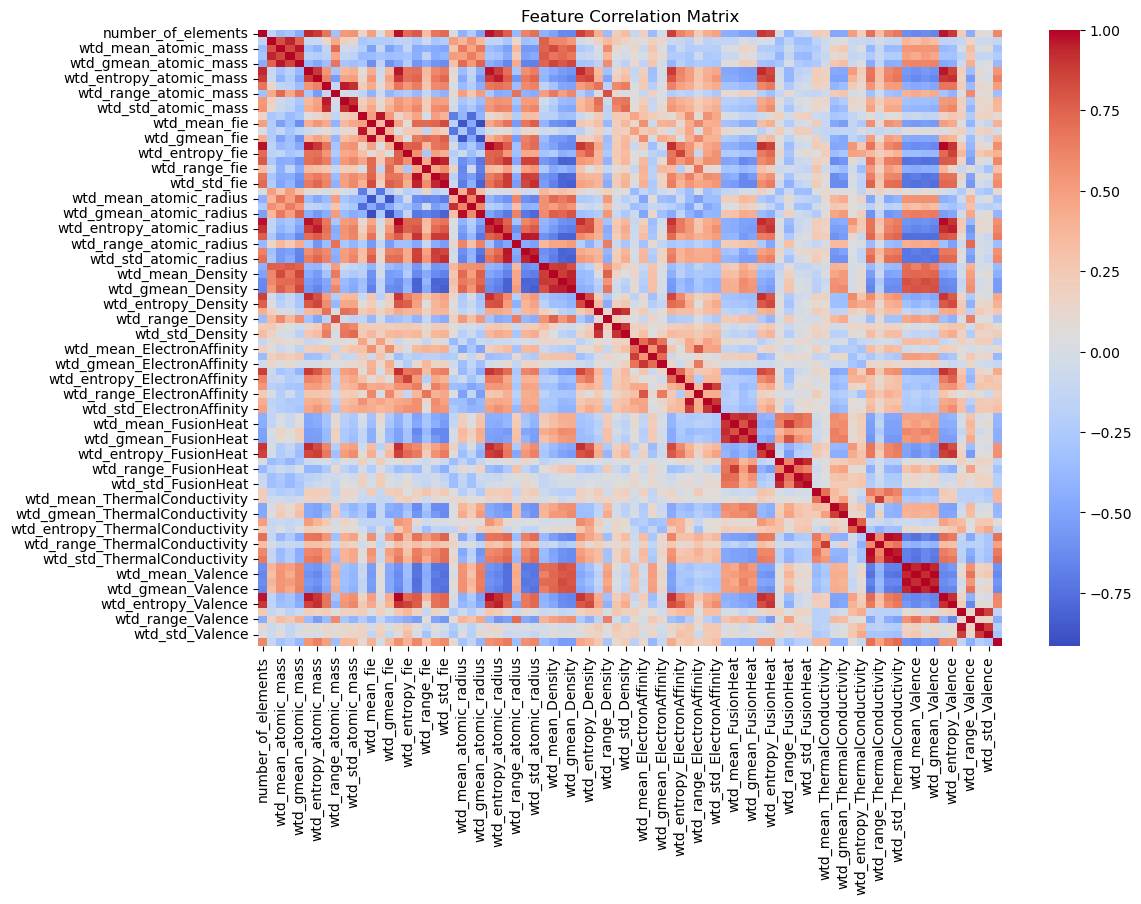

Top Features Correlated with Critical Temperature:
critical_temp                  1.000000
wtd_std_ThermalConductivity    0.721271
range_ThermalConductivity      0.687654
range_atomic_radius            0.653759
std_ThermalConductivity        0.653632
wtd_entropy_atomic_mass        0.626930
wtd_entropy_atomic_radius      0.603494
number_of_elements             0.601069
range_fie                      0.600790
wtd_std_atomic_radius          0.599199
Name: critical_temp, dtype: float64

Selected Features for Model Training:
['critical_temp', 'wtd_std_ThermalConductivity', 'range_ThermalConductivity', 'range_atomic_radius', 'std_ThermalConductivity', 'wtd_entropy_atomic_mass', 'wtd_entropy_atomic_radius', 'number_of_elements', 'range_fie', 'wtd_std_atomic_radius', 'entropy_Valence', 'wtd_entropy_Valence', 'wtd_std_fie', 'entropy_fie', 'wtd_entropy_FusionHeat', 'std_atomic_radius', 'entropy_atomic_radius', 'entropy_FusionHeat', 'entropy_atomic_mass', 'std_fie', 'range_atomic_mass', 'wtd_rang

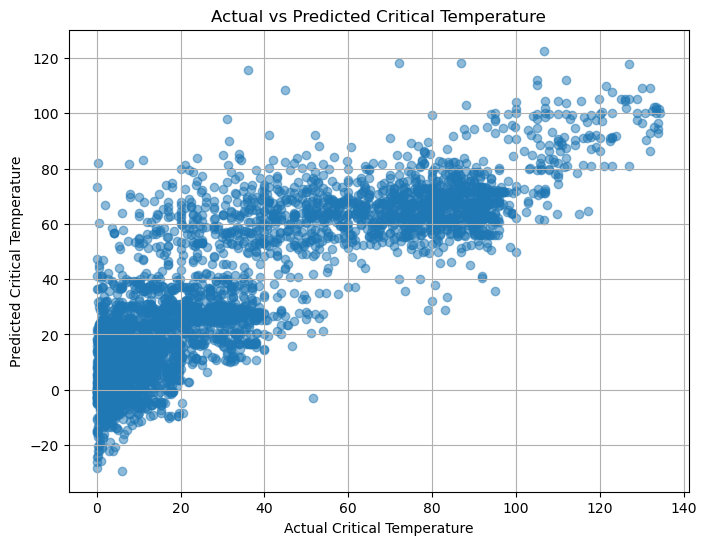

Cross-Validation Results:
Averaged Mean Squared Error (MSE): 310.66
Averaged R-squared (R²): 0.73
Ablation Study - Top 5 Features:
  Averaged MSE: 498.98
  Averaged R²: 0.57

Ablation Study - Top 10 Features:
  Averaged MSE: 479.82
  Averaged R²: 0.59

Ablation Study - All Features:
  Averaged MSE: 310.66
  Averaged R²: 0.73



In [2]:
# Step 1: Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Focus on correlation with critical_temp
correlation_with_target = correlation_matrix['critical_temp'].sort_values(ascending=False)
print("Top Features Correlated with Critical Temperature:")
print(correlation_with_target.head(10))  # Top 10 positively correlated features

# Step 2: Feature Selection
# Selecting features with absolute correlation > 0.2 (adjust threshold as needed)
selected_features = correlation_with_target[abs(correlation_with_target) > 0.2].index.tolist()
print("\nSelected Features for Model Training:")
print(selected_features)

# Step 3: Split Dataset into Training and Testing Sets
X = normalized_data[selected_features].drop(columns=['critical_temp'])
y = normalized_data['critical_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Step 6: Visualization of Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Critical Temperature")
plt.ylabel("Predicted Critical Temperature")
plt.title("Actual vs Predicted Critical Temperature")
plt.grid()
plt.show()


from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Initialize model
linear_model = LinearRegression()

# K-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define scoring metrics
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(linear_model, normalized_data.drop(columns=["critical_temp"]), normalized_data["critical_temp"], 
                             cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(linear_model, normalized_data.drop(columns=["critical_temp"]), normalized_data["critical_temp"], 
                            cv=kf, scoring=r2_scorer)

# Report averaged scores
print("Cross-Validation Results:")
print(f"Averaged Mean Squared Error (MSE): {abs(np.mean(mse_scores)):.2f}")
print(f"Averaged R-squared (R²): {np.mean(r2_scores):.2f}")


# Define subsets of features to evaluate
feature_sets = {
    "Top 5 Features": ["wtd_std_ThermalConductivity", "range_ThermalConductivity", 
                       "range_atomic_radius", "std_ThermalConductivity", 
                       "wtd_entropy_atomic_mass"],
    "Top 10 Features": ["wtd_std_ThermalConductivity", "range_ThermalConductivity", 
                        "range_atomic_radius", "std_ThermalConductivity", 
                        "wtd_entropy_atomic_mass", "wtd_entropy_atomic_radius", 
                        "number_of_elements", "range_fie", 
                        "wtd_std_atomic_radius", "entropy_Valence"],
    "All Features": list(normalized_data.columns.drop("critical_temp")),
}

# Loop through each subset of features and evaluate performance
for set_name, features in feature_sets.items():
    # Extract features for this subset
    X = normalized_data[features]
    y = normalized_data["critical_temp"]
    
    # Perform cross-validation
    mse_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=r2_scorer)
    
    # Report results
    print(f"Ablation Study - {set_name}:")
    print(f"  Averaged MSE: {abs(np.mean(mse_scores)):.2f}")
    print(f"  Averaged R²: {np.mean(r2_scores):.2f}\n")


- Refined Best Lasso Alpha: 0.01
- Refined Best Lasso CV MSE: 357.3928030771264
- Refined Averaged MSE for Best Lasso: 337.8833
- Refined Averaged R² for Best Lasso: 0.2628

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('train.csv')
target = data['critical_temp']
features = data.drop(columns=['critical_temp'])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define and refine Lasso regression with GridSearch
lasso = Lasso(max_iter=50000, tol=1e-4)  # Increase max iterations and tighten tolerance
lasso_params = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000]  # Adjust alpha range for regularization strength
}
lasso_grid = GridSearchCV(
    estimator=lasso,
    param_grid=lasso_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
lasso_grid.fit(features_scaled, target)

# Evaluate the best Lasso model
best_lasso = lasso_grid.best_estimator_
cross_val_scores_mse = cross_val_score(best_lasso, features_scaled, target, cv=10, scoring='neg_mean_squared_error')
cross_val_scores_r2 = cross_val_score(best_lasso, features_scaled, target, cv=10, scoring='r2')

# Calculate average metrics
avg_mse = -np.mean(cross_val_scores_mse)
avg_r2 = np.mean(cross_val_scores_r2)

# Display results
print("Refined Best Lasso Alpha:", lasso_grid.best_params_['alpha'])
print("Refined Best Lasso CV MSE:", -lasso_grid.best_score_)
print(f"Refined Averaged MSE for Best Lasso: {avg_mse:.4f}")
print(f"Refined Averaged R² for Best Lasso: {avg_r2:.4f}")

# Visualize residuals of the best Lasso model
predictions = best_lasso.predict(features_scaled)
residuals = target - predictions

plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Lasso Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


Refined Best Lasso Alpha: 0.01
Refined Best Lasso CV MSE: 357.3928030771264
Refined Averaged MSE for Best Lasso: 337.8833
Refined Averaged R² for Best Lasso: 0.2628


Best Ridge Alpha: 100
Best Ridge CV MSE: 0.7428628423111887
Best Lasso Alpha: 0.01
Best Lasso CV MSE: 0.49055433576537943
Averaged MSE for Best Lasso: 0.4597
Averaged R² for Best Lasso: 0.3782


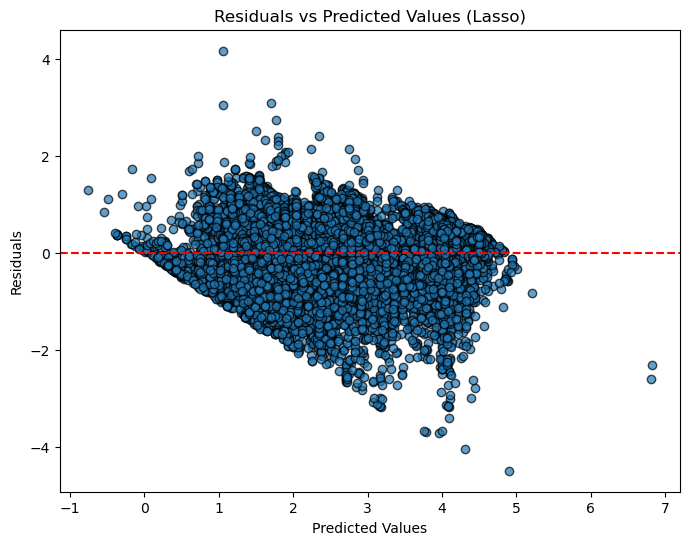

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and merge datasets
data = pd.read_csv('train.csv')
metadata = pd.read_csv('unique_m.csv')
data = pd.merge(data, metadata.drop(columns=['critical_temp', 'material']), left_index=True, right_index=True)

# Preprocessing
target = np.log1p(data['critical_temp'])  # Log-transform the target
features = data.drop(columns=['critical_temp'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# GridSearch for Ridge Regression
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(features_scaled, target)

# Ridge results
print("Best Ridge Alpha:", ridge_grid.best_params_['alpha'])
print("Best Ridge CV MSE:", -ridge_grid.best_score_)

# GridSearch for Lasso Regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso(max_iter=50000, tol=1e-4)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(features_scaled, target)

# Lasso results
print("Best Lasso Alpha:", lasso_grid.best_params_['alpha'])
print("Best Lasso CV MSE:", -lasso_grid.best_score_)

# Evaluate the best Lasso model
best_lasso = lasso_grid.best_estimator_
lasso_cv_mse = cross_val_score(best_lasso, features_scaled, target, cv=10, scoring='neg_mean_squared_error')
lasso_cv_r2 = cross_val_score(best_lasso, features_scaled, target, cv=10, scoring='r2')

avg_mse = -np.mean(lasso_cv_mse)
avg_r2 = np.mean(lasso_cv_r2)

print(f"Averaged MSE for Best Lasso: {avg_mse:.4f}")
print(f"Averaged R² for Best Lasso: {avg_r2:.4f}")

# Plot residuals for Lasso model
predictions = best_lasso.predict(features_scaled)
residuals = target - predictions

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (Lasso)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


- Best Ridge Alpha: 100
- Best Ridge CV MSE: 0.7428628423111887
- Best Lasso Alpha: 0.01
- Best Lasso CV MSE: 0.49055433576537943
- Average MSE (10-fold CV): 0.4597
- Average R² (10-fold CV): 0.3782


   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

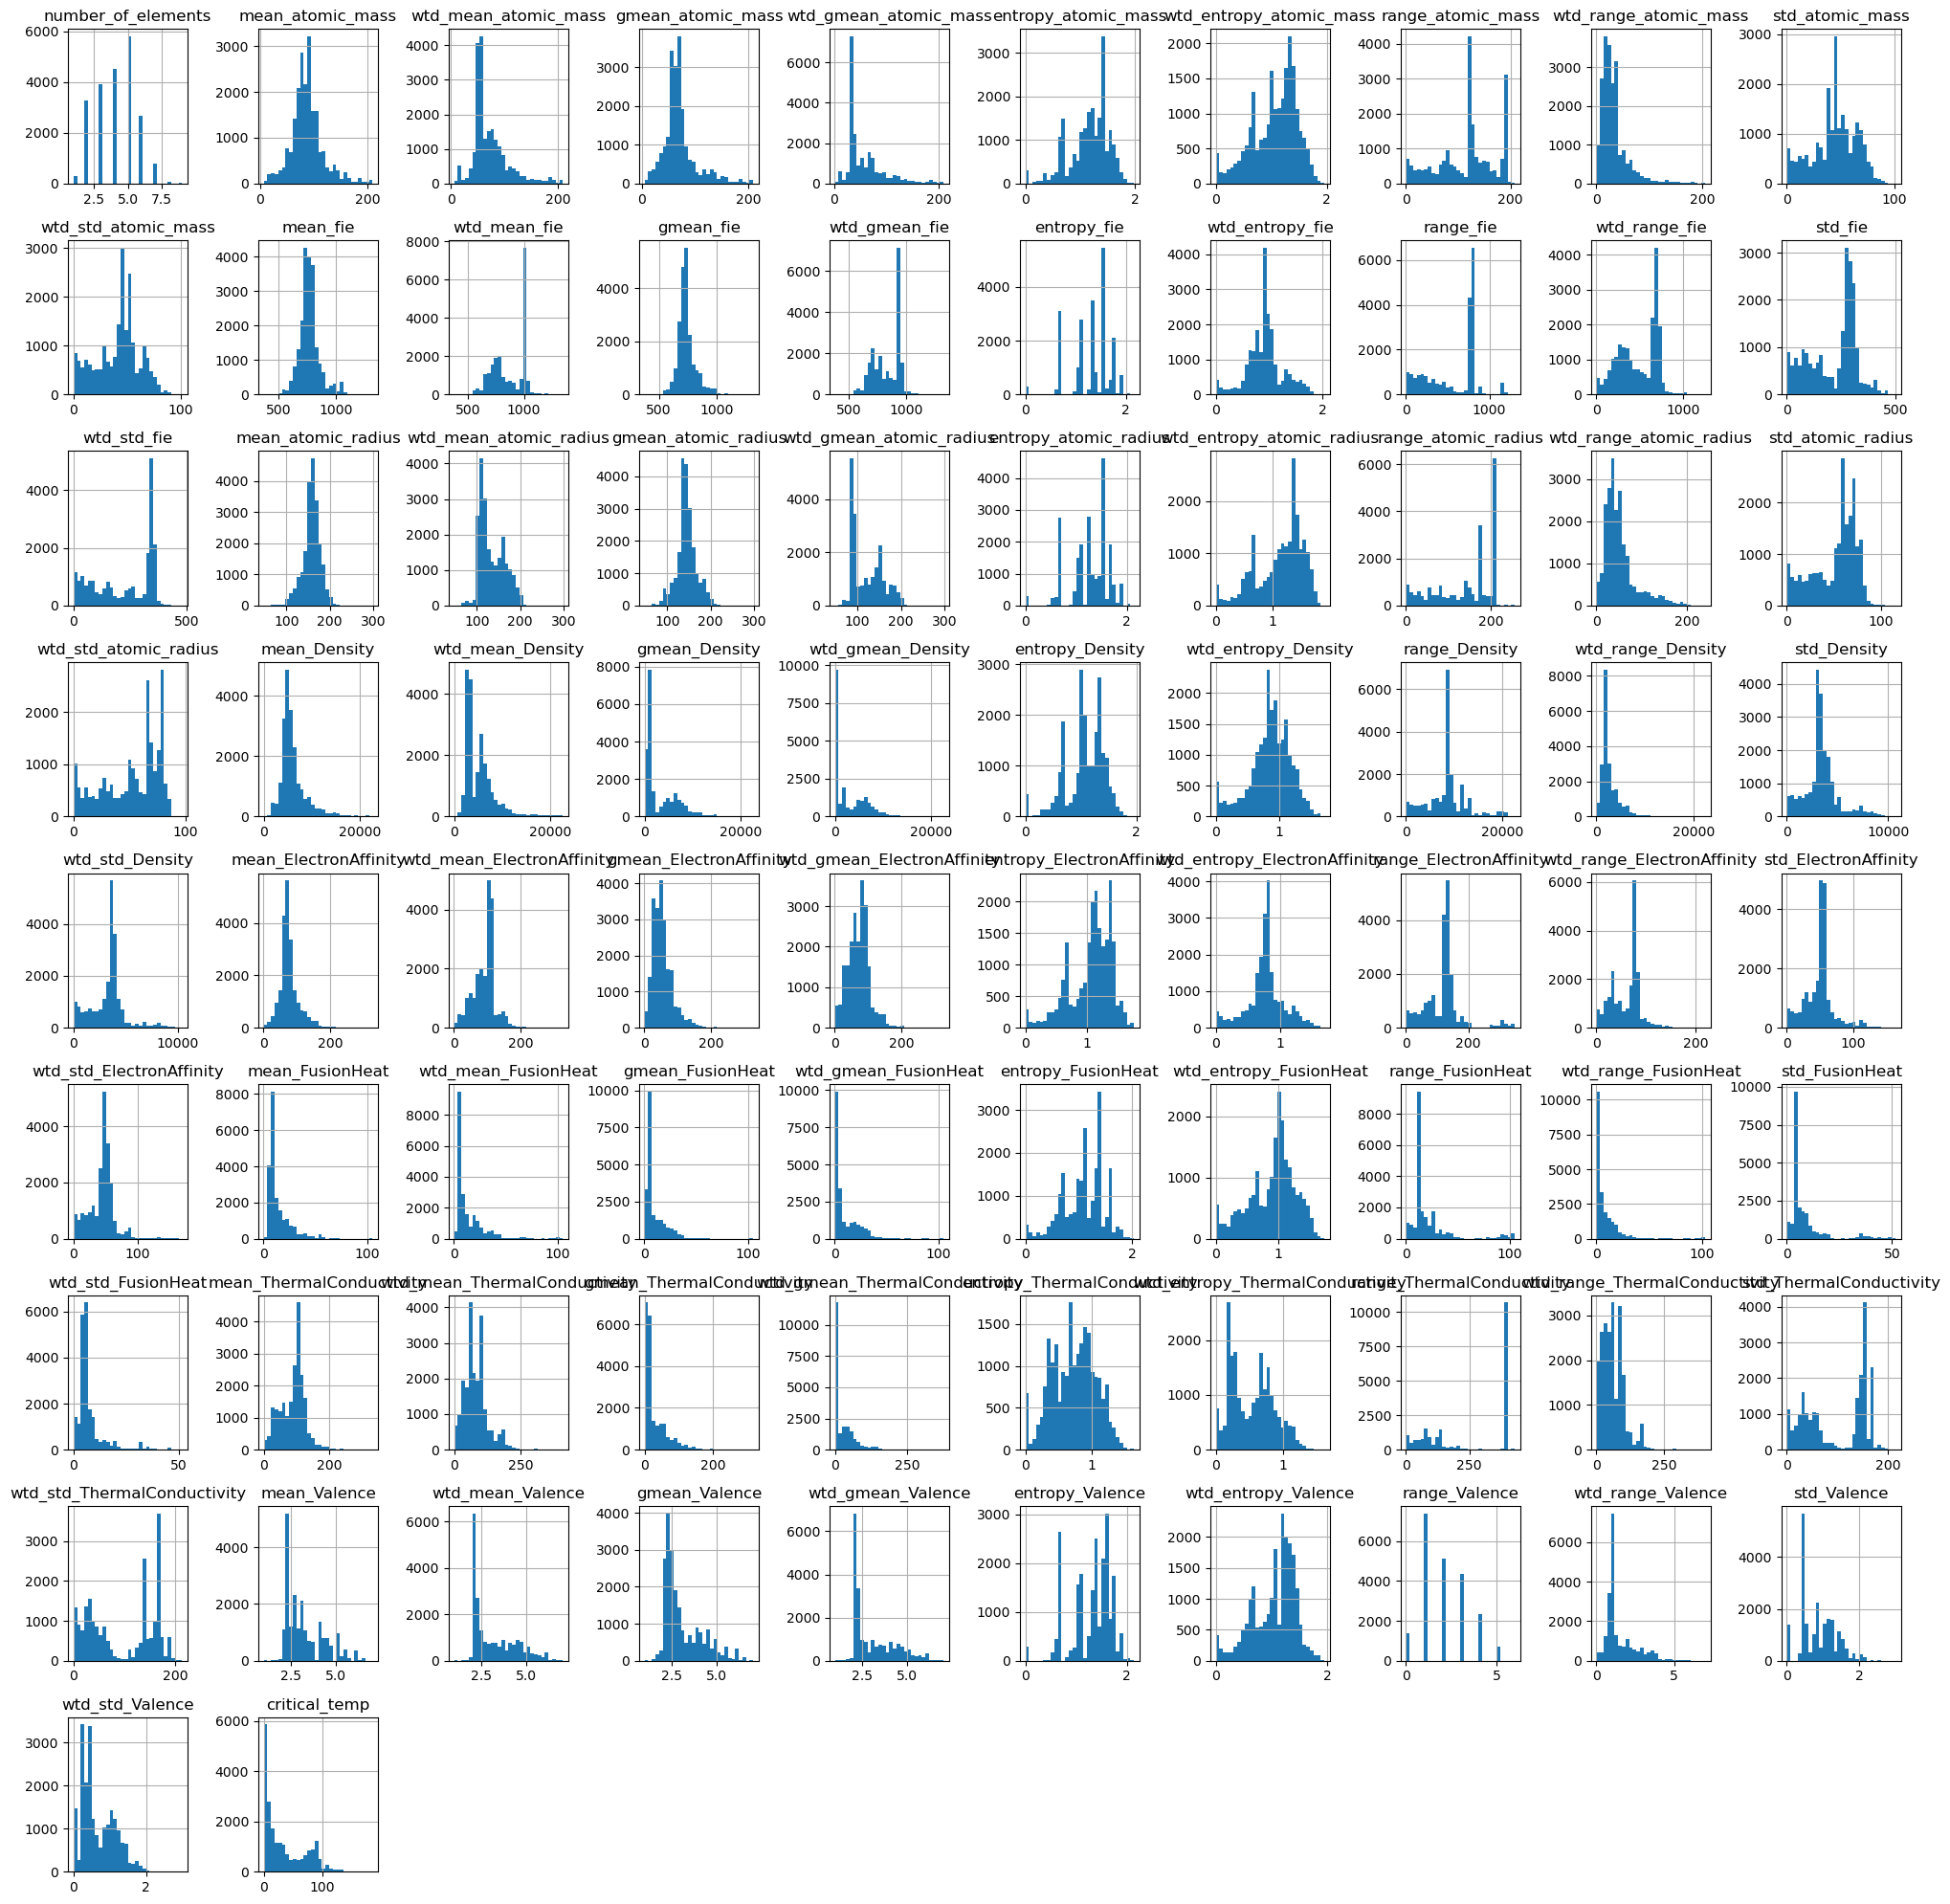

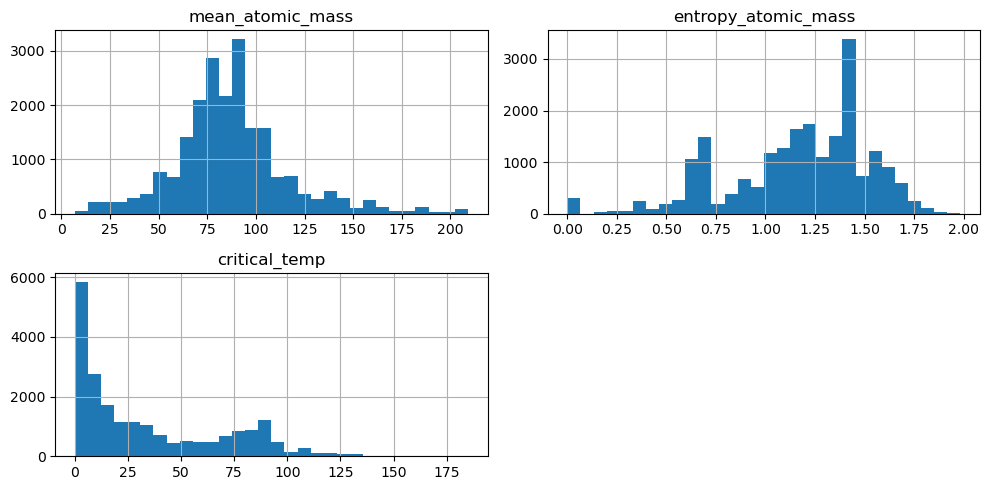

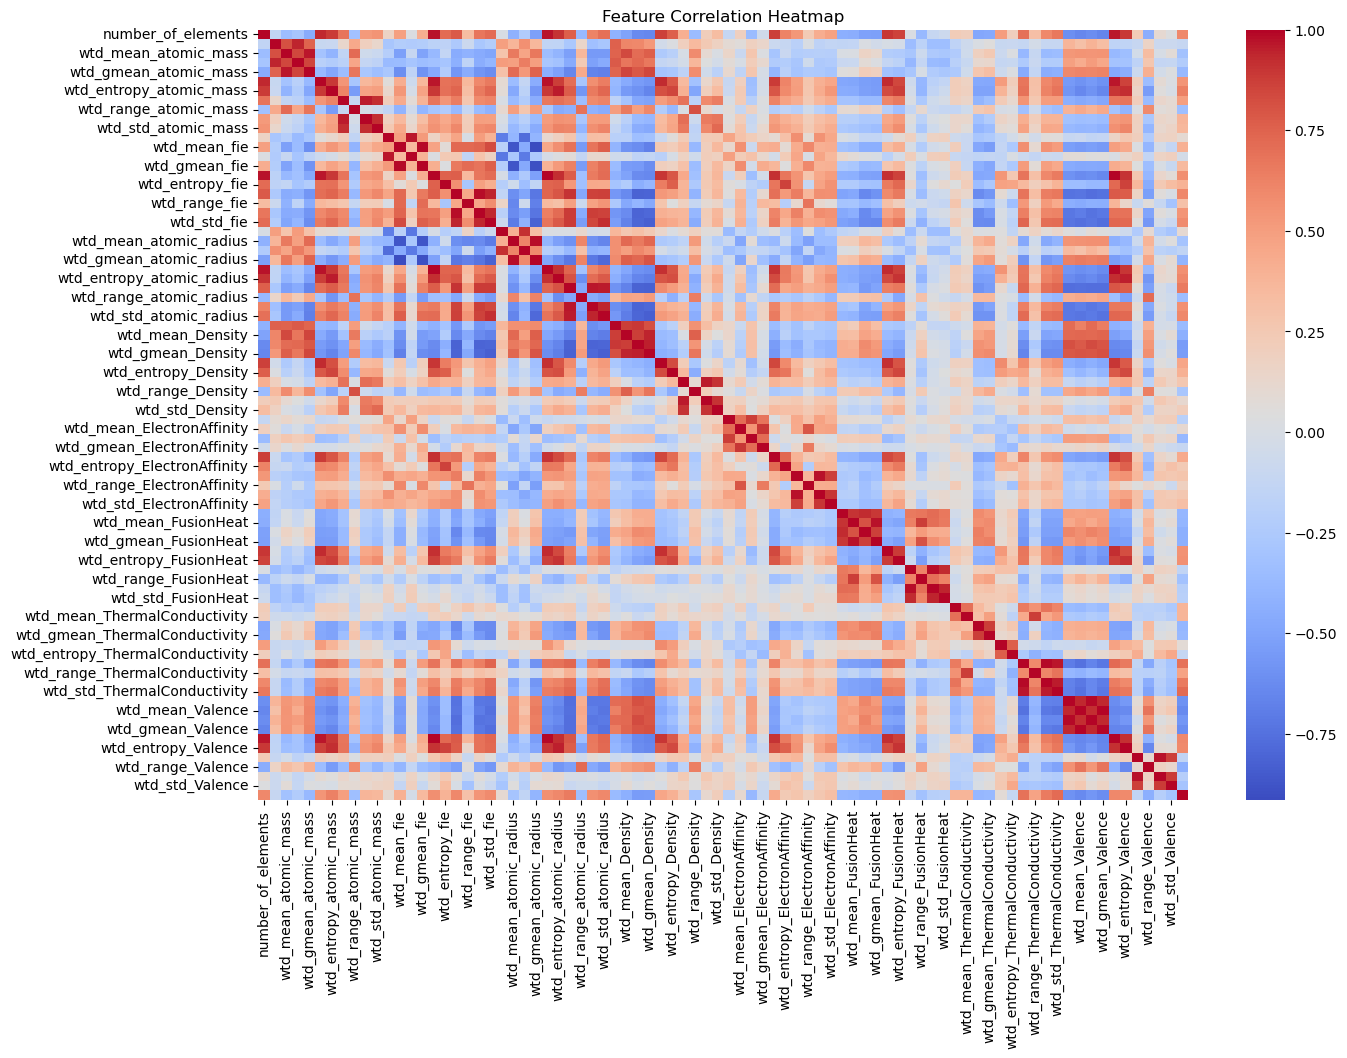

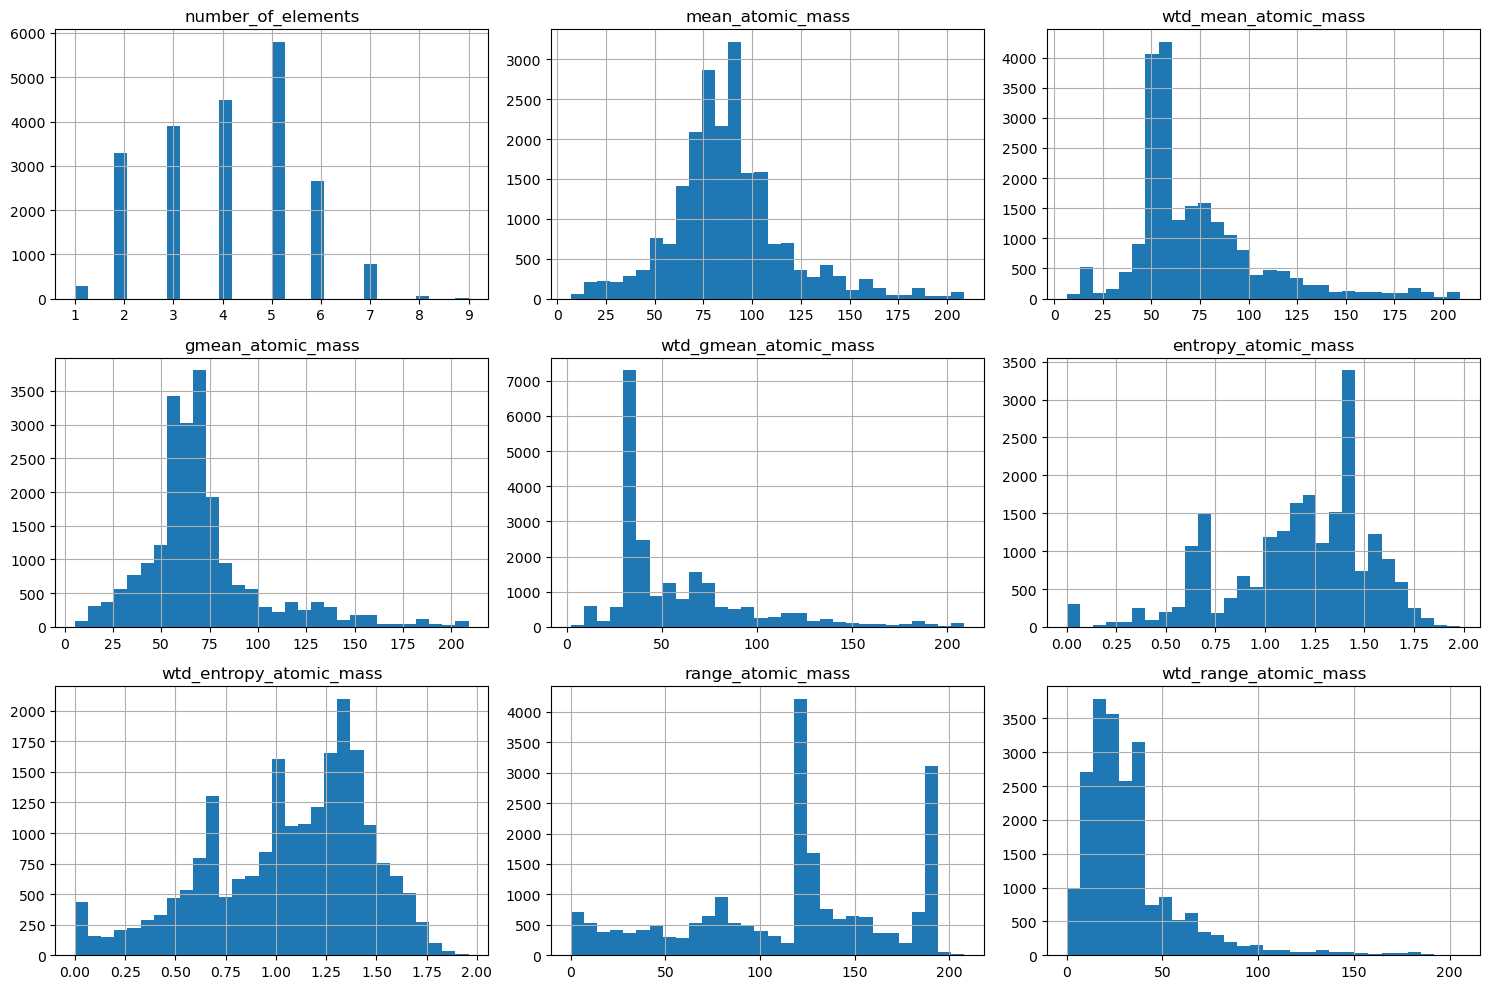

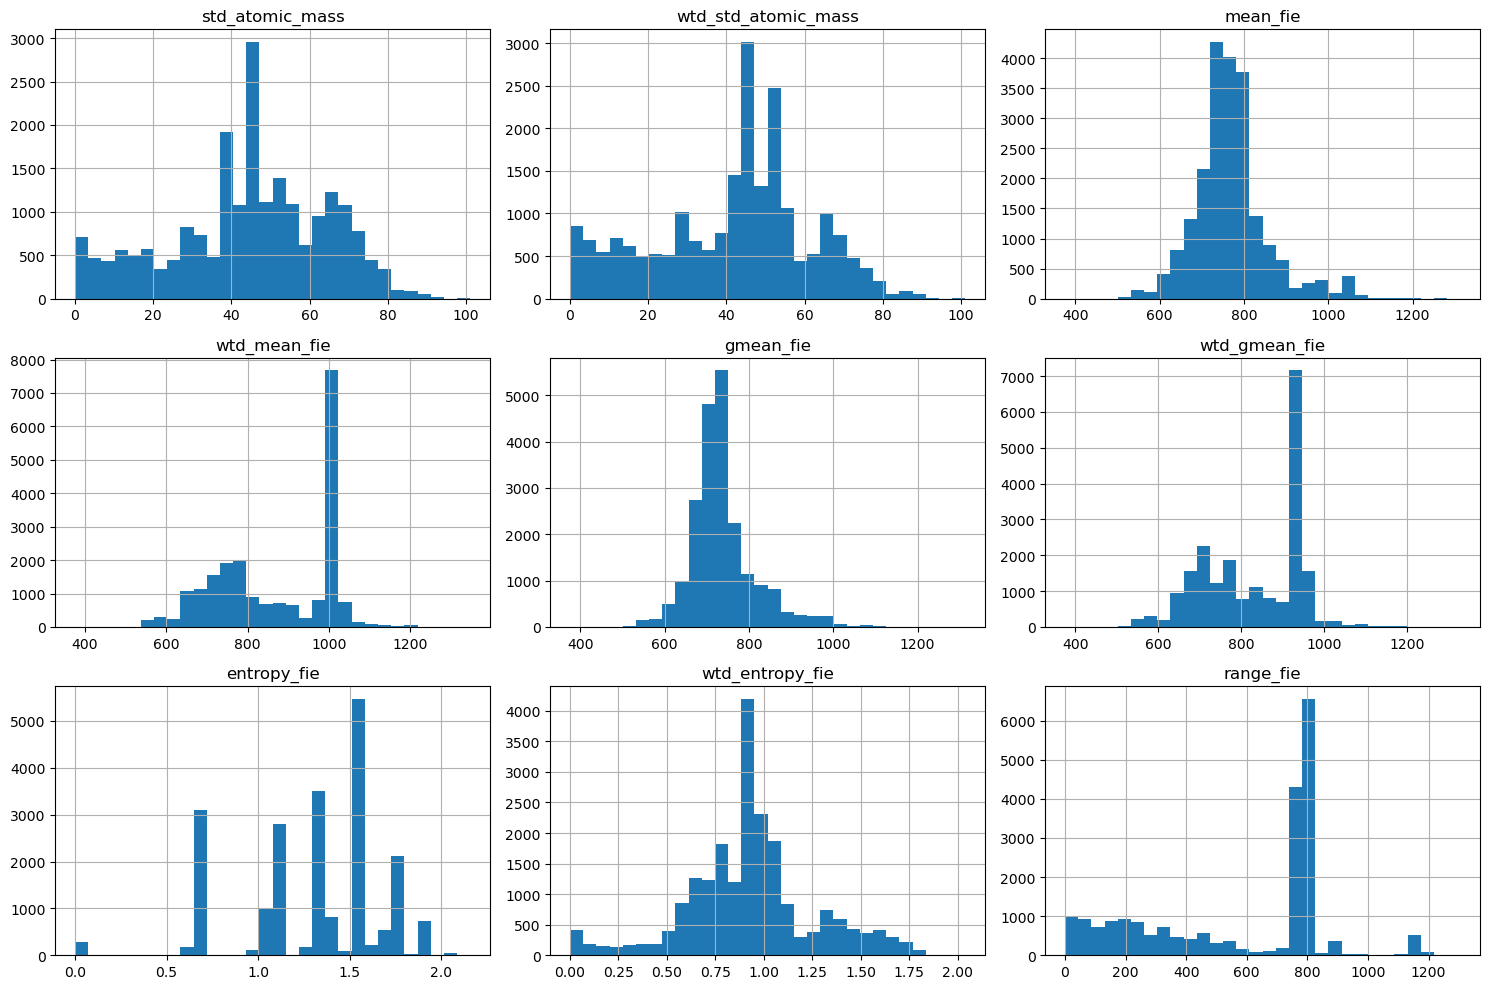

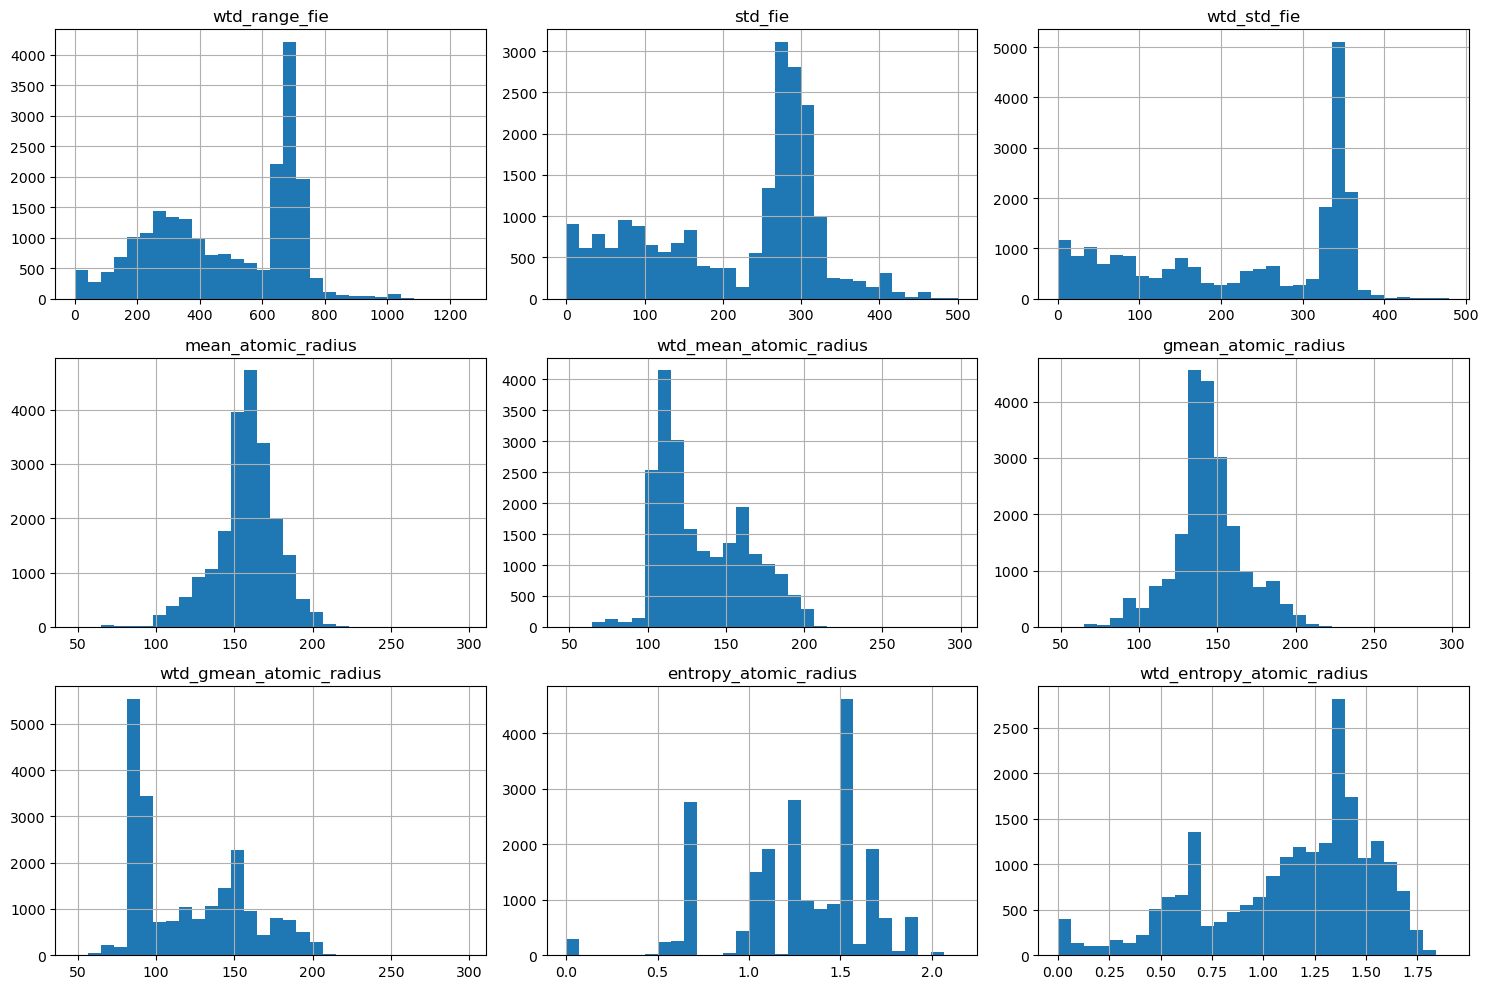

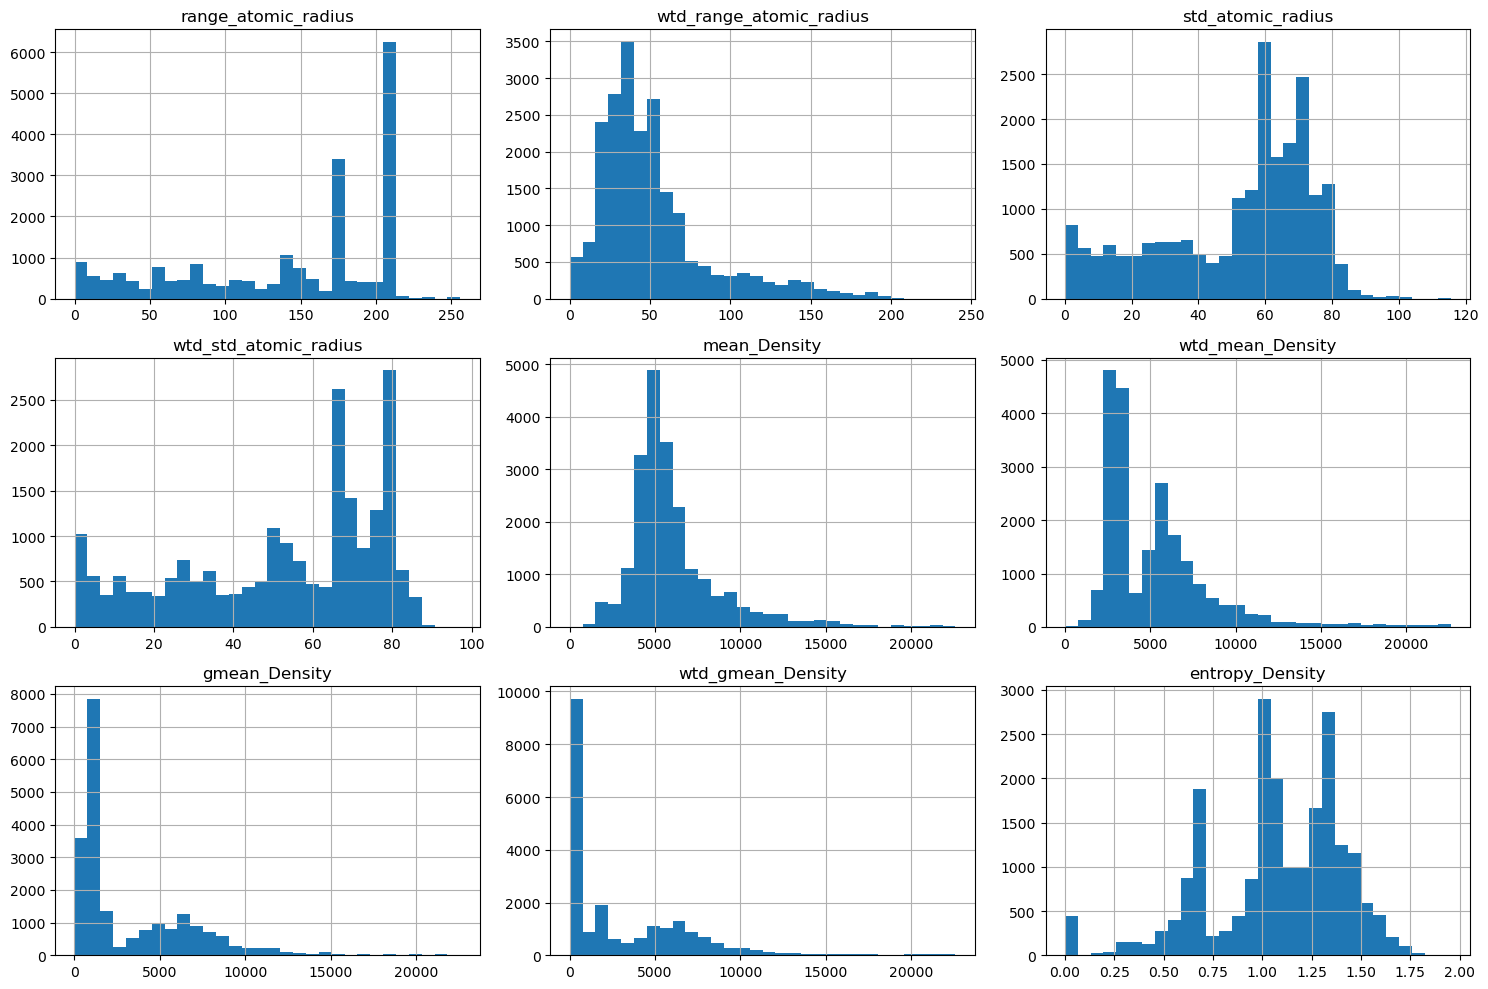

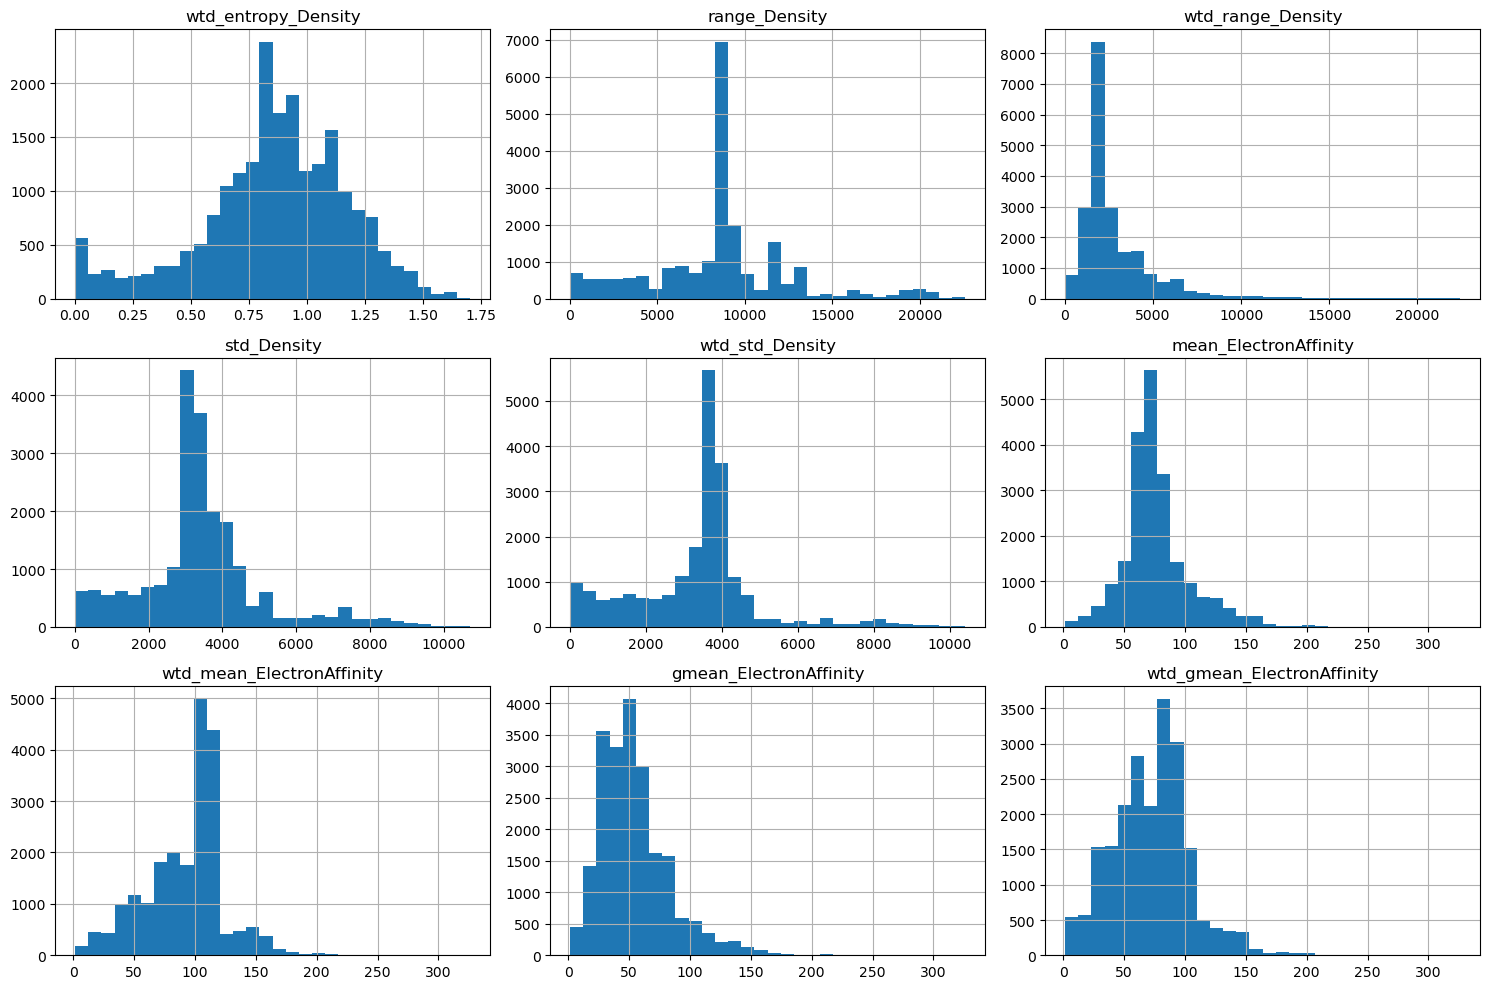

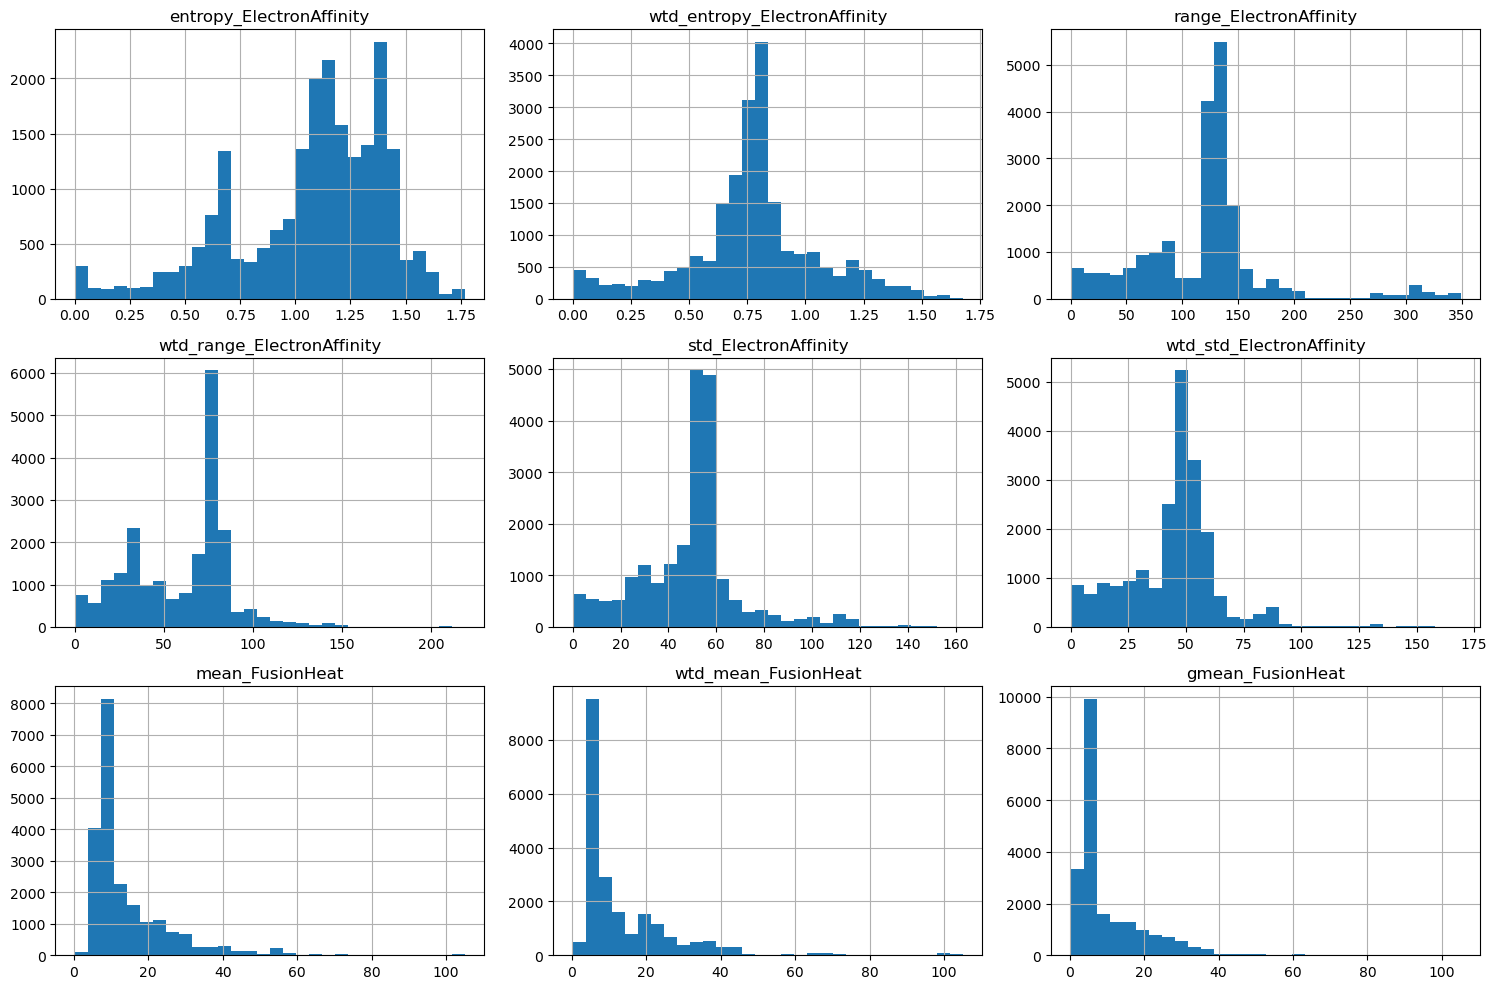

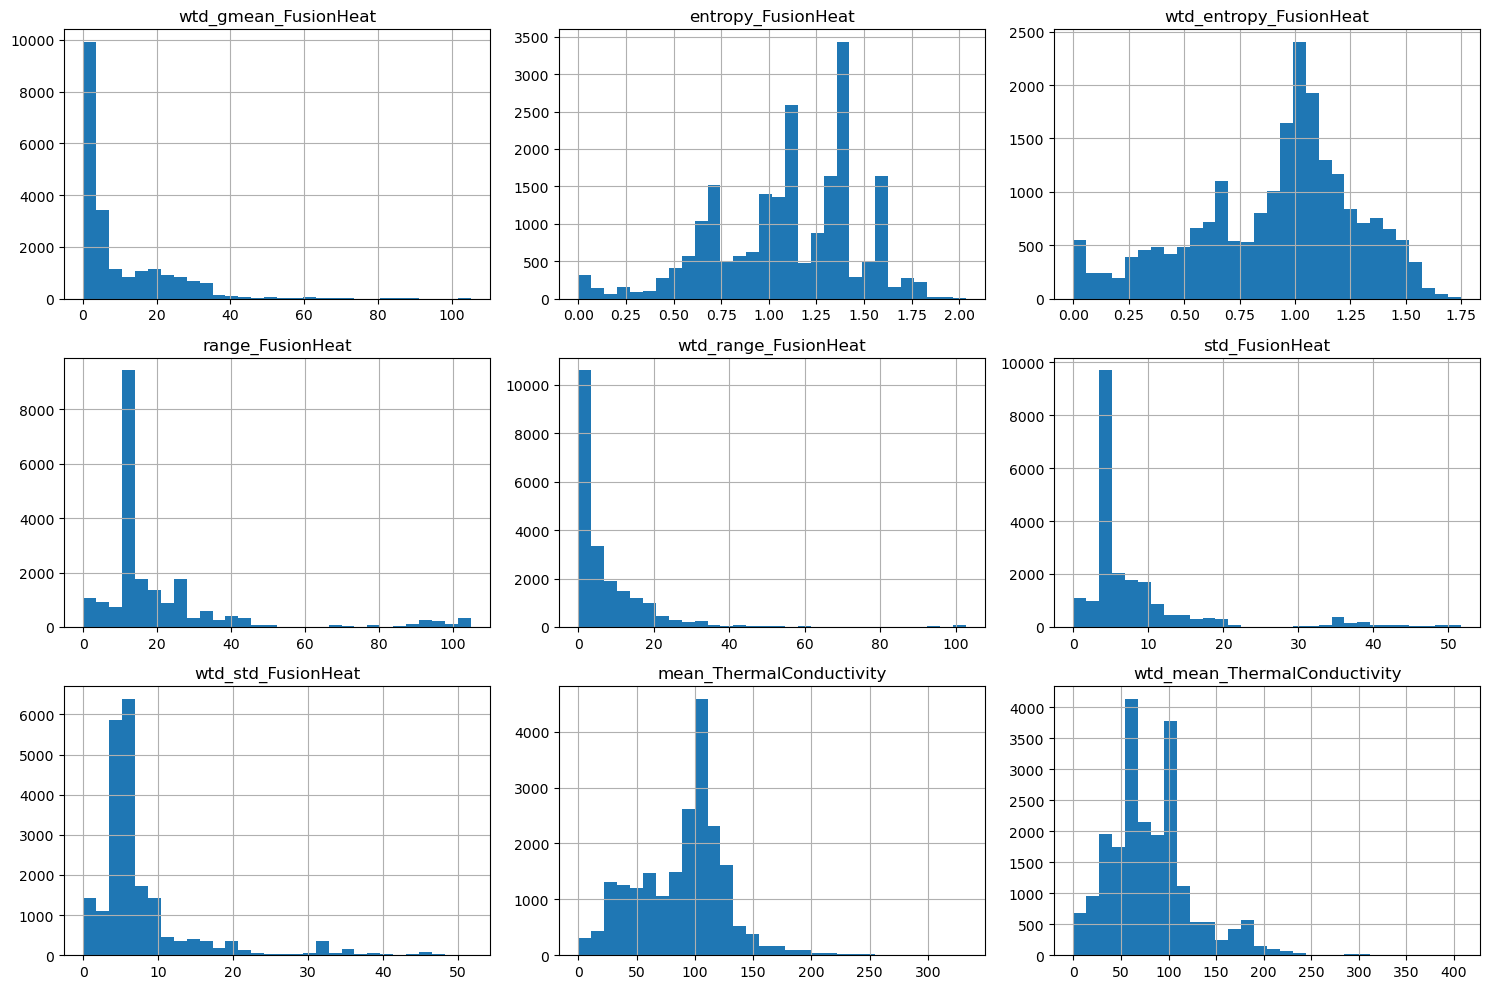

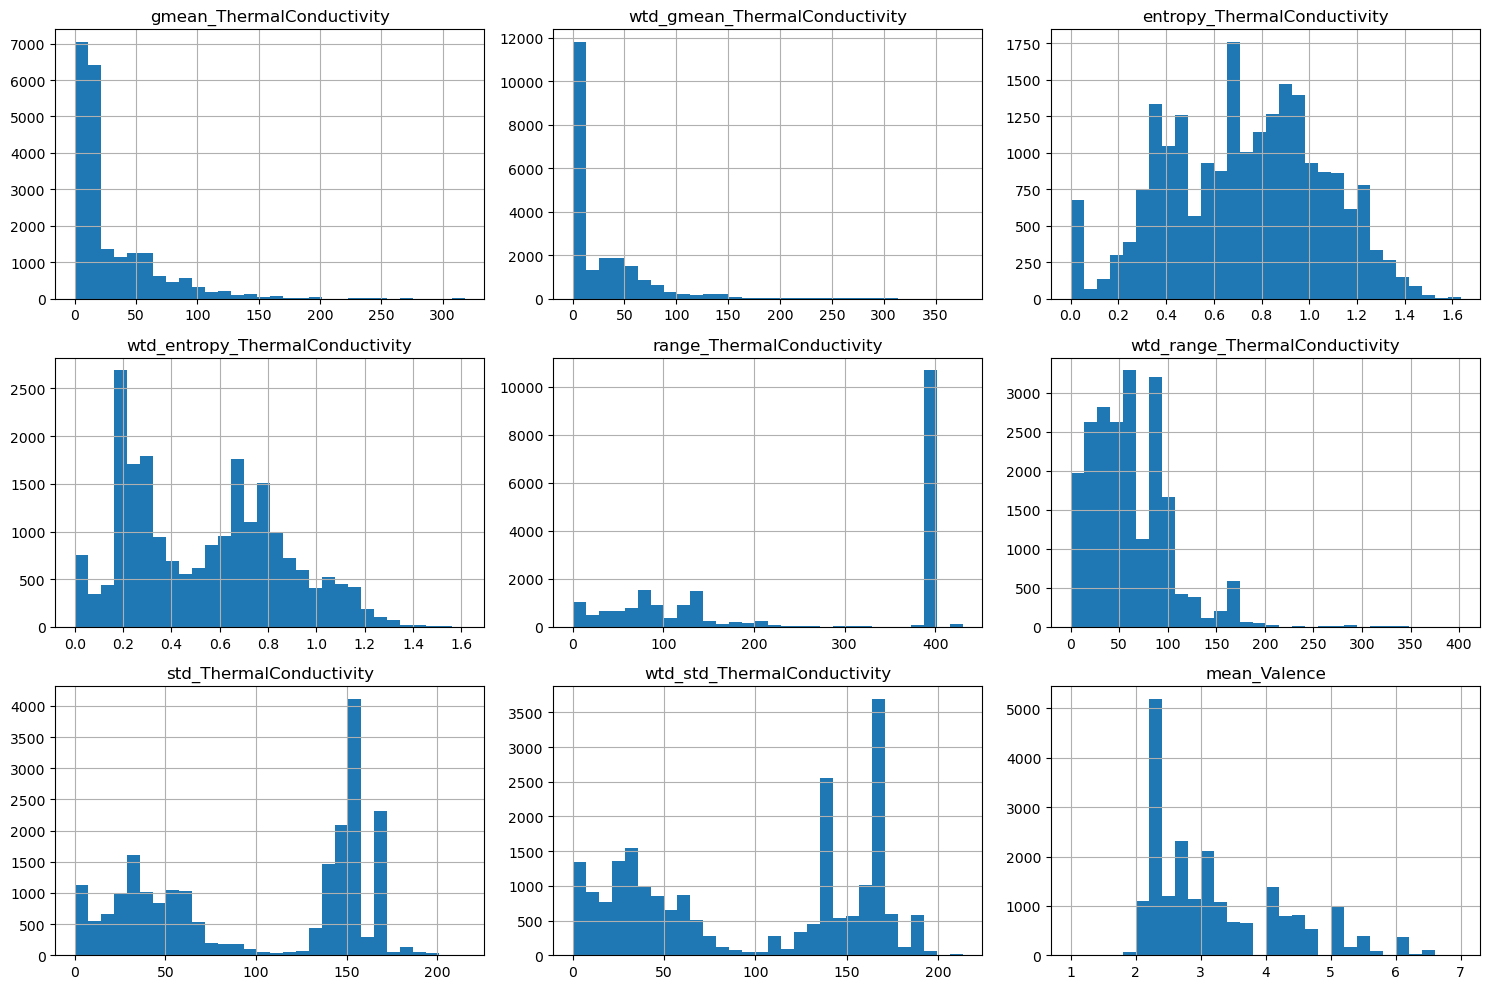

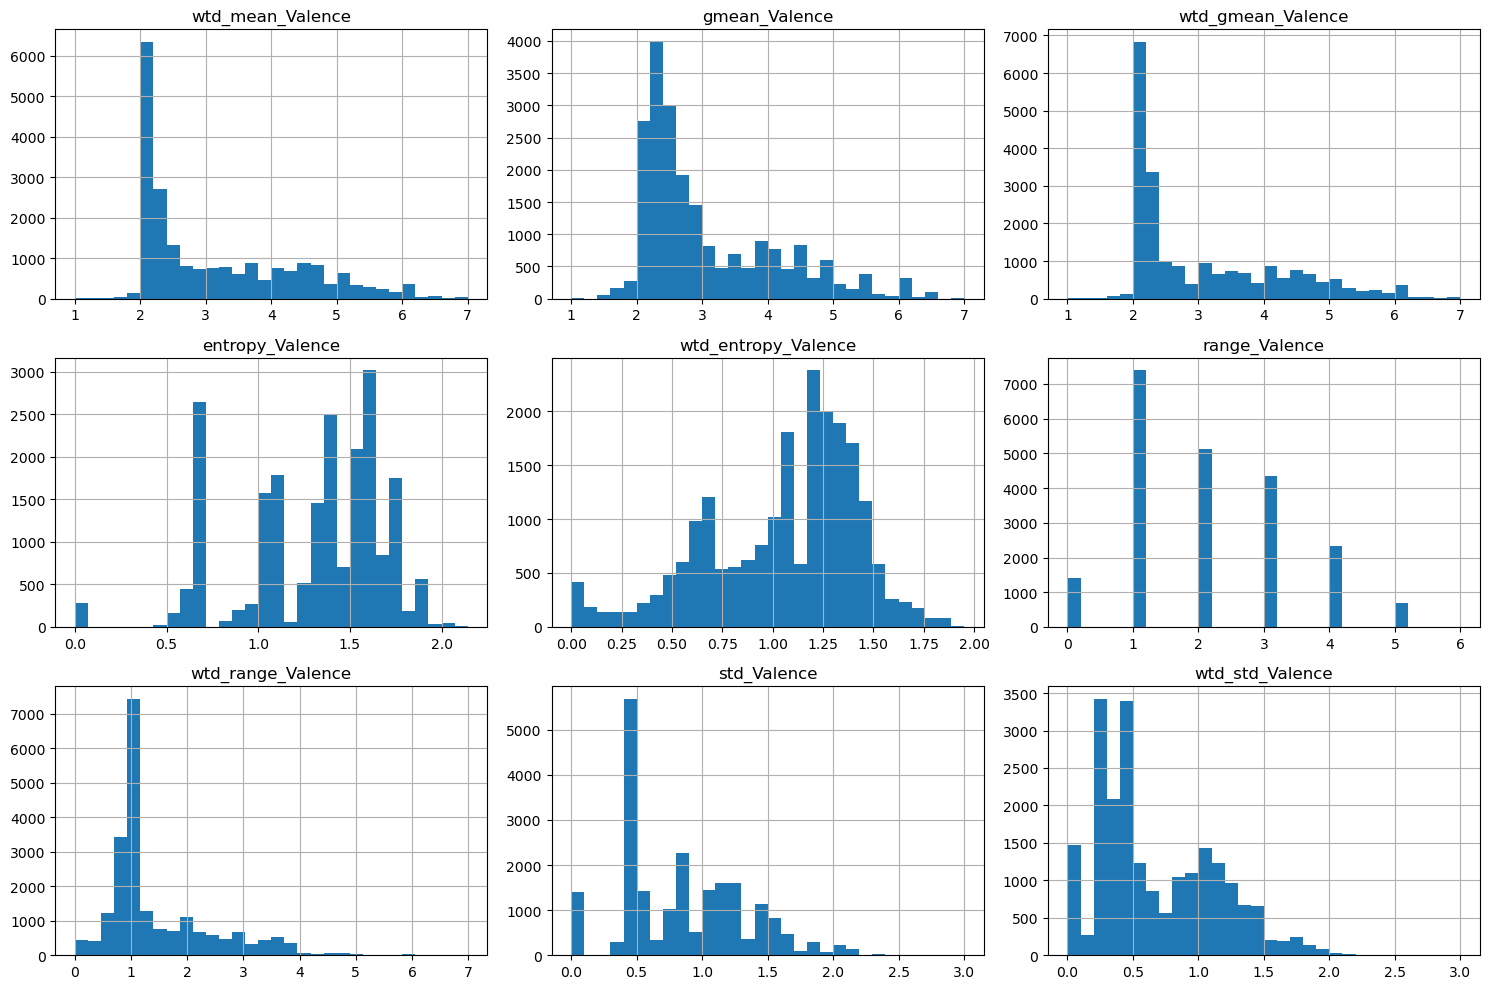

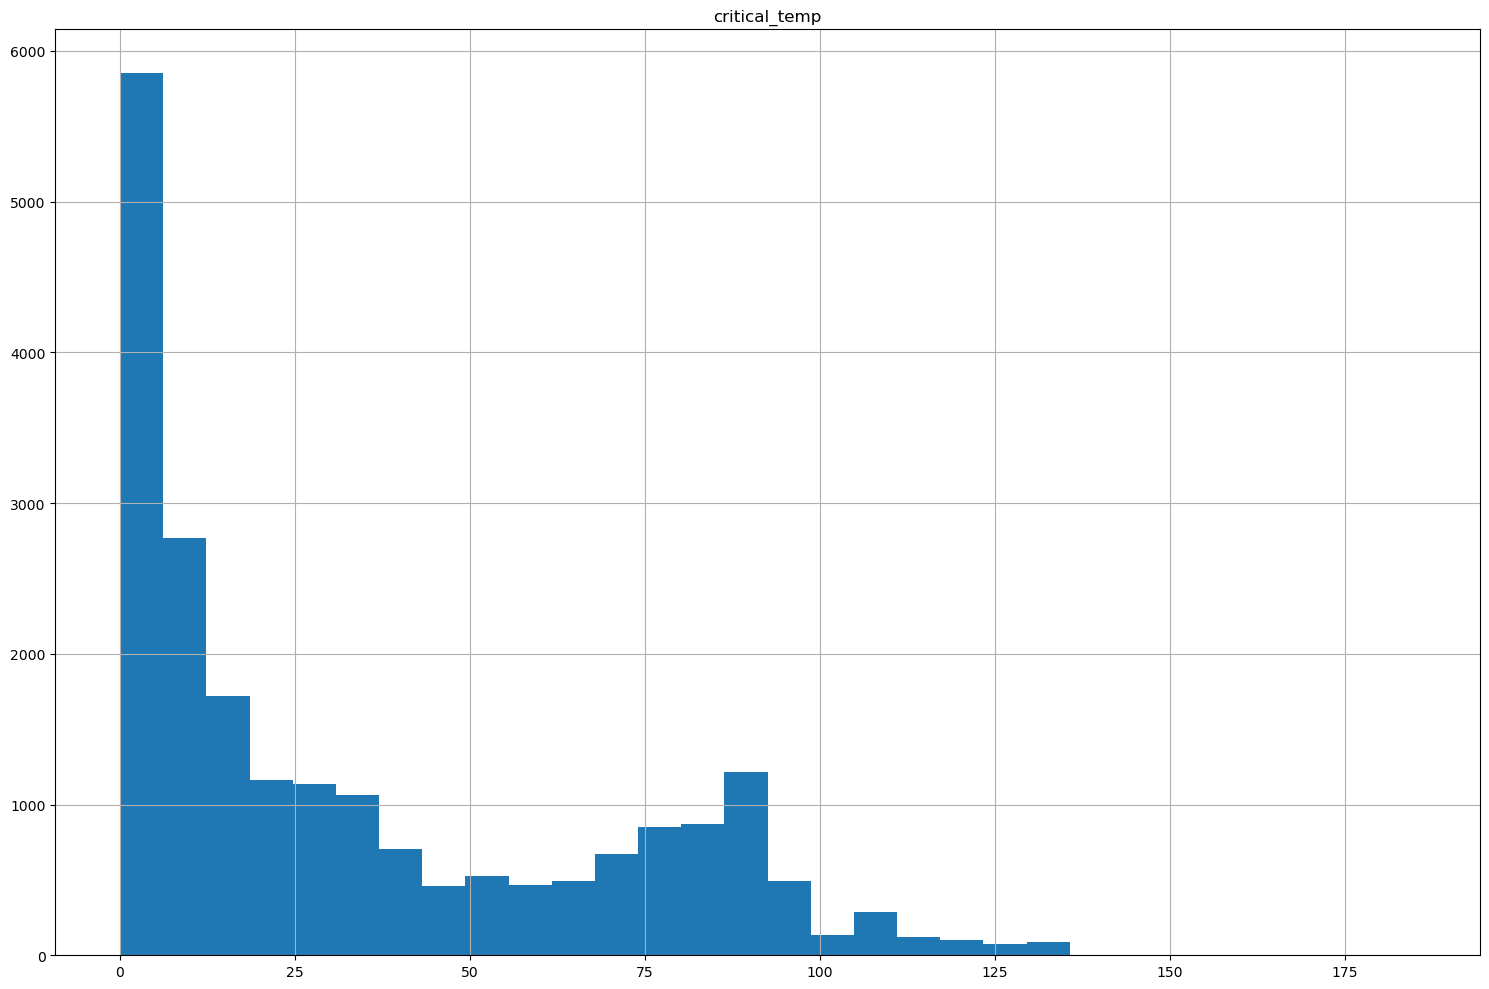

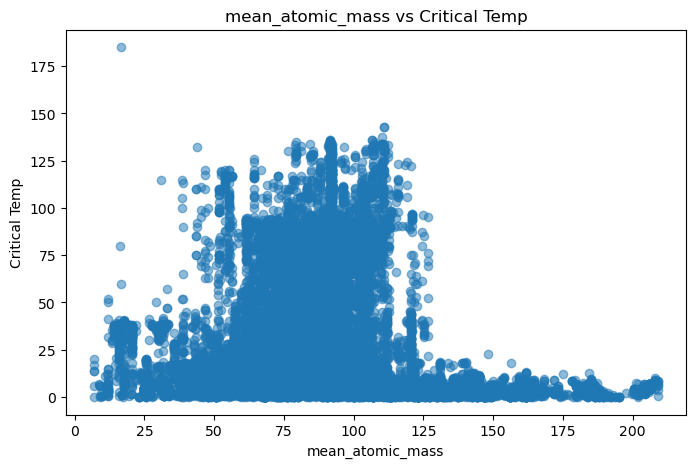

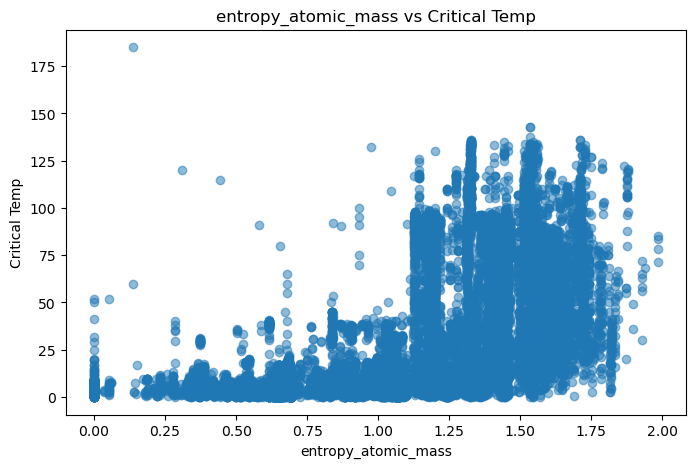

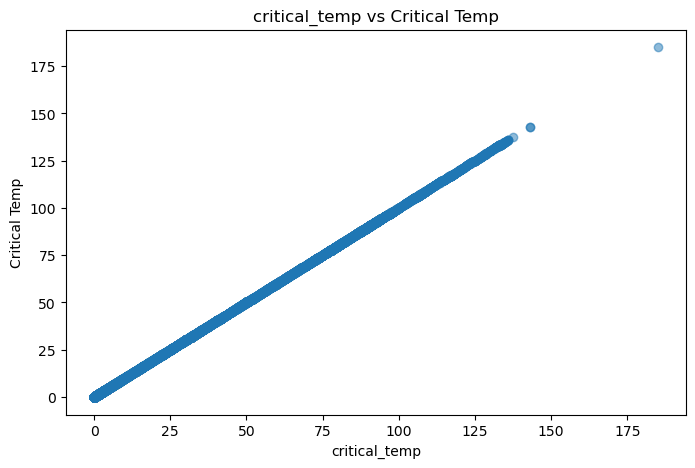

Training set size (X_train): (17010, 81), Target size (y_train): (17010,)
Testing set size (X_test): (4253, 81), Target size (y_test): (4253,)
Target column 'critical_temp' found.
Training set size (X_train): (17010, 81), Target size (y_train): (17010,)
Testing set size (X_test): (4253, 81), Target size (y_test): (4253,)
Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_at

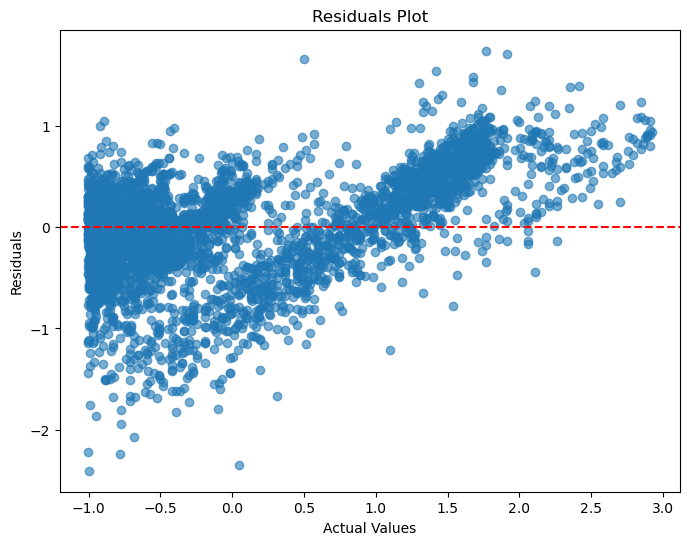

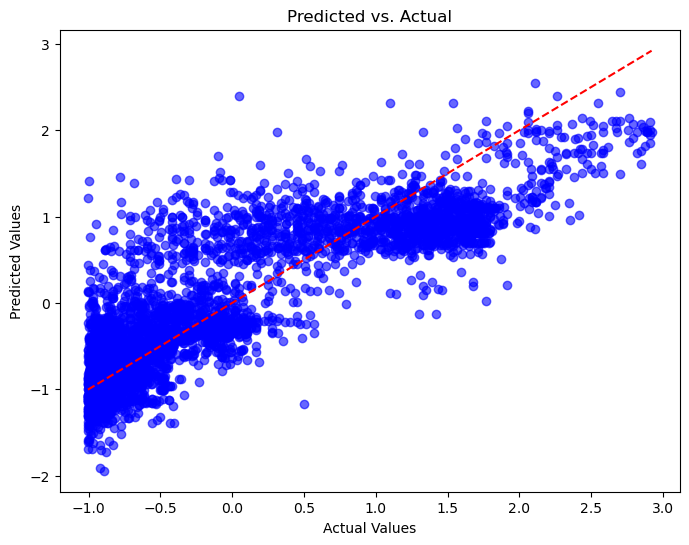

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
data = pd.read_csv('train.csv')  
metadata = pd.read_csv('unique_m.csv') 






# Display basic dataset information
print(data.head())
print(metadata.head())



print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Normalize the dataset
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Display normalized dataset summary
print(normalized_data.describe())

import matplotlib.pyplot as plt

# Plot histograms for each column
data.hist(figsize=(20, 20), bins=30, layout=(9, 10))  # Adjust layout dimensions
plt.tight_layout()
plt.show()

selected_columns = ['mean_atomic_mass', 'entropy_atomic_mass', 'critical_temp']
data[selected_columns].hist(figsize=(10, 5), bins=30)
plt.tight_layout()
plt.show()


# pairwise: 
import seaborn as sns

plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# ITERATE THROUGH BATCHES: 
batch_size = 9  # Adjust based on desired number of subplots per figure
columns = data.columns

for i in range(0, len(columns), batch_size):
    data[columns[i:i+batch_size]].hist(figsize=(15, 10), bins=30)
    plt.tight_layout()
    plt.show()


# FOCUS ON RELATION SHIPS QWITH TARGET VARIABLE: 
for column in ['mean_atomic_mass', 'entropy_atomic_mass', 'critical_temp']:
    plt.figure(figsize=(8, 5))
    plt.scatter(data[column], data['critical_temp'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Critical Temp')
    plt.title(f'{column} vs Critical Temp')
    plt.show()

# Define features and target
target_column = 'critical_temp'
X = normalized_data.drop(columns=[target_column])
y = normalized_data[target_column]

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display split summary
print(f"Training set size (X_train): {X_train.shape}, Target size (y_train): {y_train.shape}")
print(f"Testing set size (X_test): {X_test.shape}, Target size (y_test): {y_test.shape}")

# Define features and target
target_column = 'critical_temp'
if target_column in normalized_data.columns:
    print(f"Target column '{target_column}' found.")
else:
    print(f"Target column '{target_column}' not found in data.")

# Define features and target
X = normalized_data.drop(columns=[target_column])
y = normalized_data[target_column]

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display split summary
print(f"Training set size (X_train): {X_train.shape}, Target size (y_train): {y_train.shape}")
print(f"Testing set size (X_test): {X_test.shape}, Target size (y_test): {y_test.shape}")

X_train.shape
print(normalized_data.columns)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


# Extract coefficients and intercept
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)

print("Feature Importances:\n", coefficients)
print(f"Intercept: {model.intercept_}")

import matplotlib.pyplot as plt

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()

# Predicted vs. Actual scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted vs. Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()





- Training set size: (17010, 167), Testing set size: (4253, 167)
- Linear Regression - MSE: 0.23240675202457944, R²: 0.7631058075354811

- Linear Regression CV - Averaged MSE: 0.6825188361546444, Averaged R²: 0.31641407874038957
- Best Lasso Alpha: 0.01, Best Lasso CV MSE: 0.2821884870485994
- Best Ridge Alpha: 100, Best Ridge CV MSE: 0.3830706591484117
- Lasso - MSE: 0.2559602604843477, R²: 0.7390975146710255
- Ridge - MSE: 0.23489453325099344, R²: 0.7605699908282393

   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607           

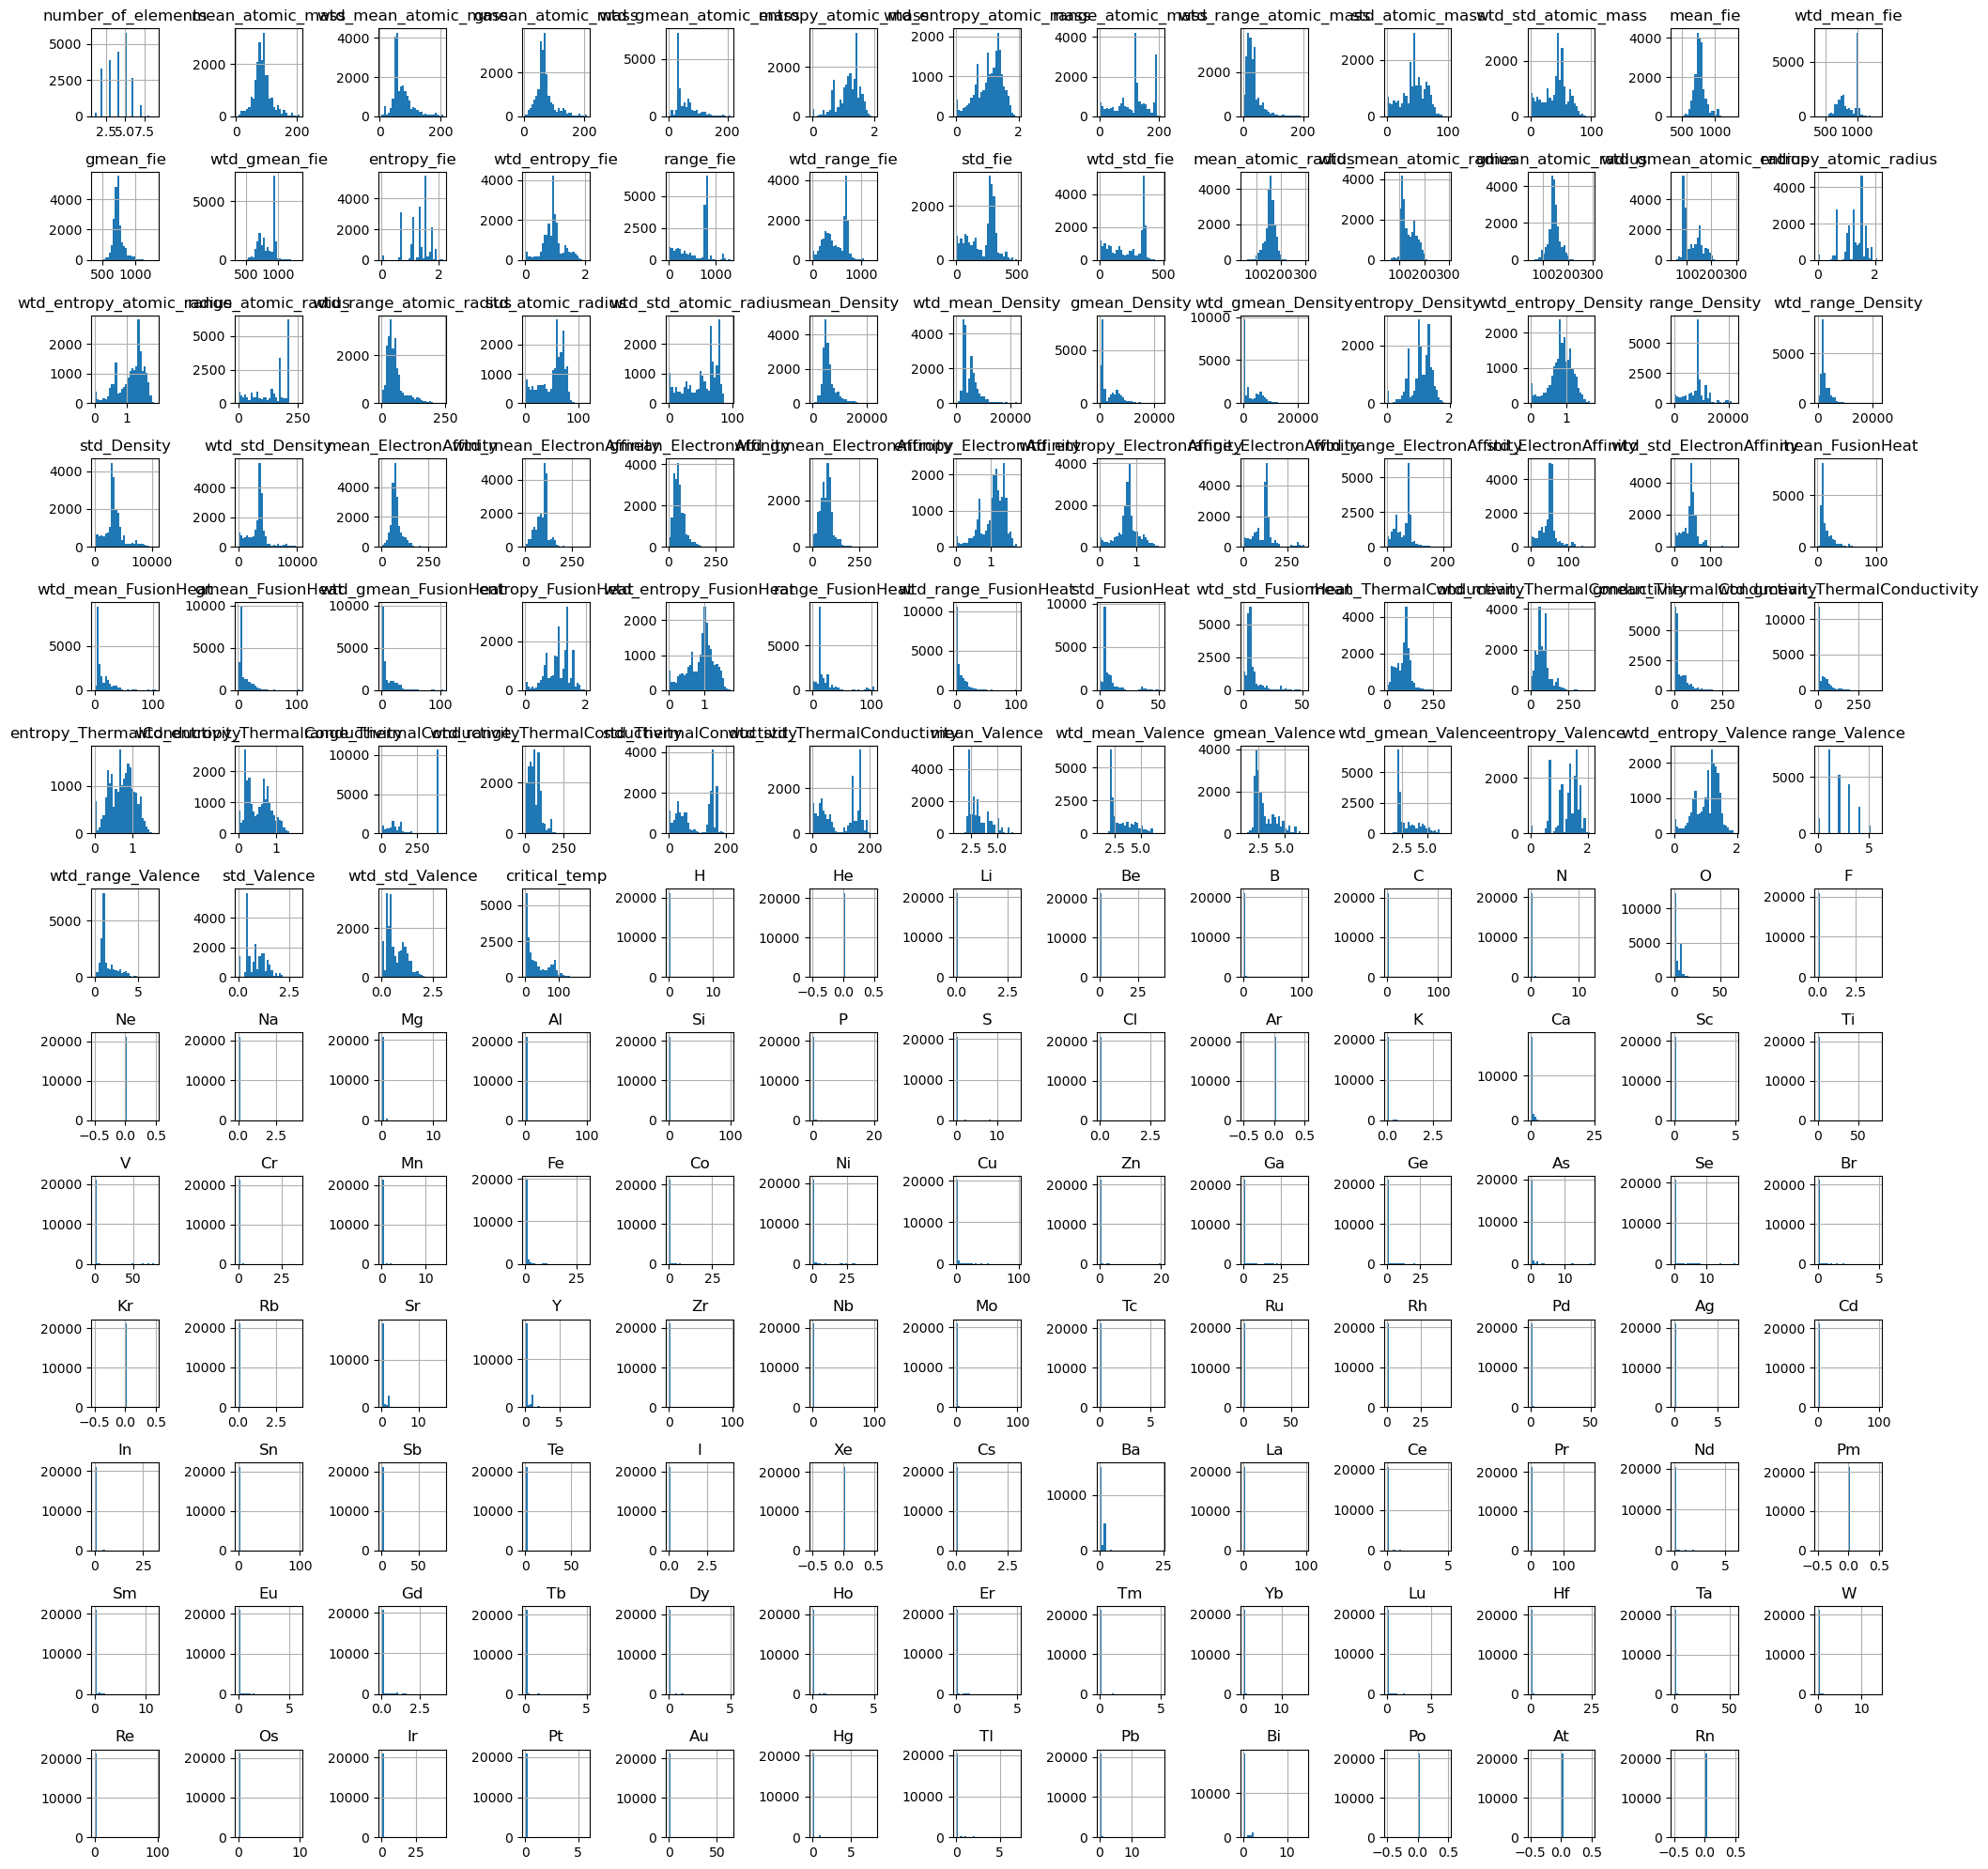

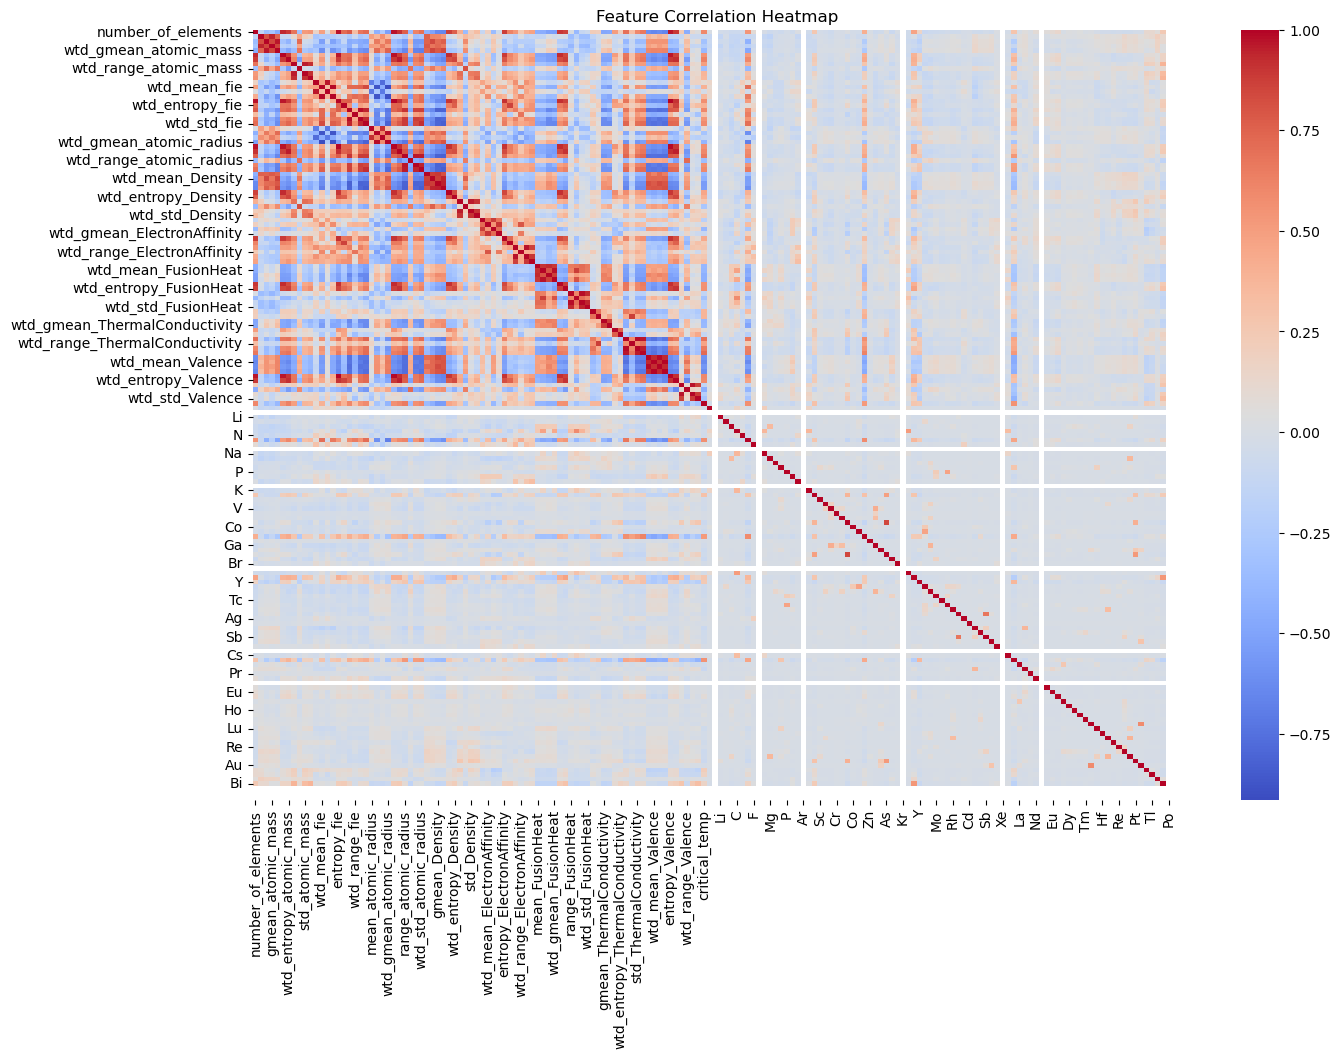

Training set size: (17010, 167), Testing set size: (4253, 167)
Linear Regression - MSE: 0.23240675202457944, R²: 0.7631058075354811


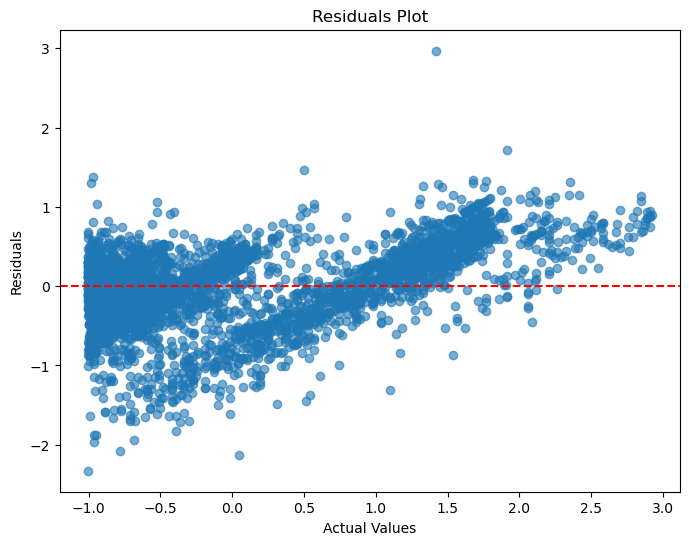

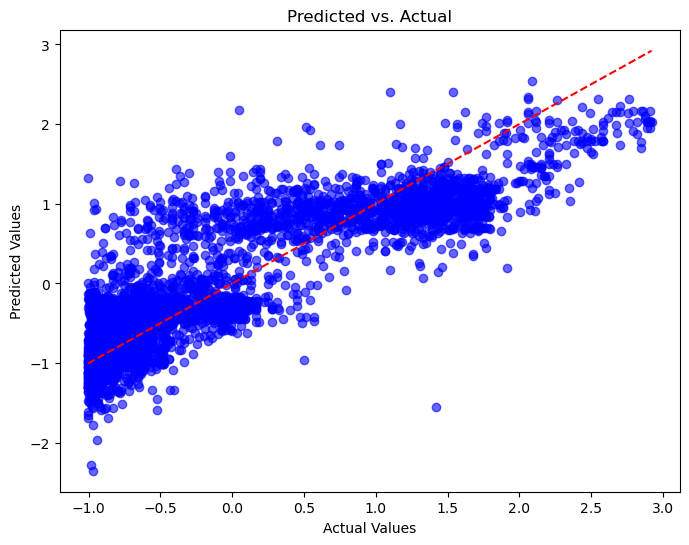

Linear Regression CV - Averaged MSE: 0.6825188361546444, Averaged R²: 0.31641407874038957
Best Lasso Alpha: 0.01, Best Lasso CV MSE: 0.2821884870485994
Best Ridge Alpha: 100, Best Ridge CV MSE: 0.3830706591484117
Lasso - MSE: 0.2559602604843477, R²: 0.7390975146710255
Ridge - MSE: 0.23489453325099344, R²: 0.7605699908282393


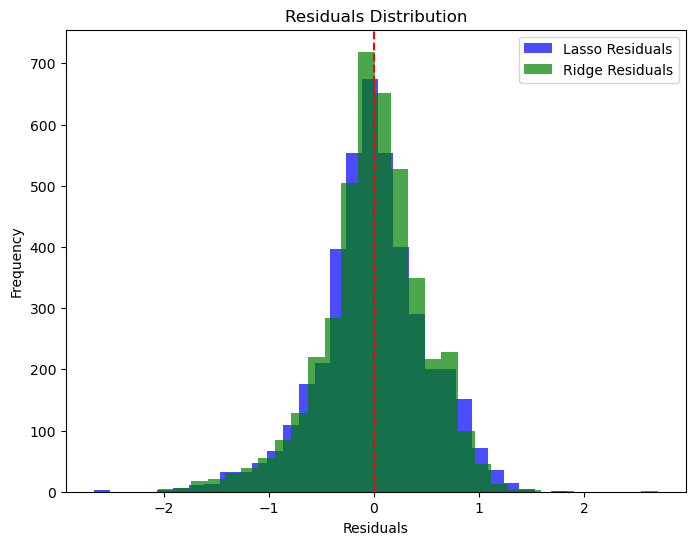

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
data = pd.read_csv('train.csv')
metadata = pd.read_csv('unique_m.csv')

# Merge datasets
data = pd.merge(data, metadata.drop(columns=['critical_temp', 'material']), left_index=True, right_index=True)

# Display basic dataset information
print(data.head())
print(metadata.head())
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Normalize the dataset
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
print(normalized_data.describe())

# Plot histograms
data.hist(figsize=(20, 20), bins=30)
plt.tight_layout()
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Define features and target
target_column = 'critical_temp'
X = normalized_data.drop(columns=[target_column])
y = normalized_data[target_column]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Linear Regression Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression - MSE: {mse}, R²: {r2}")

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted vs. Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Cross-validation for Linear Regression
cv_scores_mse = -cross_val_score(linear_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(linear_model, X_train, y_train, cv=10, scoring='r2')
print(f"Linear Regression CV - Averaged MSE: {cv_scores_mse.mean()}, Averaged R²: {cv_scores_r2.mean()}")

# Lasso Regression with GridSearch
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"Best Lasso Alpha: {lasso_grid.best_params_['alpha']}, Best Lasso CV MSE: {-lasso_grid.best_score_}")

# Ridge Regression with GridSearch
ridge = Ridge(max_iter=10000)
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge Alpha: {ridge_grid.best_params_['alpha']}, Best Ridge CV MSE: {-ridge_grid.best_score_}")

# Evaluate Lasso and Ridge Models
lasso_preds = best_lasso.predict(X_test)
ridge_preds = best_ridge.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"Lasso - MSE: {lasso_mse}, R²: {lasso_r2}")
print(f"Ridge - MSE: {ridge_mse}, R²: {ridge_r2}")

# Residuals Distribution Plot
plt.figure(figsize=(8, 6))
plt.hist(y_test - lasso_preds, bins=30, alpha=0.7, label='Lasso Residuals', color='blue')
plt.hist(y_test - ridge_preds, bins=30, alpha=0.7, label='Ridge Residuals', color='green')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()


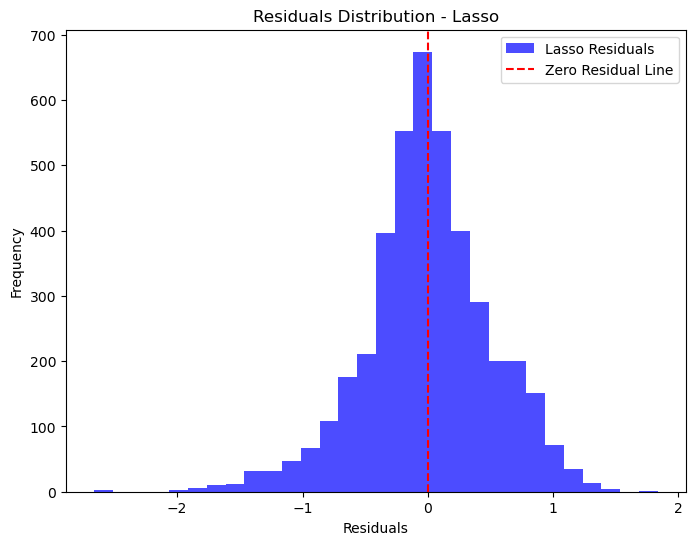

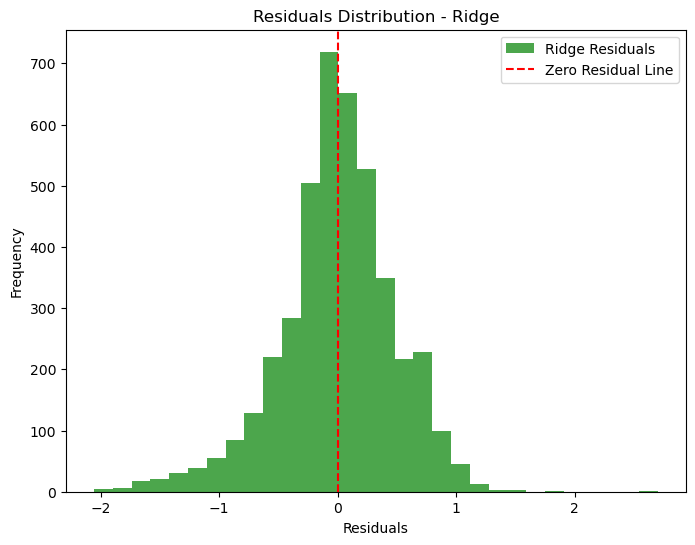

In [8]:
import matplotlib.pyplot as plt

# Residuals for Lasso
lasso_residuals = y_test - lasso_preds
plt.figure(figsize=(8, 6))
plt.hist(lasso_residuals, bins=30, alpha=0.7, color='blue', label='Lasso Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Residuals Distribution - Lasso")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Residuals for Ridge
ridge_residuals = y_test - ridge_preds
plt.figure(figsize=(8, 6))
plt.hist(ridge_residuals, bins=30, alpha=0.7, color='green', label='Ridge Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Residuals Distribution - Ridge")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [11]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Initialize model
linear_model = LinearRegression()

# K-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define scoring metrics
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(linear_model, normalized_data.drop(columns=["critical_temp"]), normalized_data["critical_temp"], 
                             cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(linear_model, normalized_data.drop(columns=["critical_temp"]), normalized_data["critical_temp"], 
                            cv=kf, scoring=r2_scorer)

# Report averaged scores
print("Cross-Validation Results:")
print(f"Averaged Mean Squared Error (MSE): {abs(np.mean(mse_scores)):.2f}")
print(f"Averaged R-squared (R²): {np.mean(r2_scores):.2f}")


Cross-Validation Results:
Averaged Mean Squared Error (MSE): 0.55
Averaged R-squared (R²): 0.45


In [12]:
# Define subsets of features to evaluate
feature_sets = {
    "Top 5 Features": ["wtd_std_ThermalConductivity", "range_ThermalConductivity", 
                       "range_atomic_radius", "std_ThermalConductivity", 
                       "wtd_entropy_atomic_mass"],
    "Top 10 Features": ["wtd_std_ThermalConductivity", "range_ThermalConductivity", 
                        "range_atomic_radius", "std_ThermalConductivity", 
                        "wtd_entropy_atomic_mass", "wtd_entropy_atomic_radius", 
                        "number_of_elements", "range_fie", 
                        "wtd_std_atomic_radius", "entropy_Valence"],
    "All Features": list(normalized_data.columns.drop("critical_temp")),
}

# Loop through each subset of features and evaluate performance
for set_name, features in feature_sets.items():
    # Extract features for this subset
    X = normalized_data[features]
    y = normalized_data["critical_temp"]
    
    # Perform cross-validation
    mse_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=r2_scorer)
    
    # Report results
    print(f"Ablation Study - {set_name}:")
    print(f"  Averaged MSE: {abs(np.mean(mse_scores)):.2f}")
    print(f"  Averaged R²: {np.mean(r2_scores):.2f}\n")


Ablation Study - Top 5 Features:
  Averaged MSE: 0.43
  Averaged R²: 0.57

Ablation Study - Top 10 Features:
  Averaged MSE: 0.41
  Averaged R²: 0.59

Ablation Study - All Features:
  Averaged MSE: 0.55
  Averaged R²: 0.45



In [16]:
selected_features = X_train.columns

# Lasso feature importance
lasso_coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': best_lasso.coef_
})
lasso_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Lasso Feature Importance:")
print(lasso_coefficients)

# Ridge feature importance
ridge_coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': best_ridge.coef_
})
ridge_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Ridge Feature Importance:")
print(ridge_coefficients)

# Residuals for Lasso and Ridge
lasso_residuals = y_test - lasso_preds
ridge_residuals = y_test - ridge_preds

# Cross-validation MSE and R² for Ridge
cv_scores_mse_ridge = -cross_val_score(best_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_scores_r2_ridge = cross_val_score(best_ridge, X_train, y_train, cv=10, scoring='r2')

from scipy.stats import shapiro

# Check residuals normality for Lasso
lasso_stat, lasso_p = shapiro(lasso_residuals)
print(f"Lasso Residuals Shapiro Test: Stat={lasso_stat}, p-value={lasso_p}")

# Check residuals normality for Ridge
ridge_stat, ridge_p = shapiro(ridge_residuals)
print(f"Ridge Residuals Shapiro Test: Stat={ridge_stat}, p-value={ridge_p}")


Lasso Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.320911
136                             Ba     0.247612
7                range_atomic_mass     0.156621
163                             Bi     0.110346
6          wtd_entropy_atomic_mass     0.091304
..                             ...          ...
94                              Si    -0.085685
44      wtd_gmean_ElectronAffinity    -0.086053
10             wtd_std_atomic_mass    -0.089348
80                 wtd_std_Valence    -0.113004
64   wtd_gmean_ThermalConductivity    -0.263837

[167 rows x 2 columns]
Ridge Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.410276
49            std_ElectronAffinity     0.346698
136                             Ba     0.243677
7                range_atomic_mass     0.221688
70     wtd_std_ThermalConductivity     0.208332
..                             ...          ...
29          

Lasso Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.320911
136                             Ba     0.247612
7                range_atomic_mass     0.156621
163                             Bi     0.110346
6          wtd_entropy_atomic_mass     0.091304
..                             ...          ...
94                              Si    -0.085685
44      wtd_gmean_ElectronAffinity    -0.086053
10             wtd_std_atomic_mass    -0.089348
80                 wtd_std_Valence    -0.113004
64   wtd_gmean_ThermalConductivity    -0.263837

[167 rows x 2 columns]
Ridge Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.410276
49            std_ElectronAffinity     0.346698
136                             Ba     0.243677
7                range_atomic_mass     0.221688
70     wtd_std_ThermalConductivity     0.208332
..                             ...          ...
29          

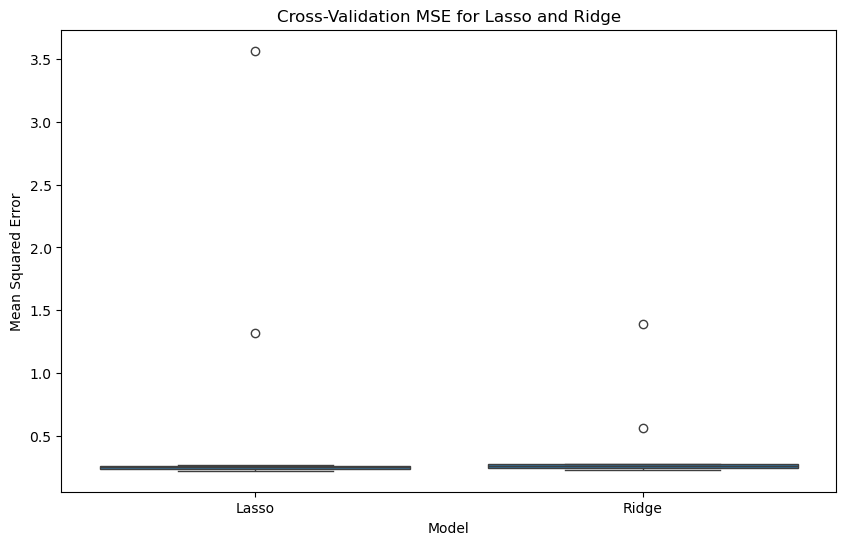

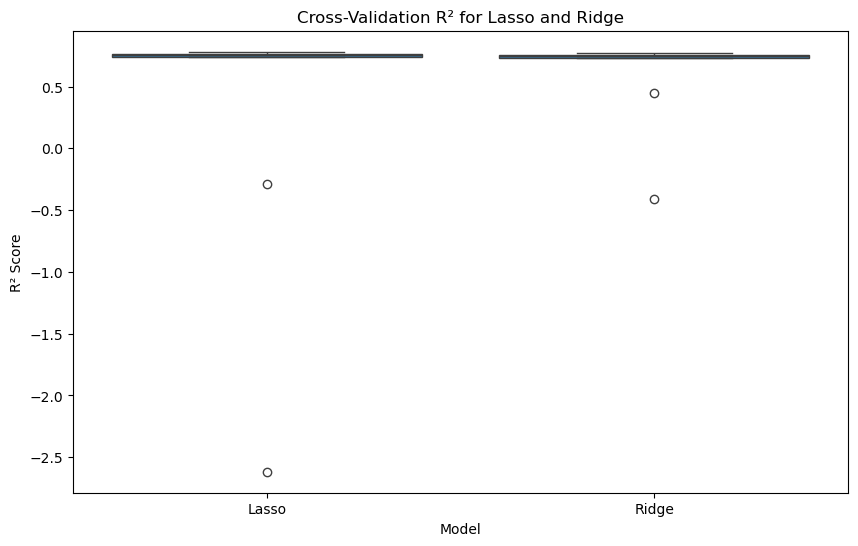

   Model       MSE        R²
0  Lasso  0.255960  0.739098
1  Ridge  0.234895  0.760570


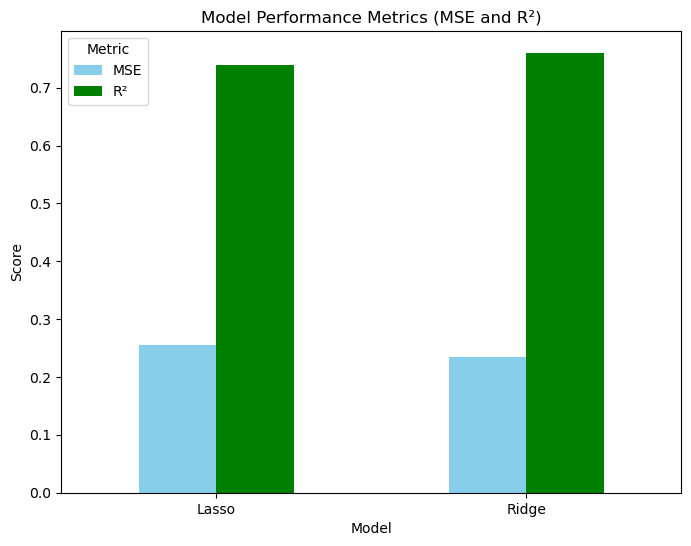

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, r2_score

# Feature names
selected_features = X_train.columns

# Lasso feature importance
lasso_coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': best_lasso.coef_})
lasso_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Lasso Feature Importance:")
print(lasso_coefficients)


# Ridge feature importance
ridge_coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': best_ridge.coef_})
ridge_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Ridge Feature Importance:")
print(ridge_coefficients)


# Residuals
lasso_residuals = y_test - lasso_preds
ridge_residuals = y_test - ridge_preds

# Shapiro test for residuals normality
lasso_stat, lasso_p = shapiro(lasso_residuals)
ridge_stat, ridge_p = shapiro(ridge_residuals)
print(f"Lasso Residuals Shapiro Test: Stat={lasso_stat}, p-value={lasso_p}")
print(f"Ridge Residuals Shapiro Test: Stat={ridge_stat}, p-value={ridge_p}")

# Cross-validation MSE and R² for Ridge
cv_scores_mse_ridge = -cross_val_score(best_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_scores_r2_ridge = cross_val_score(best_ridge, X_train, y_train, cv=10, scoring='r2')

# Combine Cross-validation Results
cv_results = pd.DataFrame({
    'Model': ['Lasso'] * 10 + ['Ridge'] * 10,
    'MSE': np.concatenate([cv_scores_mse, cv_scores_mse_ridge]),
    'R2': np.concatenate([cv_scores_r2, cv_scores_r2_ridge])
})

# Plot MSE across folds
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='MSE', data=cv_results)
plt.title("Cross-Validation MSE for Lasso and Ridge")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.show()

# Plot R² across folds
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R2', data=cv_results)
plt.title("Cross-Validation R² for Lasso and Ridge")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.show()

# Model performance metrics
mse_lasso = mean_squared_error(y_test, lasso_preds)
r2_lasso = r2_score(y_test, lasso_preds)
mse_ridge = mean_squared_error(y_test, ridge_preds)
r2_ridge = r2_score(y_test, ridge_preds)

metrics_summary = pd.DataFrame({
    'Model': ['Lasso', 'Ridge'],
    'MSE': [mse_lasso, mse_ridge],
    'R²': [r2_lasso, r2_ridge]
})
print(metrics_summary)

# Visualize metrics
metrics_summary.set_index('Model').plot(kind='bar', figsize=(8, 6), rot=0, color=['skyblue', 'green'])
plt.title("Model Performance Metrics (MSE and R²)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.show()


C:\Users\jessi\AppData\Local\Temp\ipykernel_6040\47124518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='Blues_r')


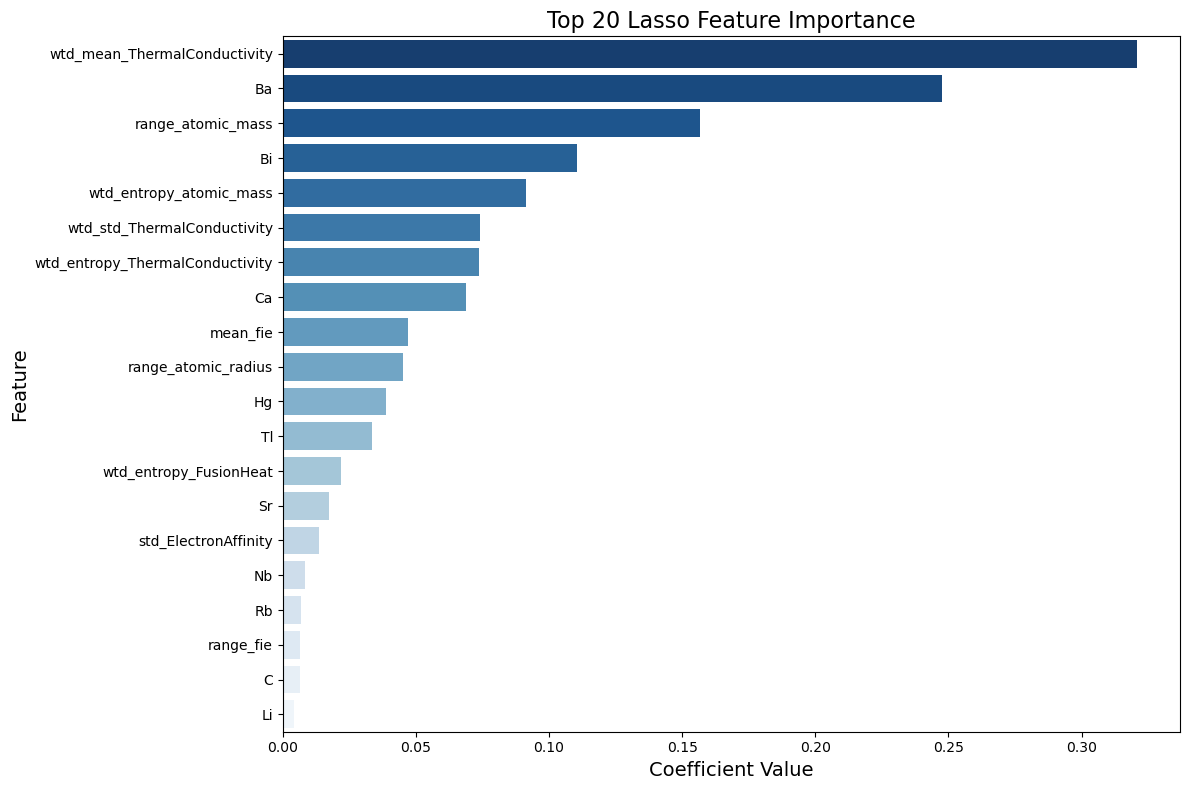

C:\Users\jessi\AppData\Local\Temp\ipykernel_6040\47124518.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features_ridge, palette='Greens_r')


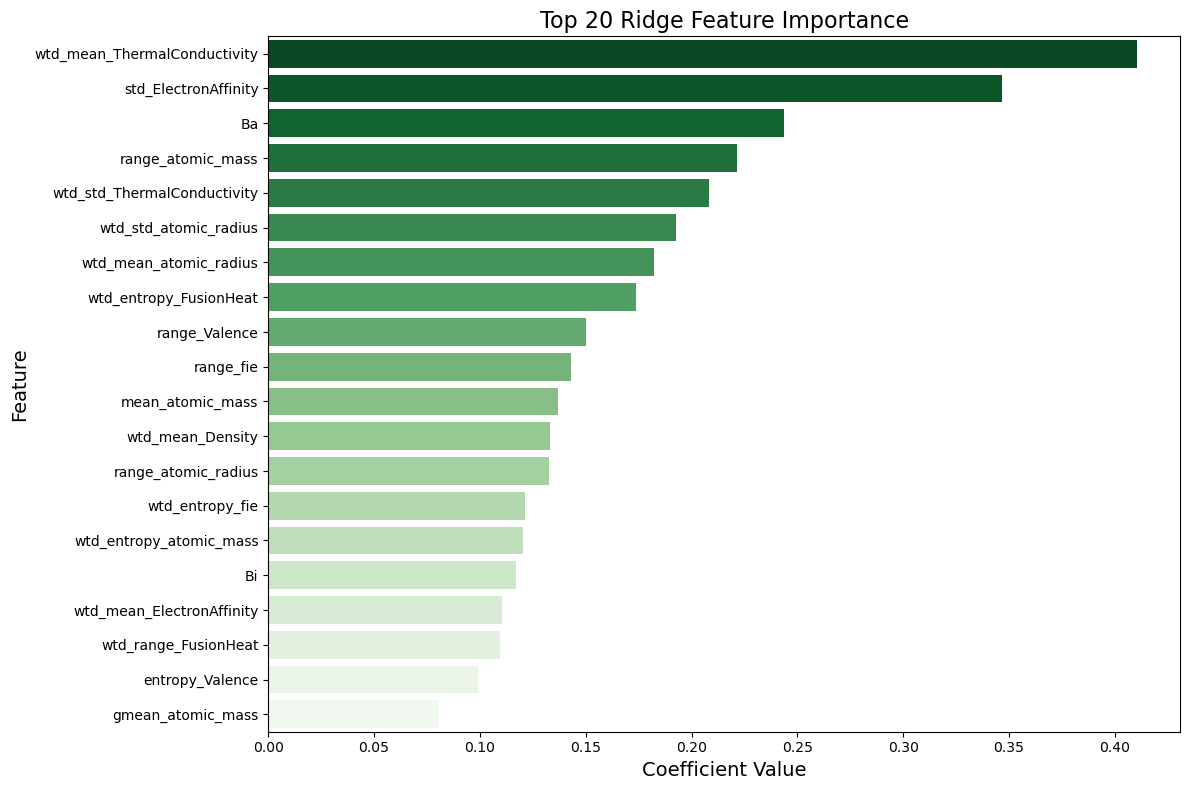

C:\Users\jessi\AppData\Local\Temp\ipykernel_6040\47124518.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='MSE', data=cv_results, showfliers=True, palette='coolwarm')


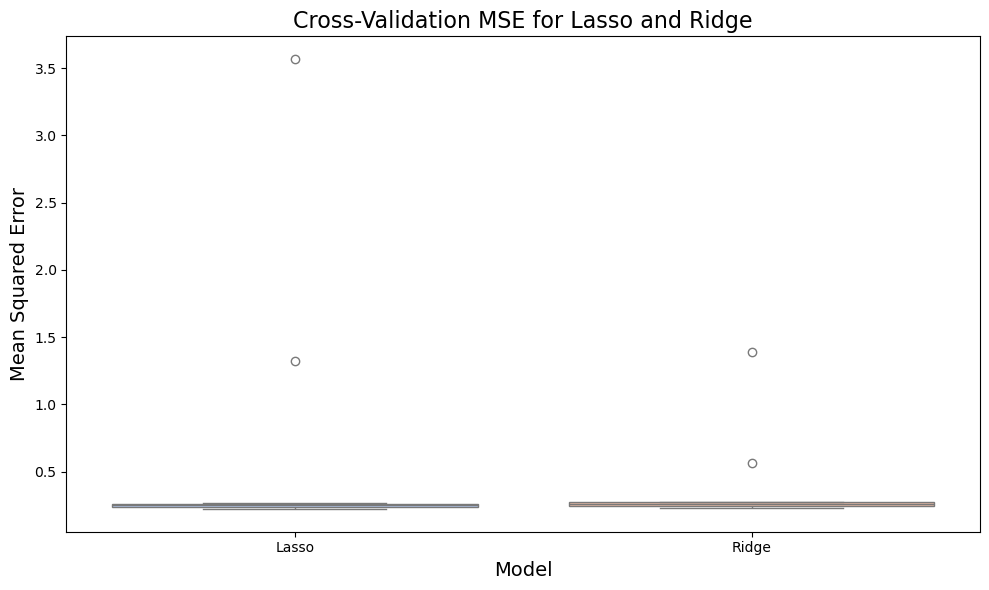

C:\Users\jessi\AppData\Local\Temp\ipykernel_6040\47124518.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='R2', data=cv_results, showfliers=True, palette='coolwarm')


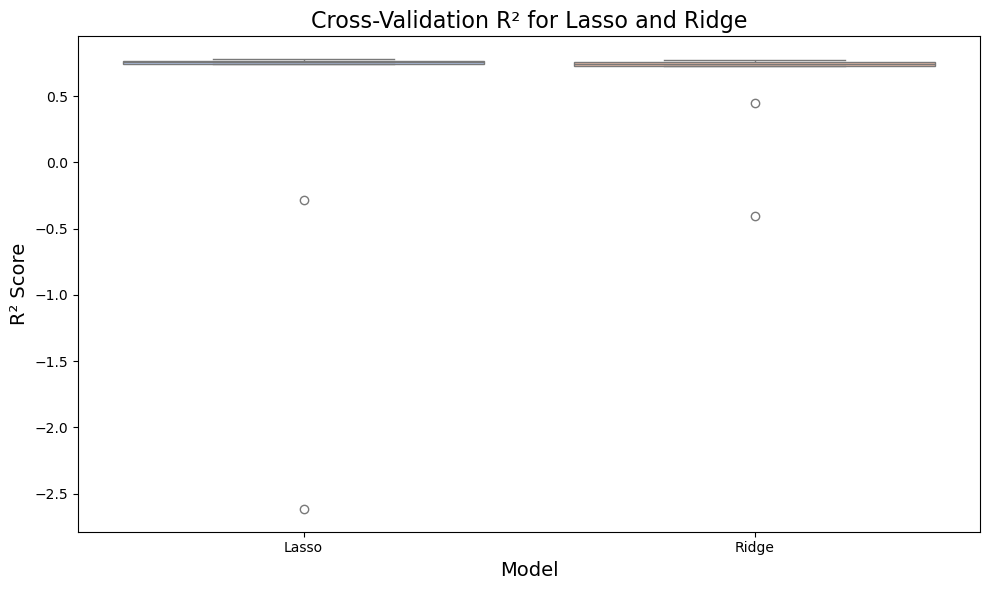

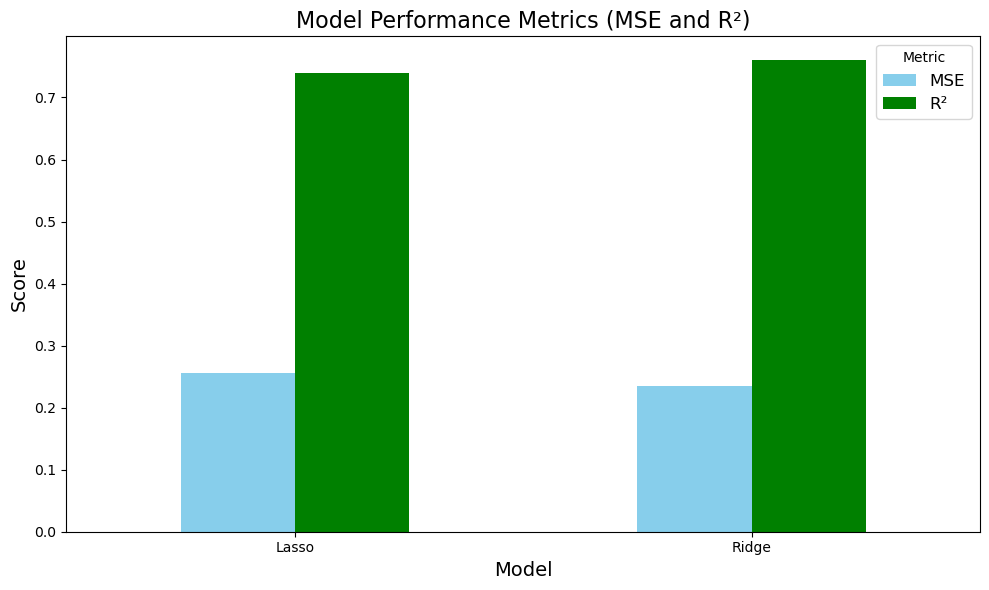

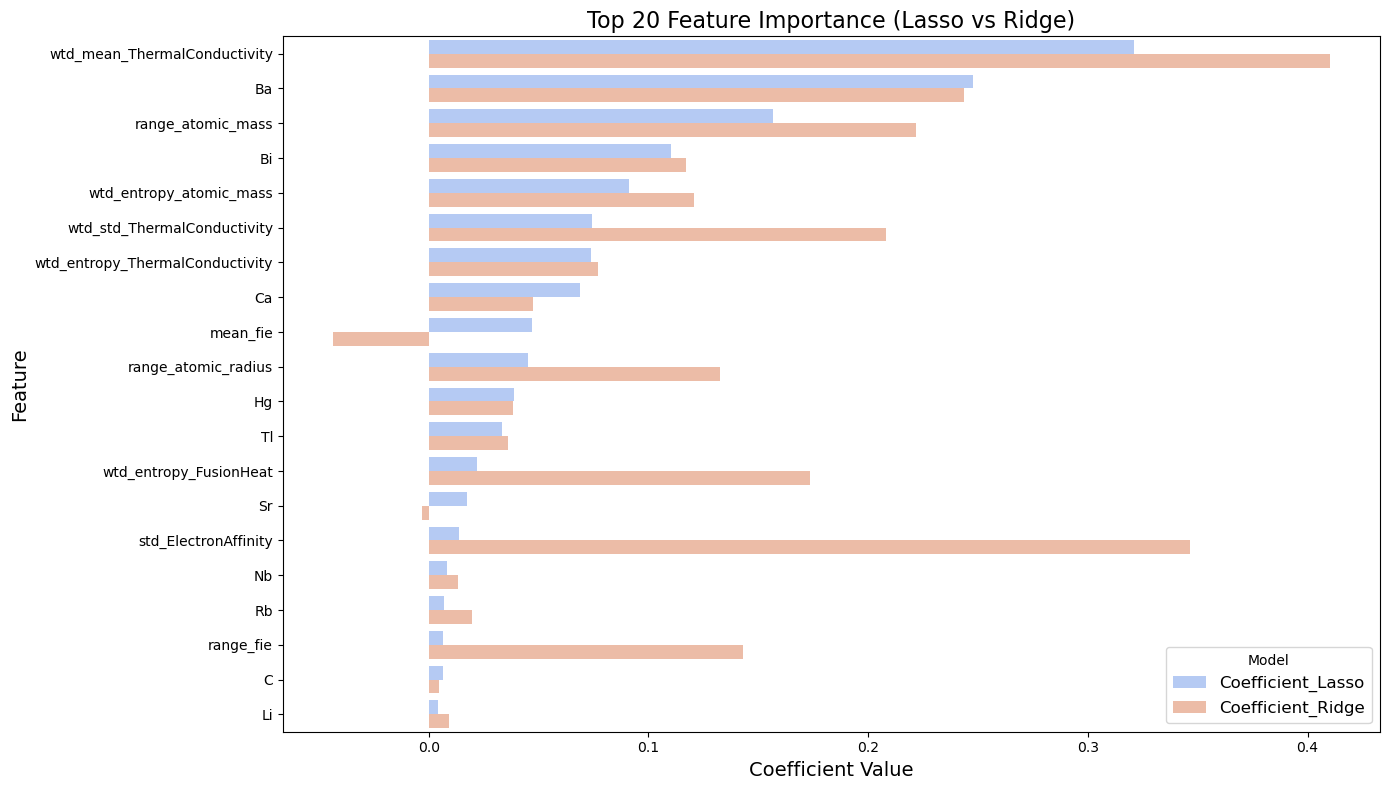

In [20]:
# Lasso feature importance - Top 20
top_features_lasso = lasso_coefficients.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='Blues_r')
plt.title("Top 20 Lasso Feature Importance", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

# Ridge feature importance - Top 20
top_features_ridge = ridge_coefficients.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features_ridge, palette='Greens_r')
plt.title("Top 20 Ridge Feature Importance", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

# Cross-validation MSE boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='MSE', data=cv_results, showfliers=True, palette='coolwarm')
plt.title("Cross-Validation MSE for Lasso and Ridge", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=14)
plt.tight_layout()
plt.show()

# Cross-validation R² boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R2', data=cv_results, showfliers=True, palette='coolwarm')
plt.title("Cross-Validation R² for Lasso and Ridge", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("R² Score", fontsize=14)
plt.tight_layout()
plt.show()

# Model Performance Metrics
metrics_summary.set_index('Model').plot(kind='bar', figsize=(10, 6), rot=0, color=['skyblue', 'green'])
plt.title("Model Performance Metrics (MSE and R²)", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.legend(title="Metric", fontsize=12)
plt.tight_layout()
plt.show()

# Combine Lasso and Ridge feature importance for comparison
combined_coefficients = pd.merge(
    lasso_coefficients.set_index('Feature'),
    ridge_coefficients.set_index('Feature'),
    how='inner',
    on='Feature',
    suffixes=('_Lasso', '_Ridge')
).reset_index()

# Plot comparison
plt.figure(figsize=(14, 8))
sns.barplot(data=combined_coefficients.head(20).melt(id_vars='Feature', var_name='Model', value_name='Coefficient'),
            x='Coefficient', y='Feature', hue='Model', palette='coolwarm')
plt.title("Top 20 Feature Importance (Lasso vs Ridge)", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.legend(title="Model", fontsize=12)
plt.tight_layout()
plt.show()


Lasso Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.320911
136                             Ba     0.247612
7                range_atomic_mass     0.156621
163                             Bi     0.110346
6          wtd_entropy_atomic_mass     0.091304
..                             ...          ...
94                              Si    -0.085685
44      wtd_gmean_ElectronAffinity    -0.086053
10             wtd_std_atomic_mass    -0.089348
80                 wtd_std_Valence    -0.113004
64   wtd_gmean_ThermalConductivity    -0.263837

[167 rows x 2 columns]
Ridge Feature Importance:
                           Feature  Coefficient
62    wtd_mean_ThermalConductivity     0.410276
49            std_ElectronAffinity     0.346698
136                             Ba     0.243677
7                range_atomic_mass     0.221688
70     wtd_std_ThermalConductivity     0.208332
..                             ...          ...
29          

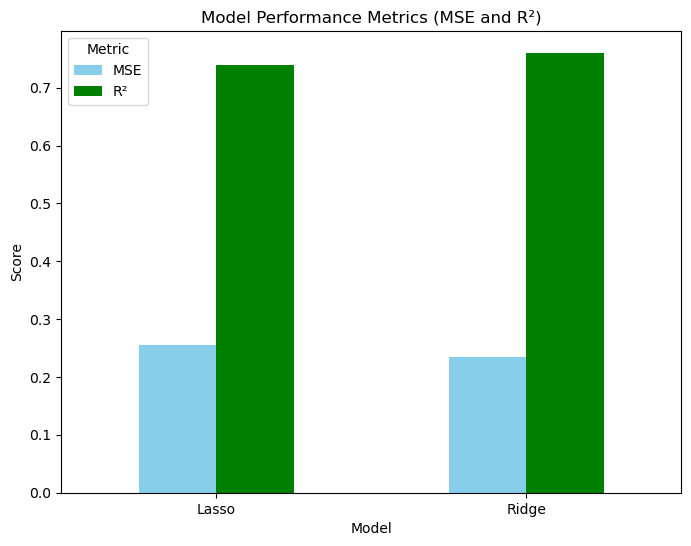

In [24]:
# interpretation of feature inportance


import numpy as np

# Lasso feature importance
lasso_coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': best_lasso.coef_})
lasso_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Lasso Feature Importance:")
print(lasso_coefficients)



# Ridge feature importance
ridge_coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': best_ridge.coef_})
ridge_coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
print("Ridge Feature Importance:")
print(ridge_coefficients)



# cross vaslidation  results visualized

# Cross-validation MSE for Lasso and Ridge
cv_results = pd.DataFrame({
    'Model': ['Lasso'] * 10 + ['Ridge'] * 10,
    'MSE': np.concatenate([cv_scores_mse, cv_scores_mse_ridge]),
    'R2': np.concatenate([cv_scores_r2, cv_scores_r2_ridge])
})



# residulas normalityu check

from scipy.stats import shapiro

# Check residuals normality for Lasso
lasso_stat, lasso_p = shapiro(lasso_residuals)
print(f"Lasso Residuals Shapiro Test: Stat={lasso_stat}, p-value={lasso_p}")

# Check residuals normality for Ridge
ridge_stat, ridge_p = shapiro(ridge_residuals)
print(f"Ridge Residuals Shapiro Test: Stat={ridge_stat}, p-value={ridge_p}")


# Calculate Mean Squared Error (MSE) and R² for Lasso and Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Lasso performance
mse_lasso = mean_squared_error(y_test, lasso_preds)
r2_lasso = r2_score(y_test, lasso_preds)

# Ridge performance
mse_ridge = mean_squared_error(y_test, ridge_preds)
r2_ridge = r2_score(y_test, ridge_preds)

# Create the summary table
metrics_summary = pd.DataFrame({
    'Model': ['Lasso', 'Ridge'],
    'MSE': [mse_lasso, mse_ridge],
    'R²': [r2_lasso, r2_ridge]
})
print(metrics_summary)

# Visualize metrics
metrics_summary.set_index('Model').plot(kind='bar', figsize=(8, 6), rot=0, color=['skyblue', 'green'])
plt.title("Model Performance Metrics (MSE and R²)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 168 entries, number_of_elements to Rn
dtypes: float64(156), int64(12)
memory usage: 27.3 MB
None
       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916     

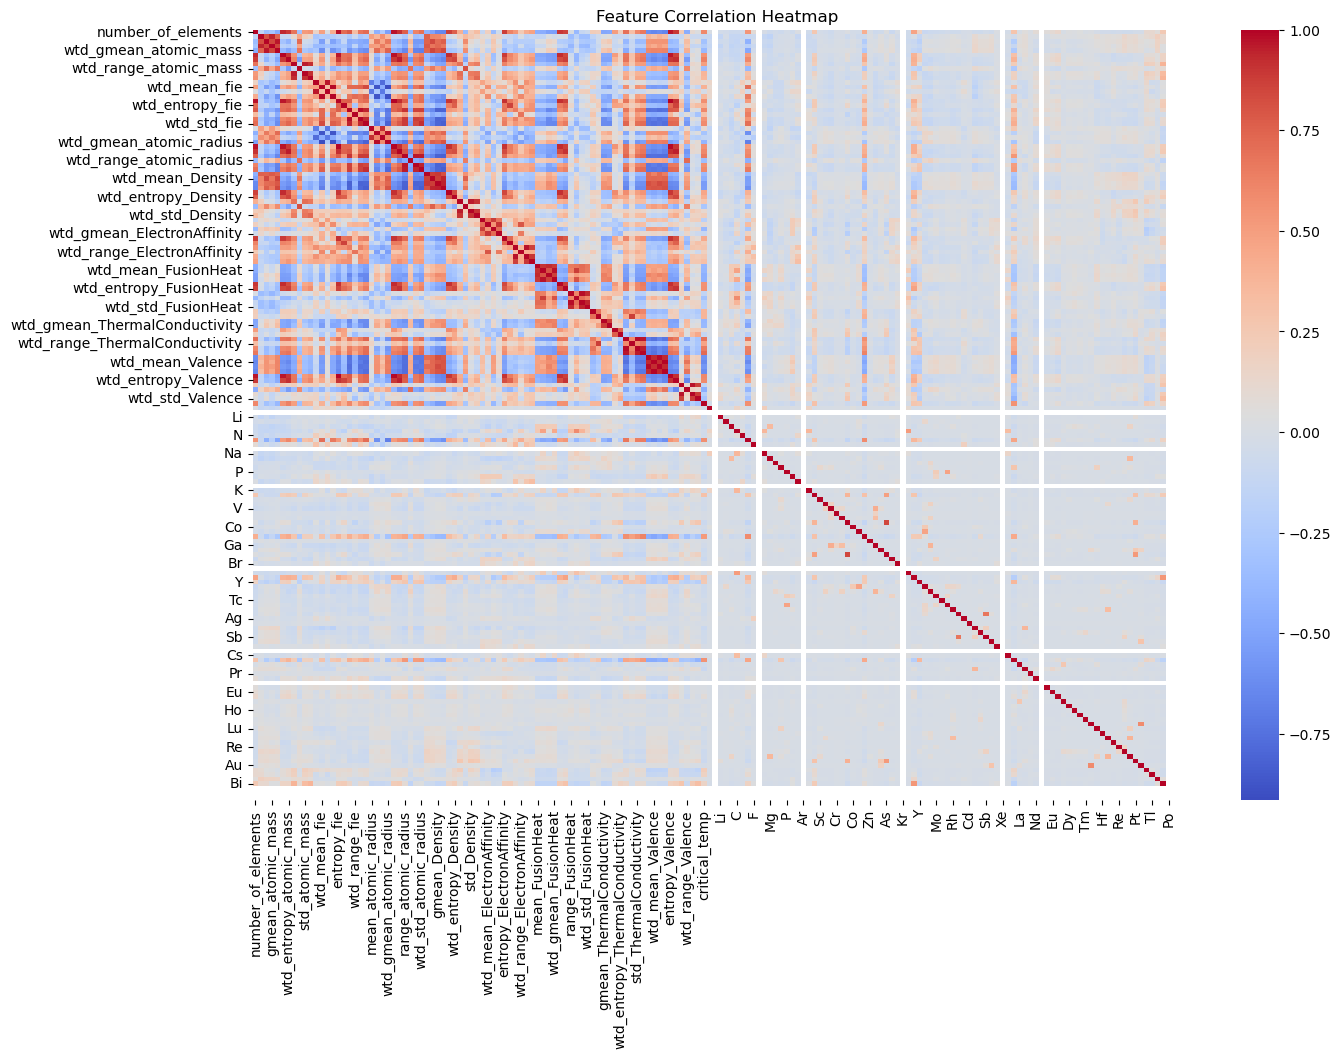

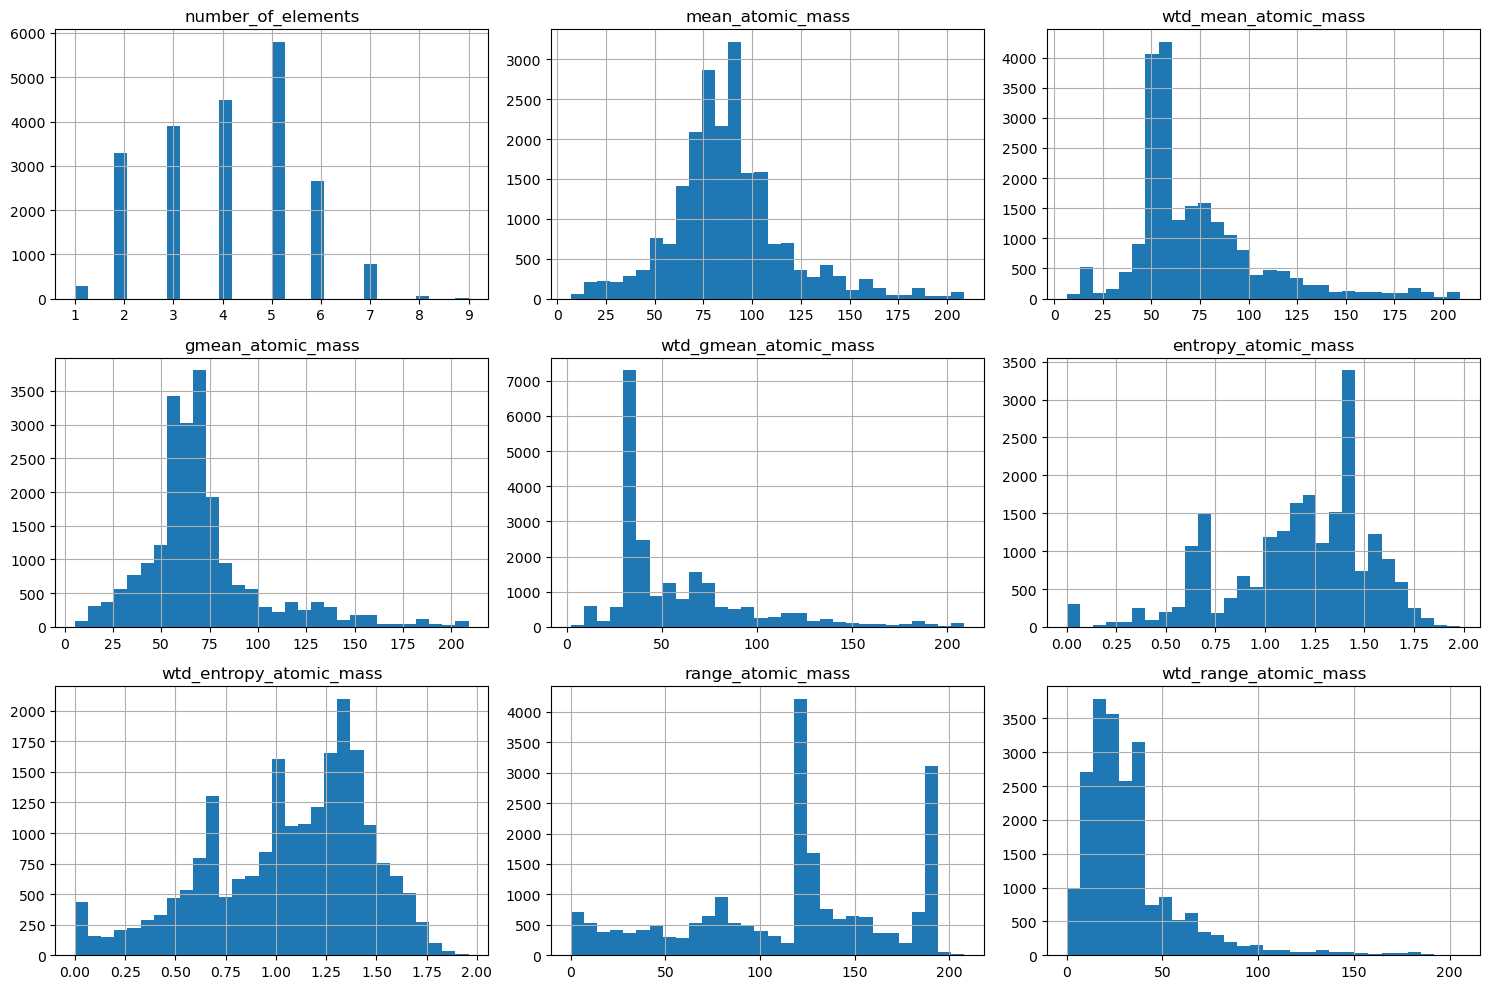

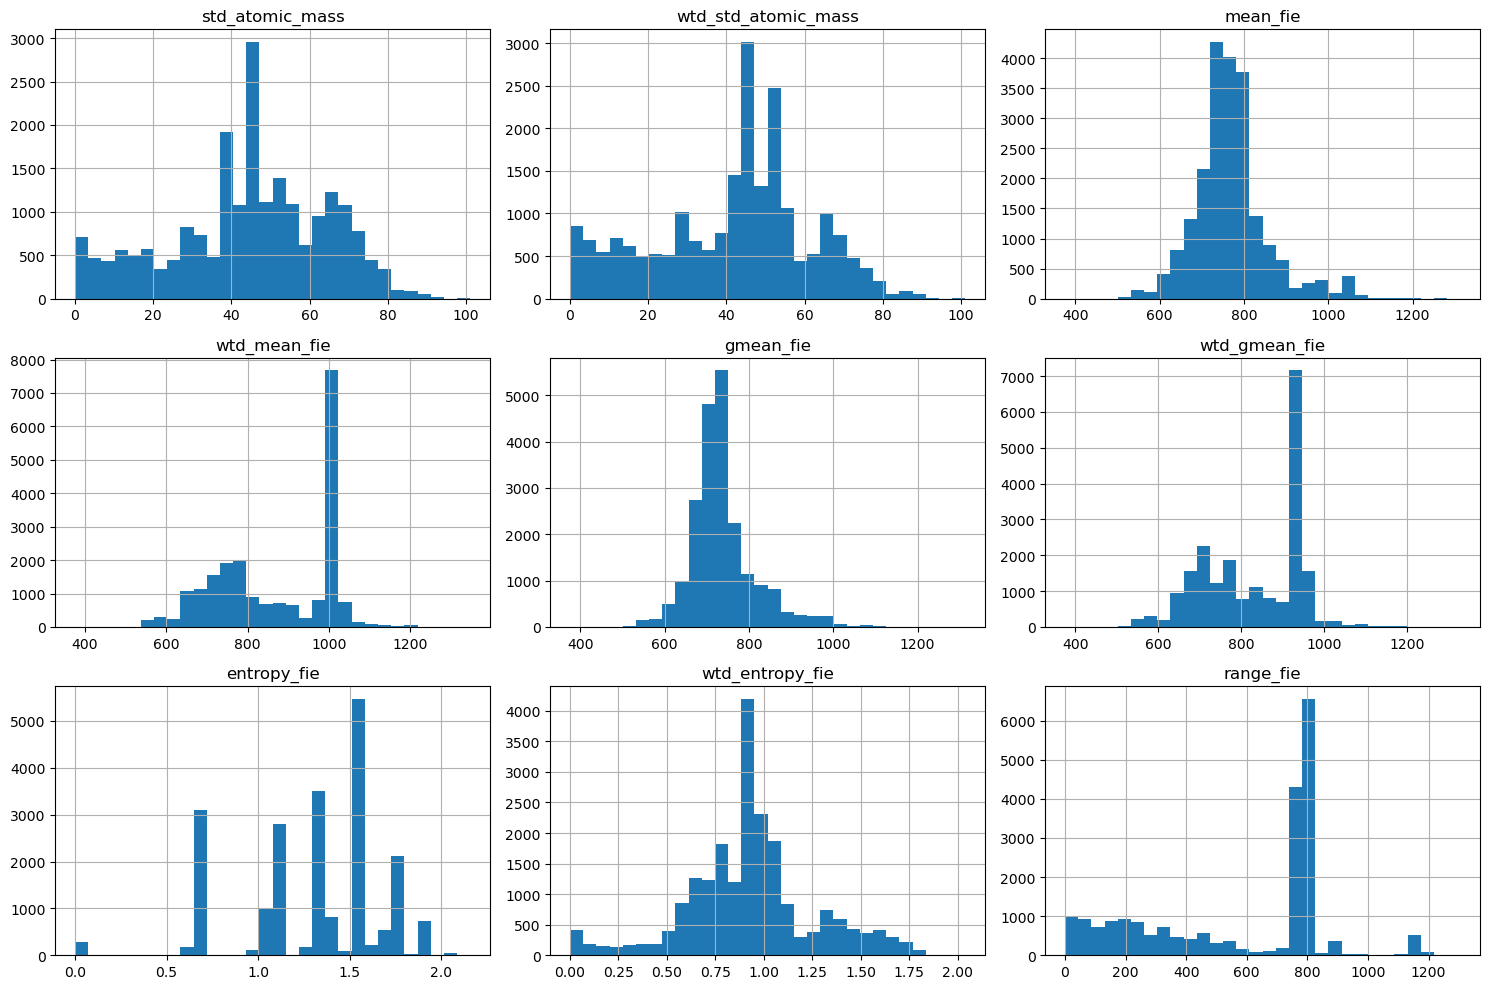

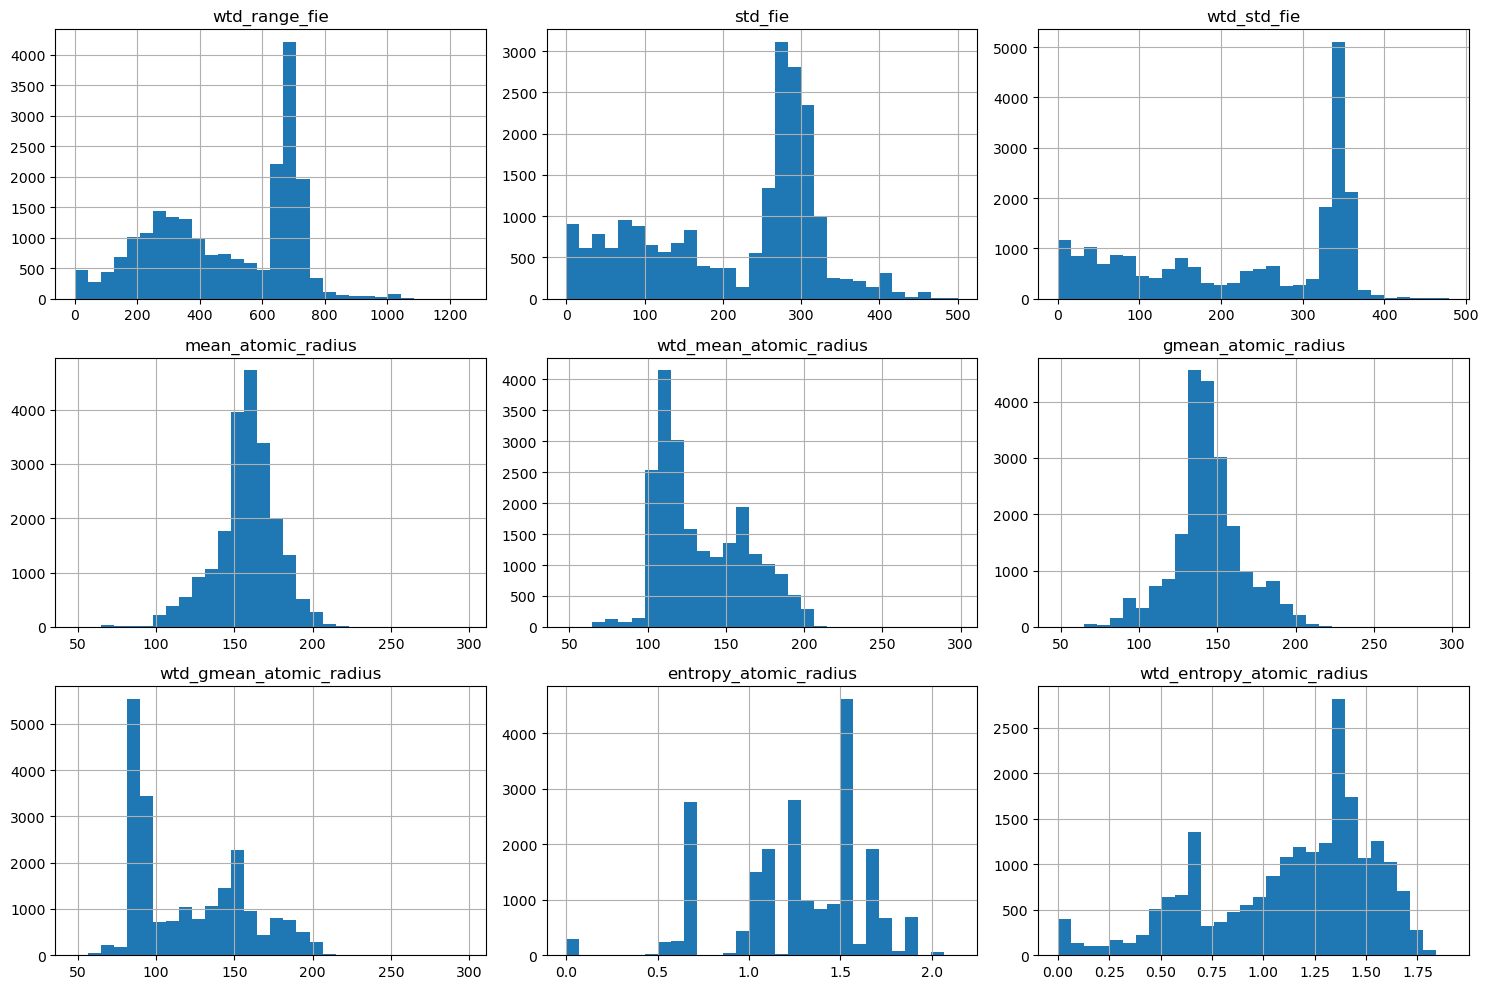

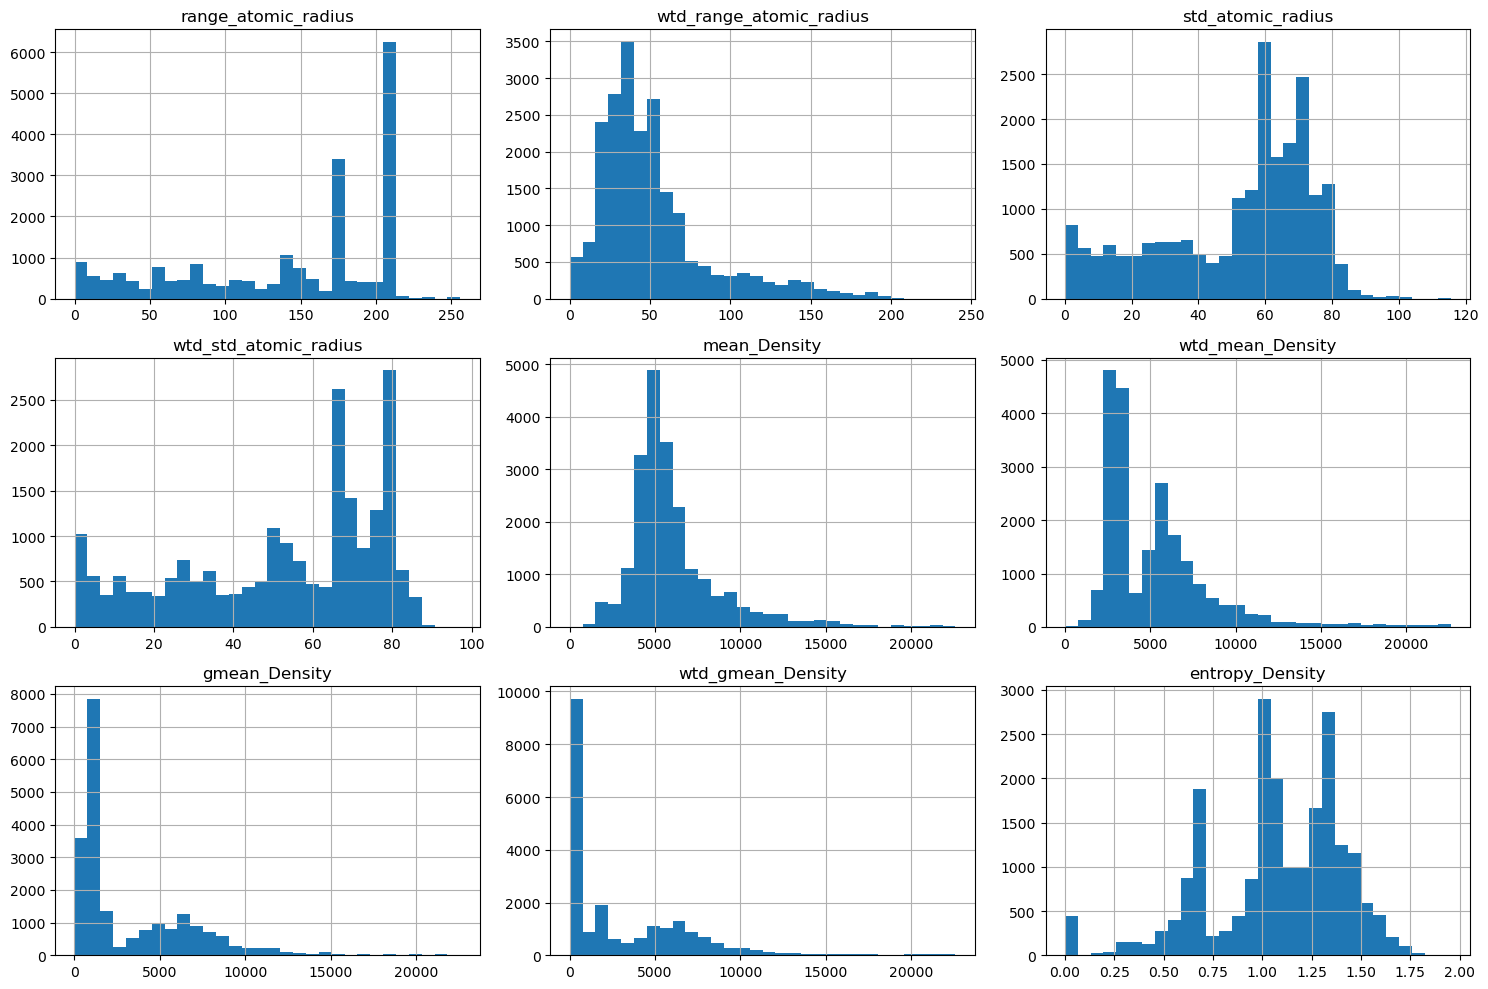

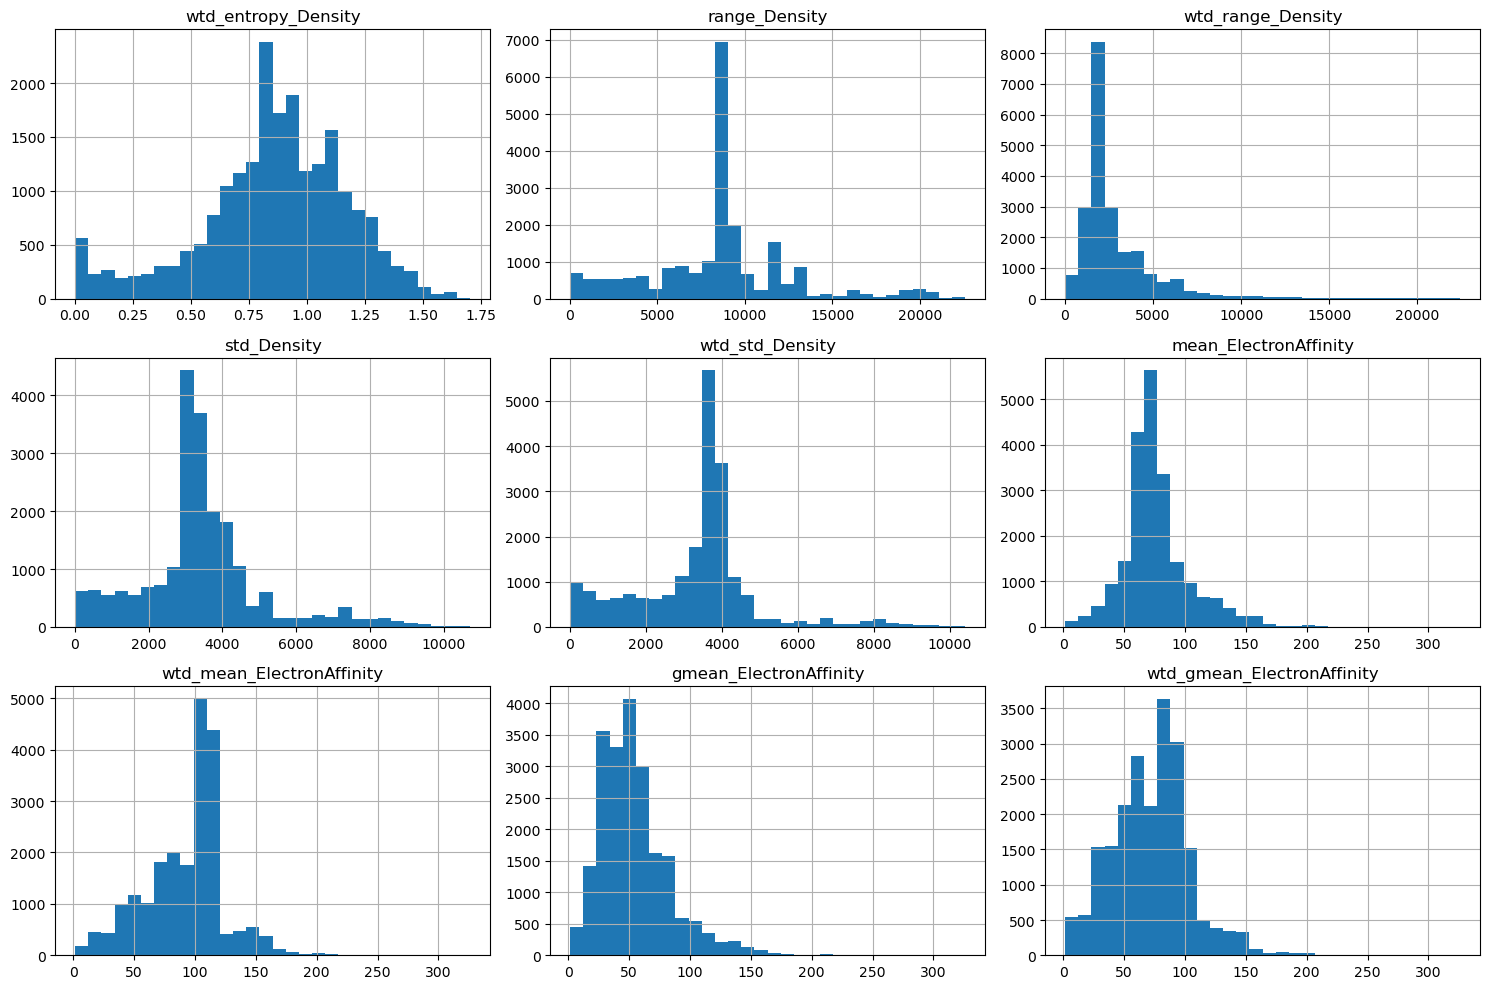

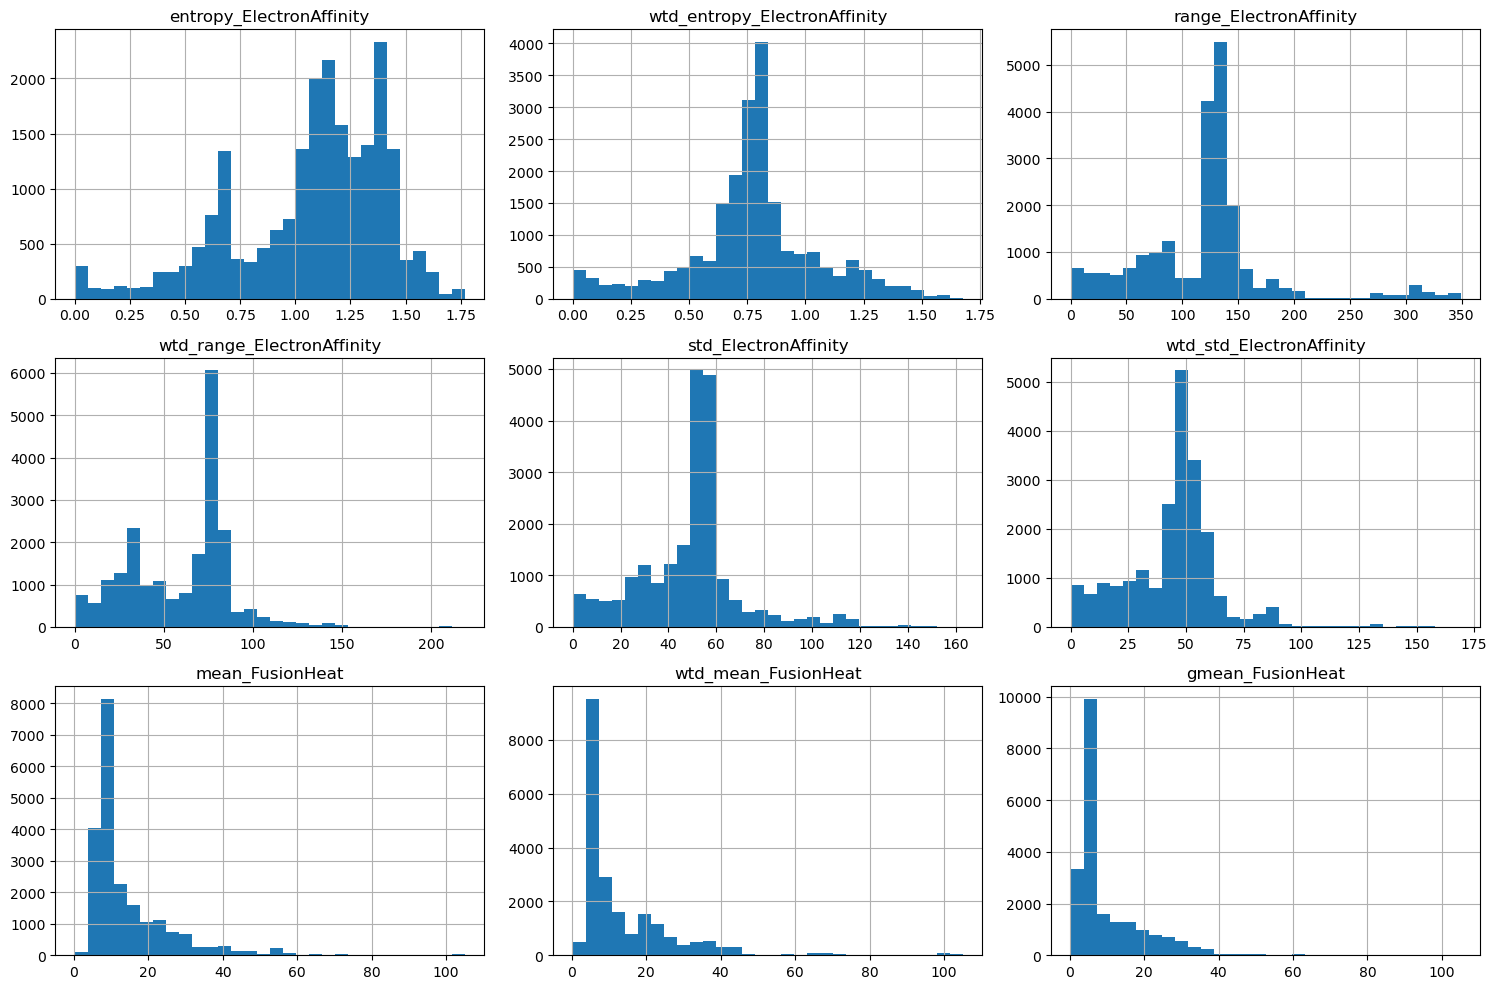

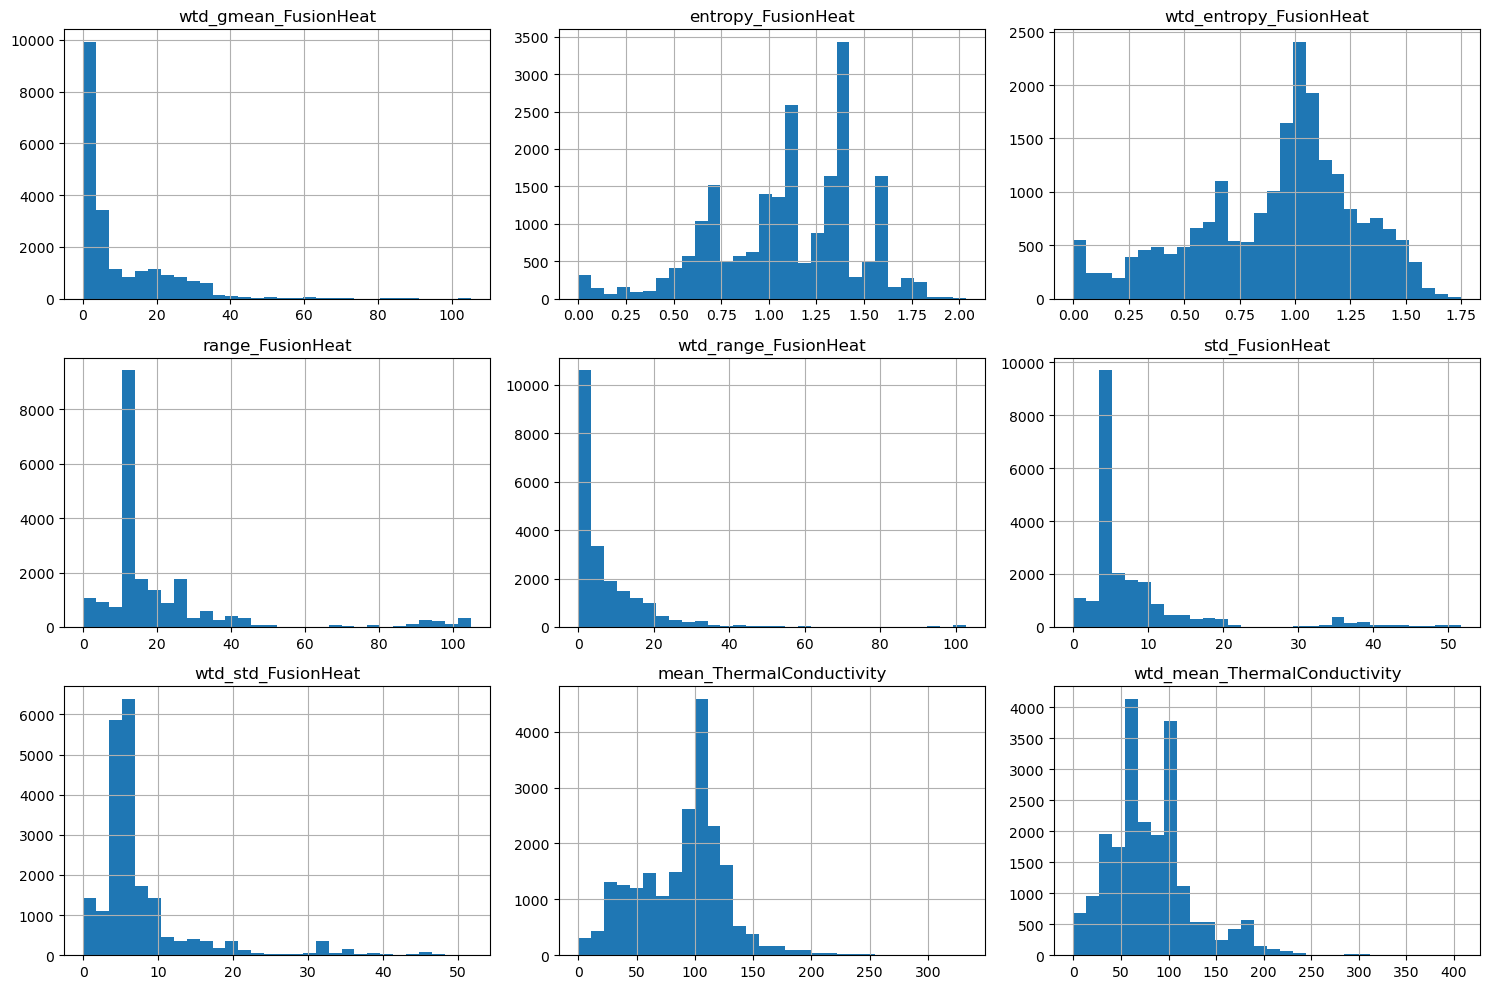

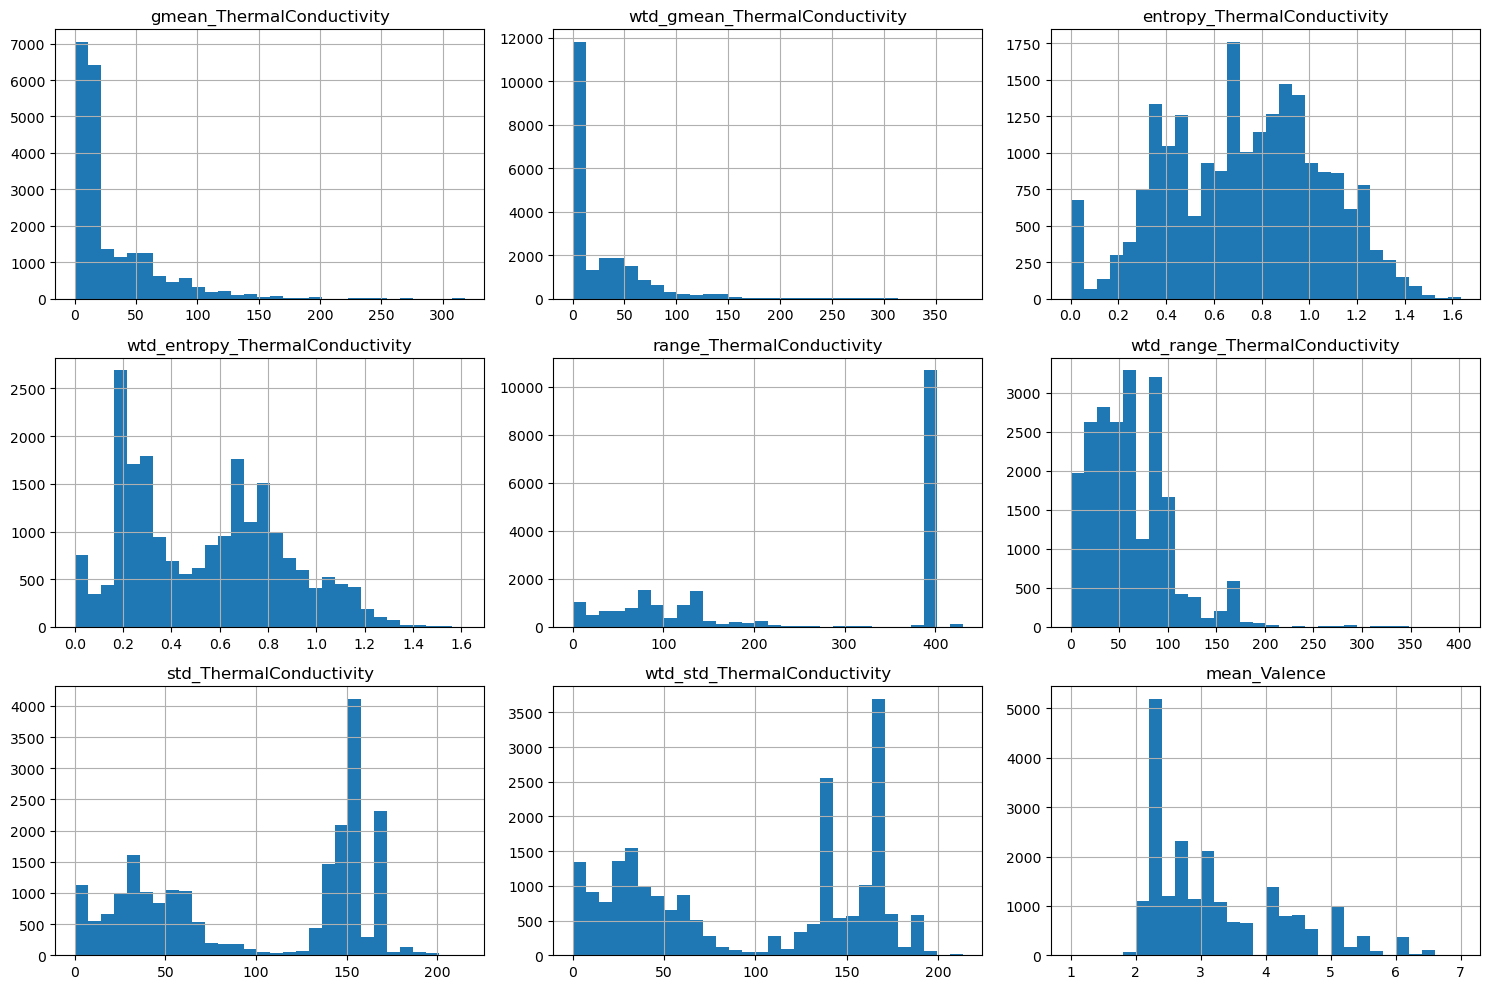

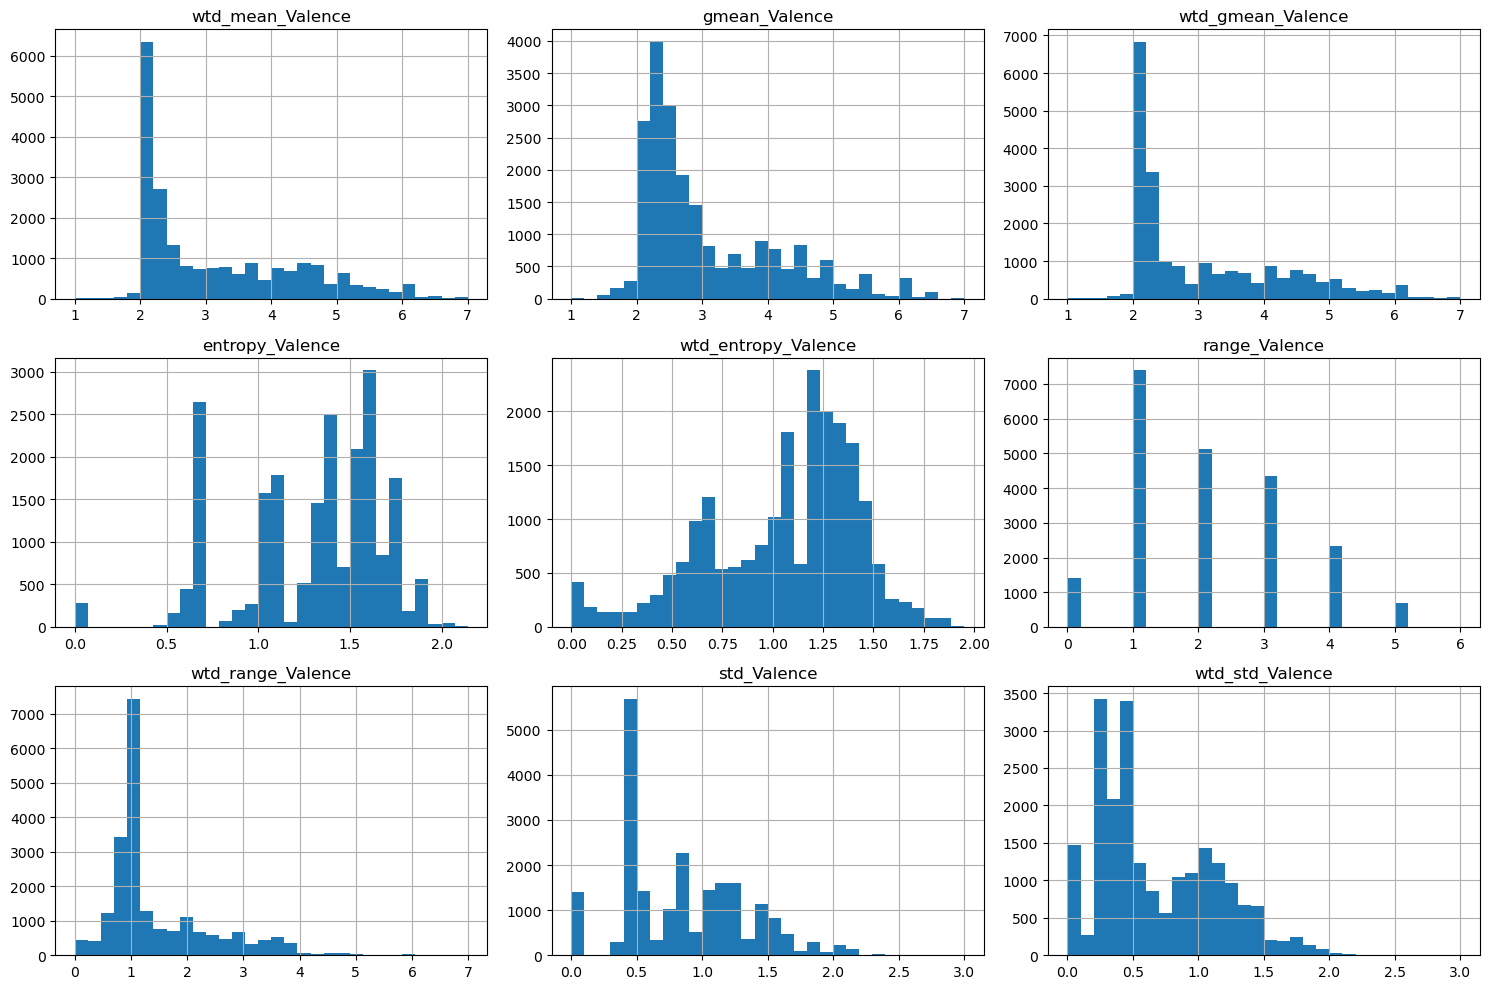

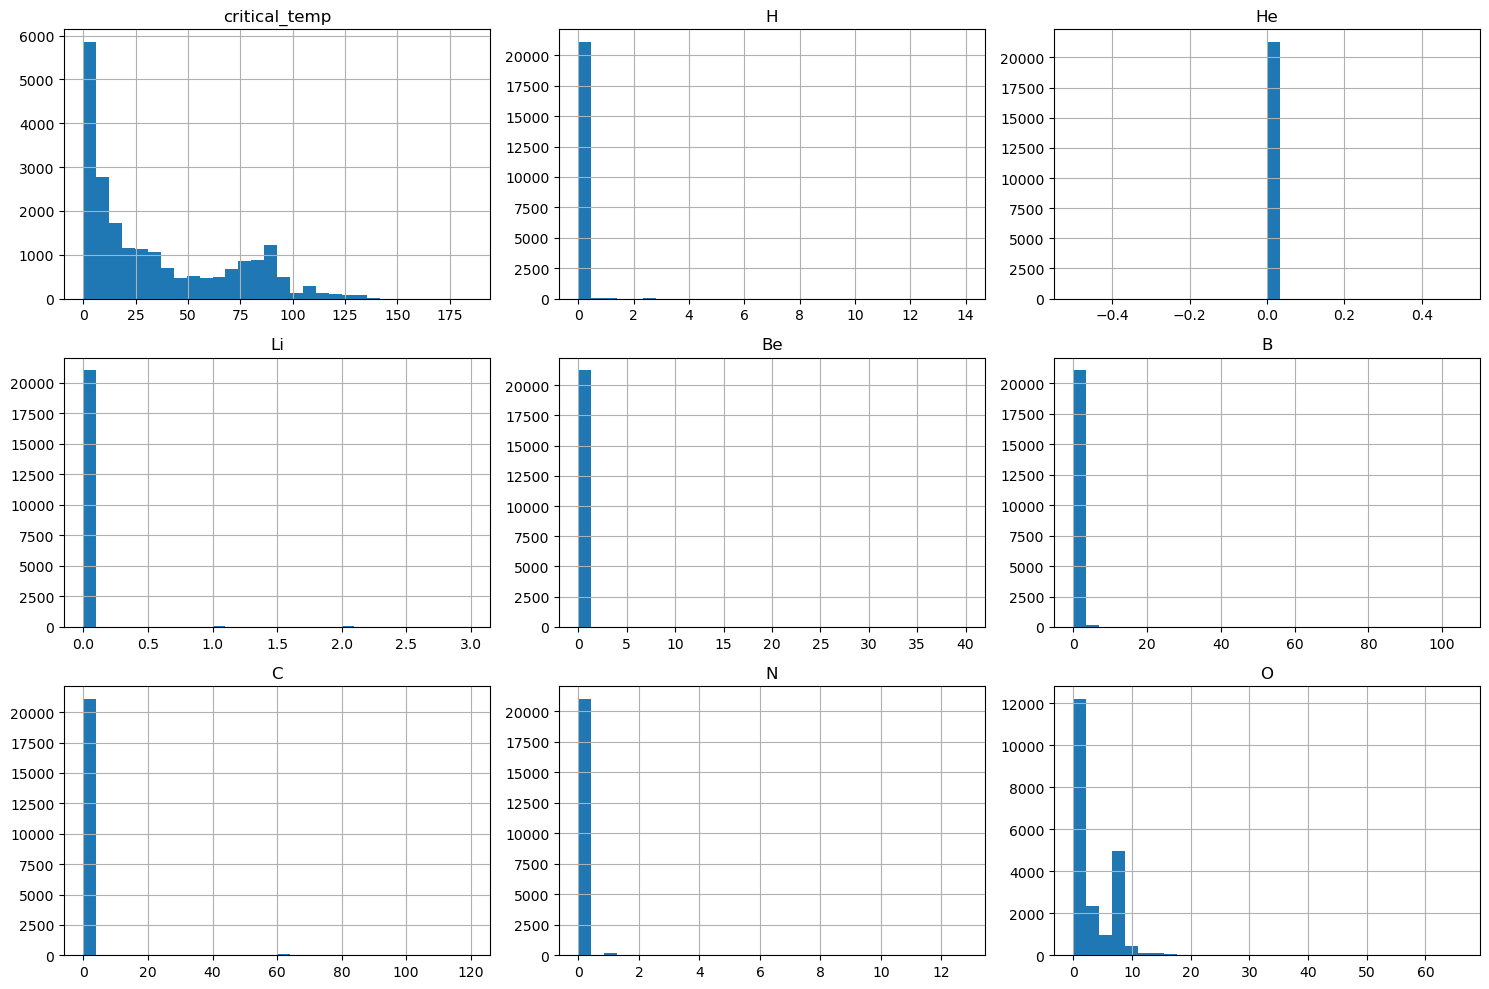

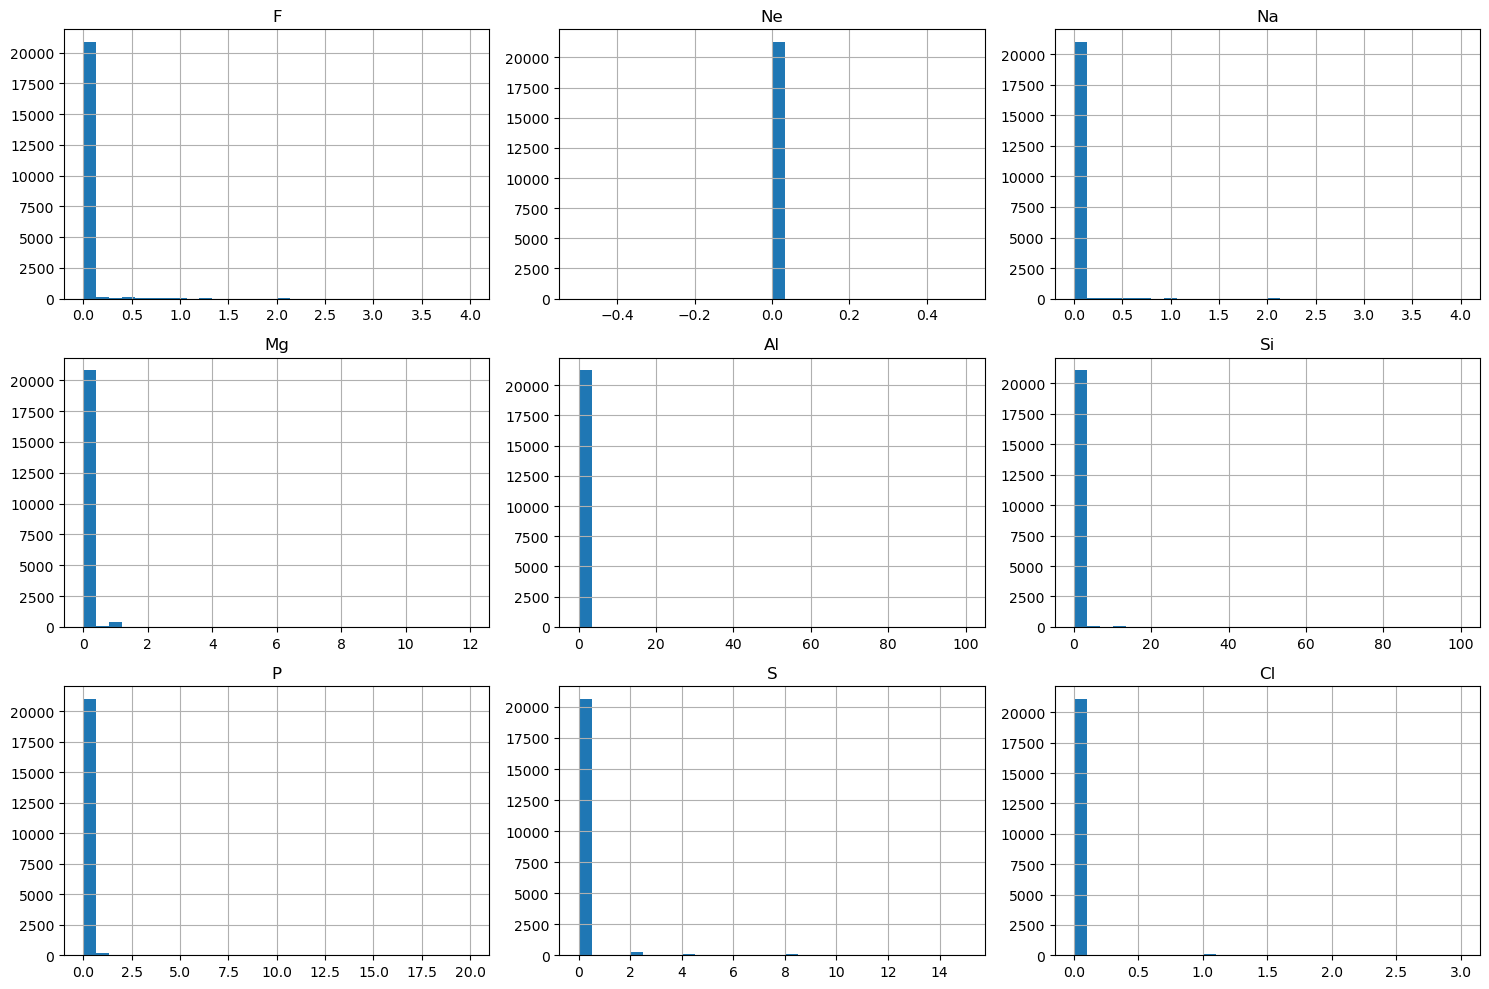

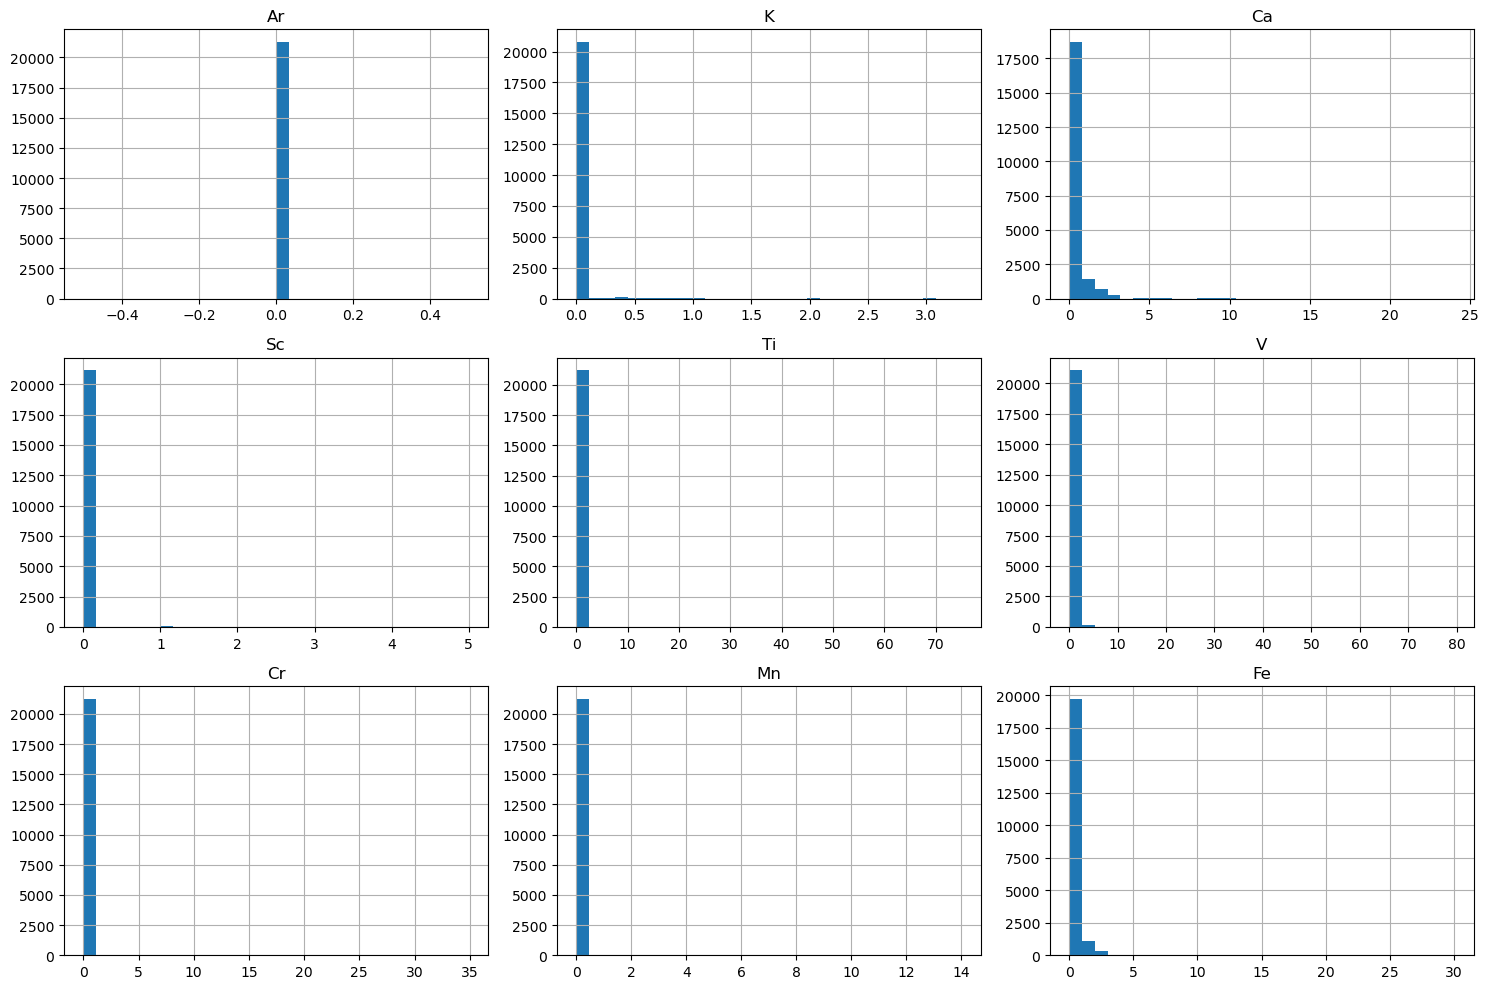

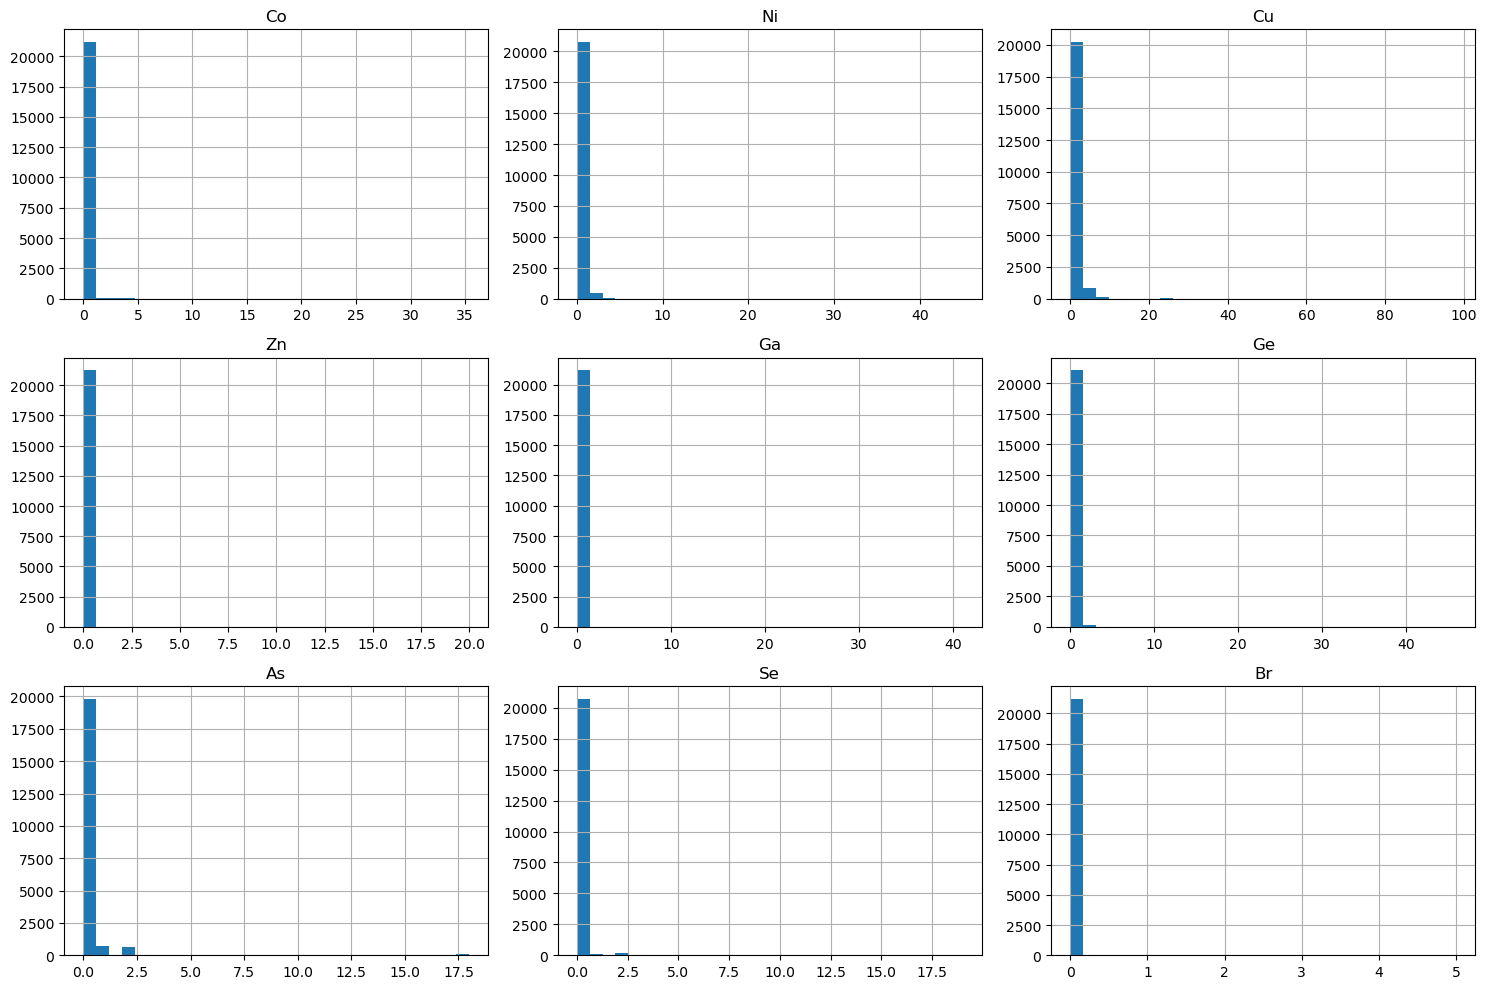

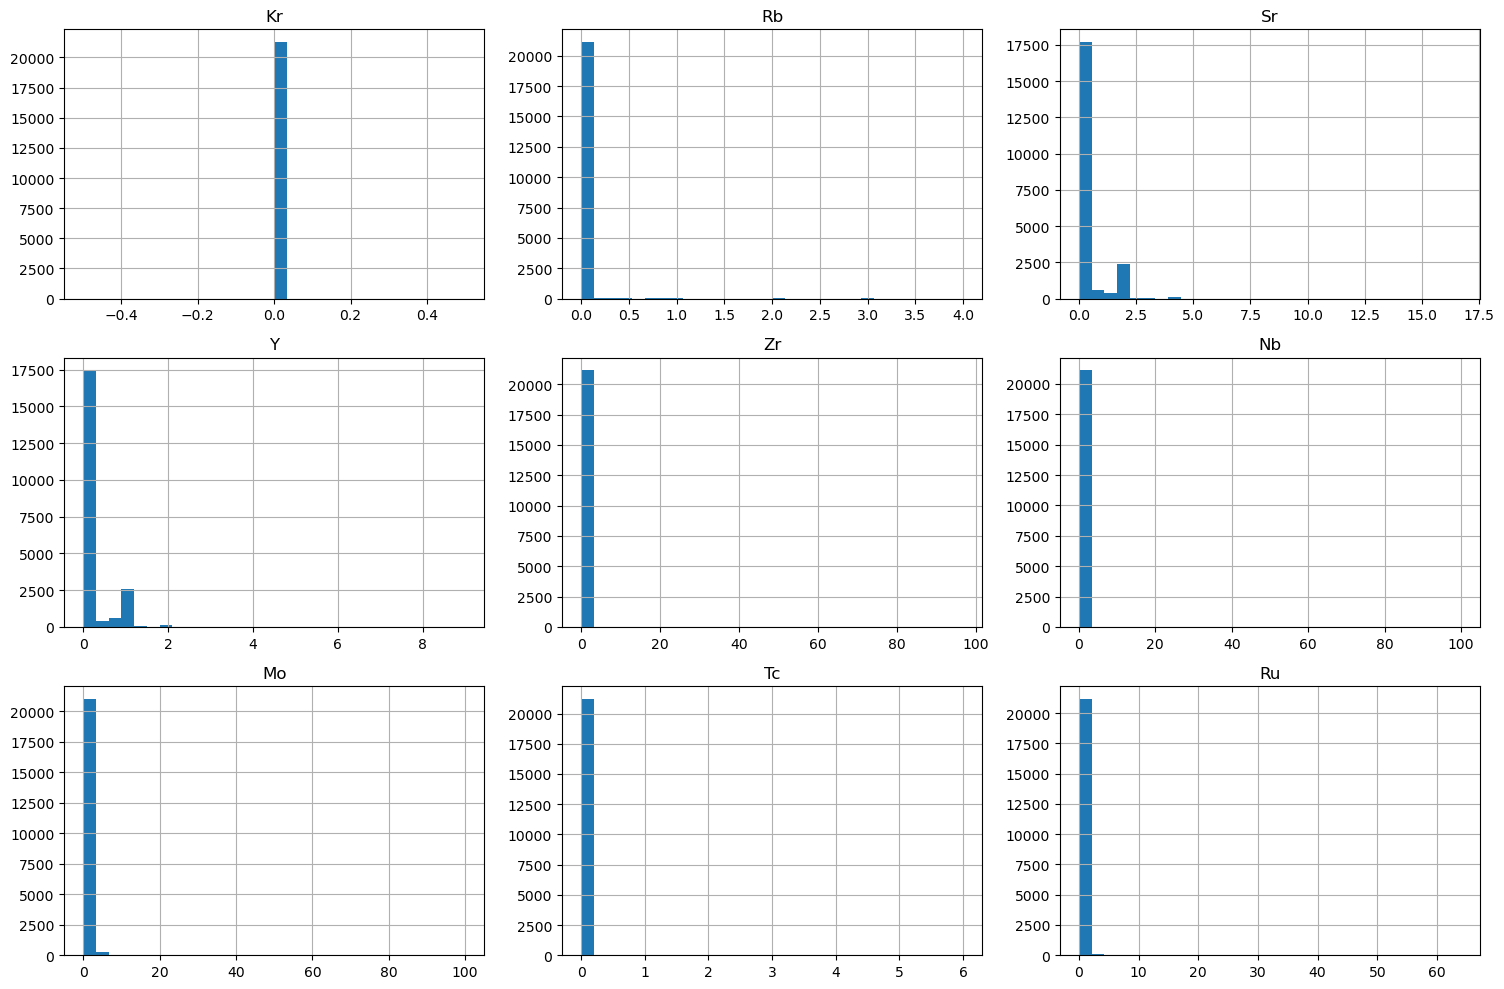

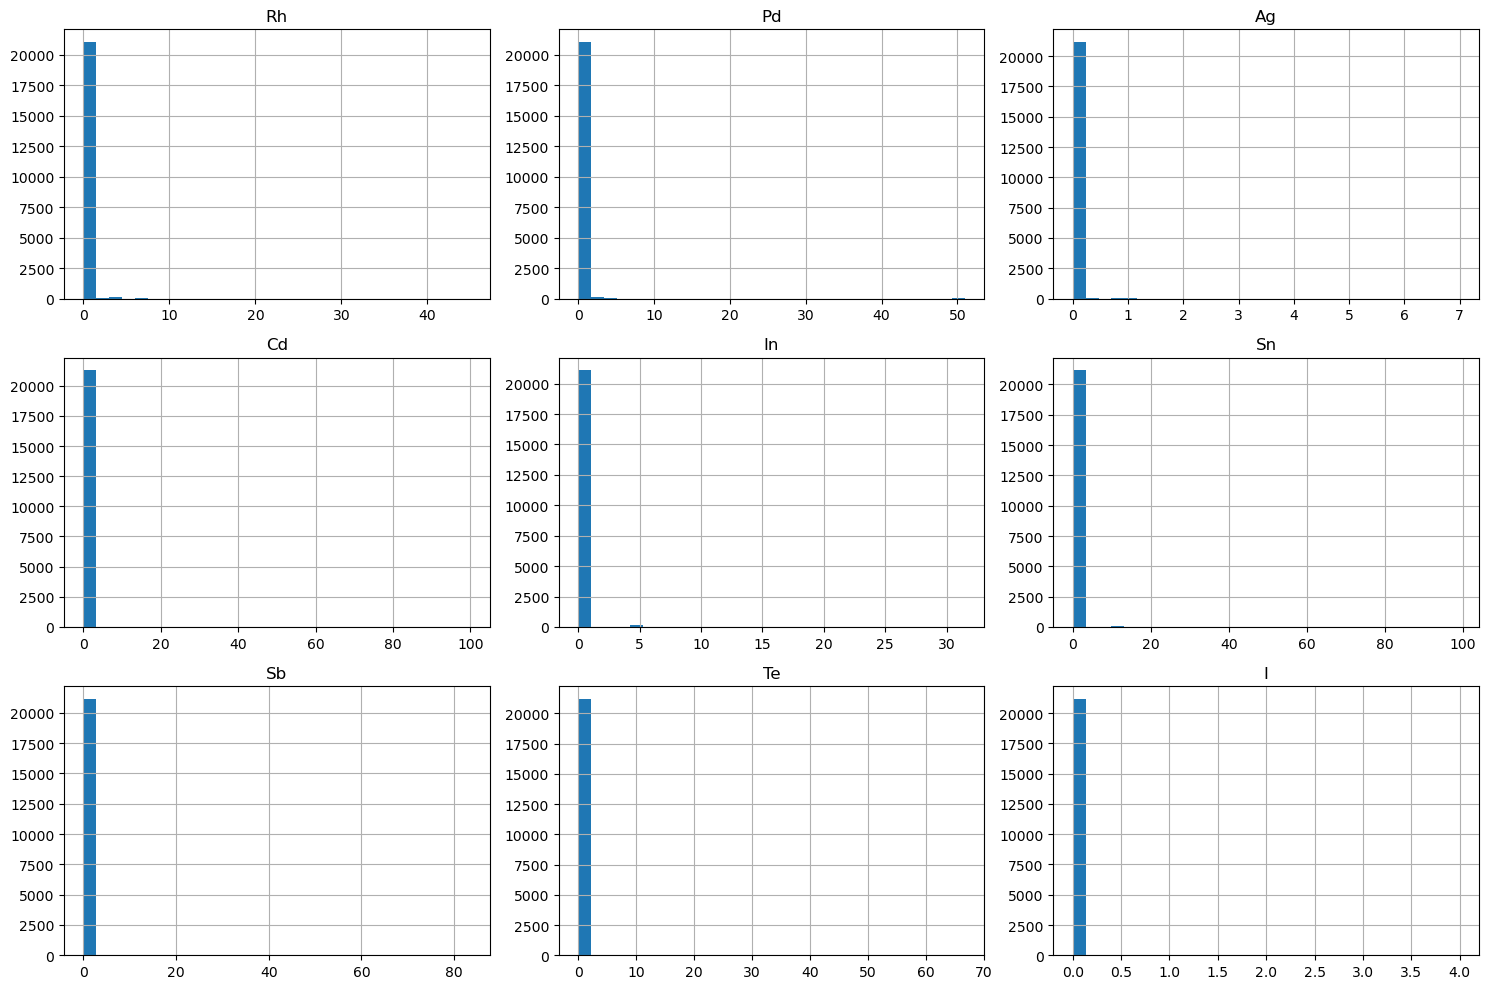

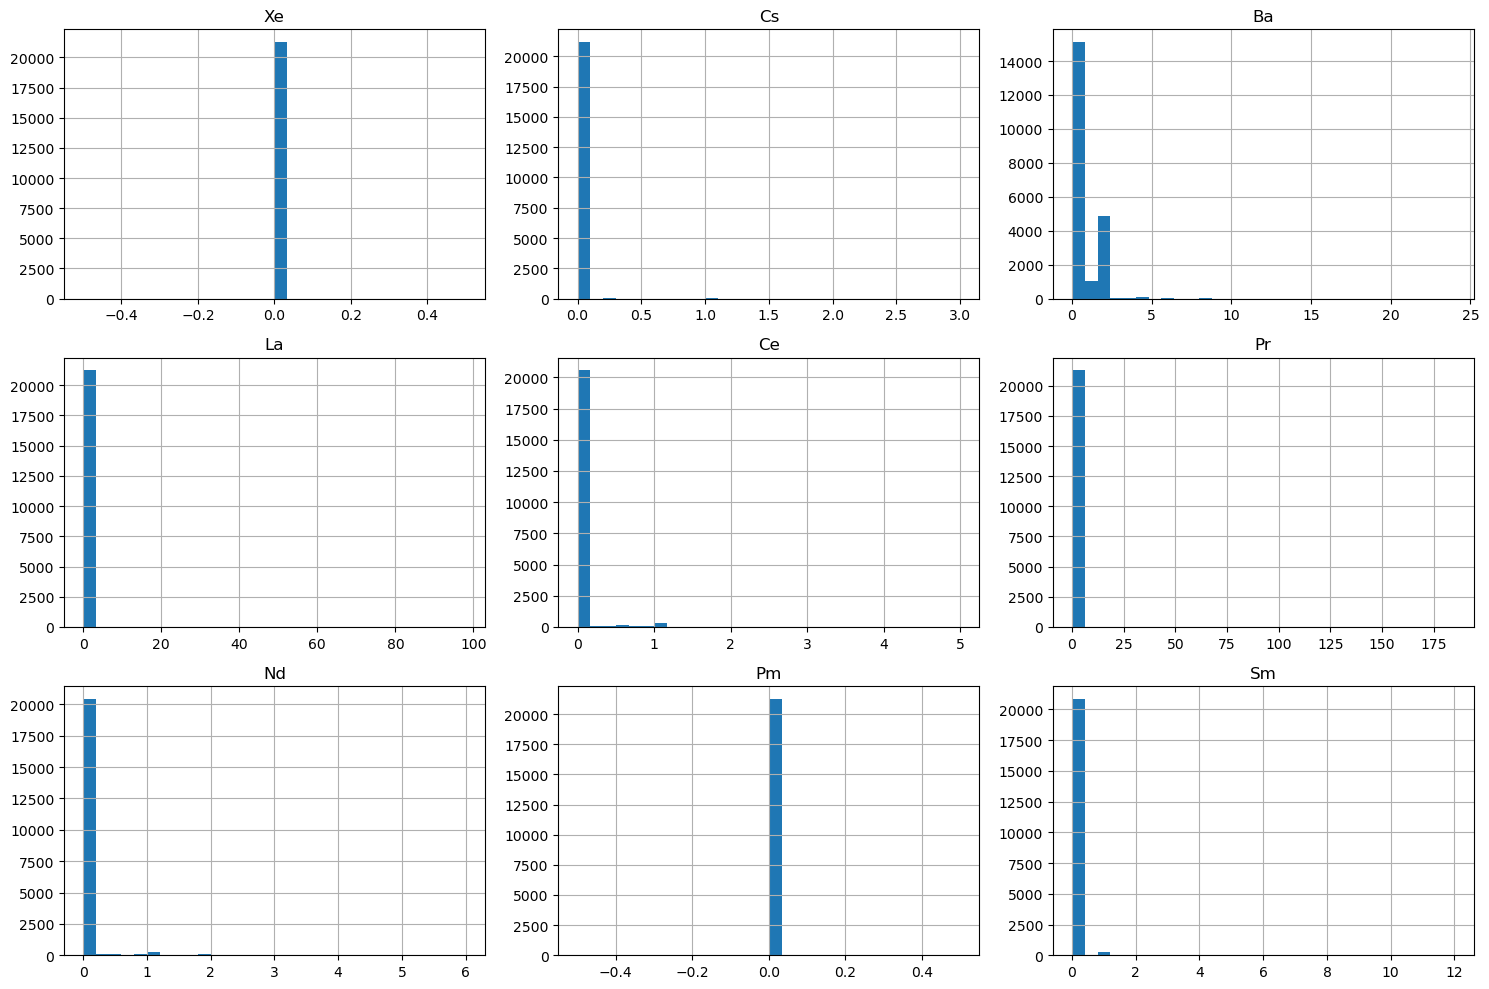

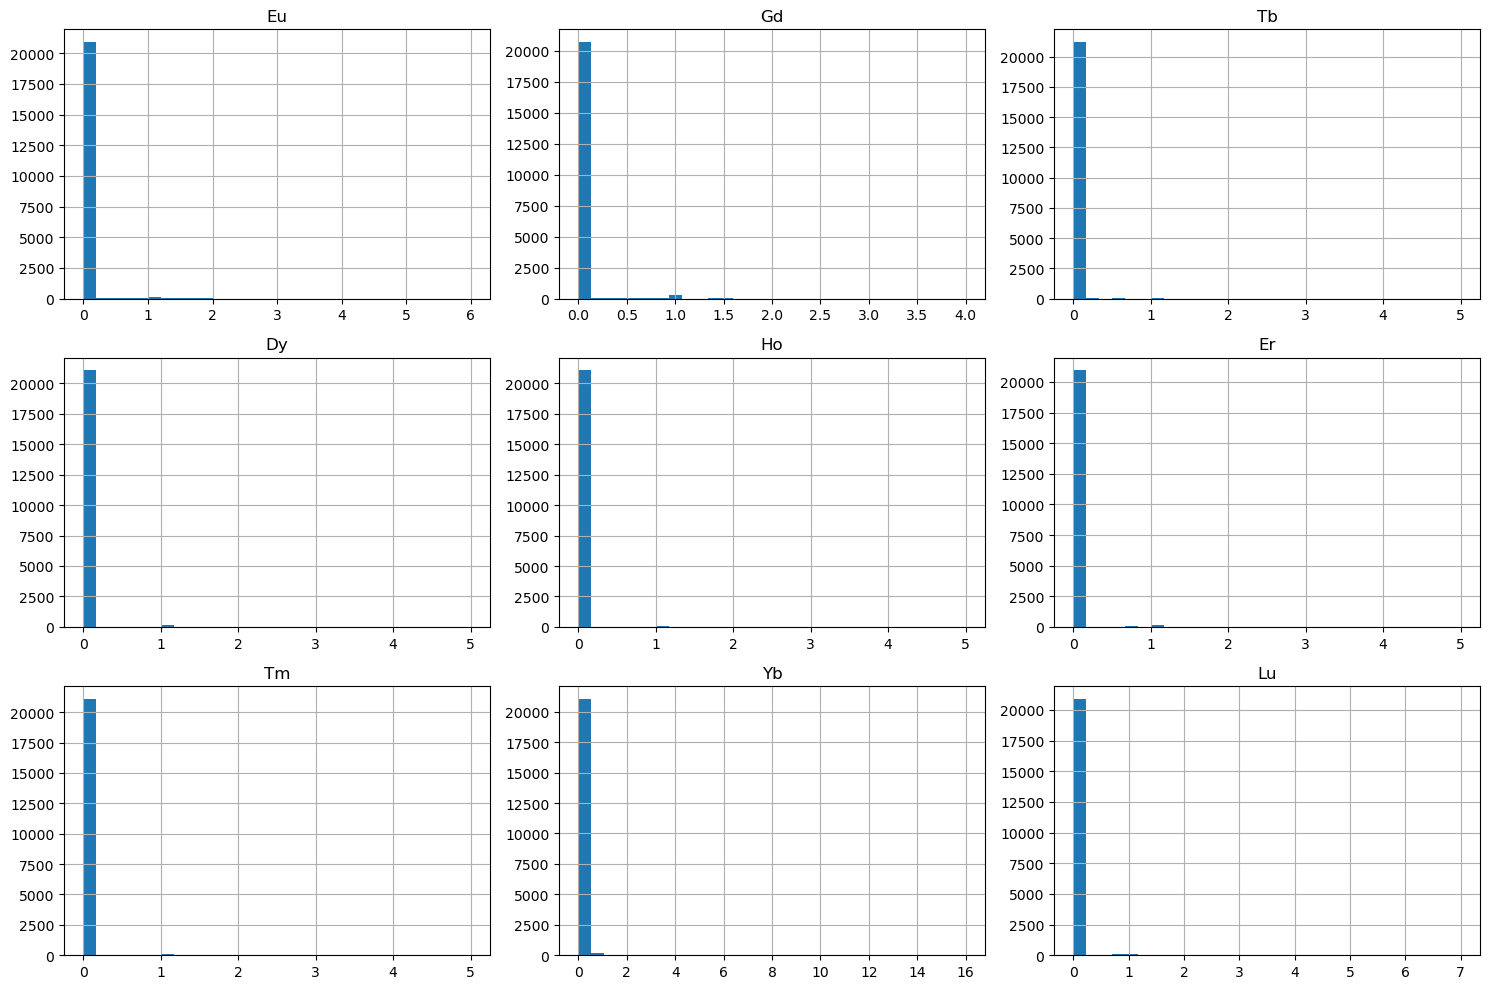

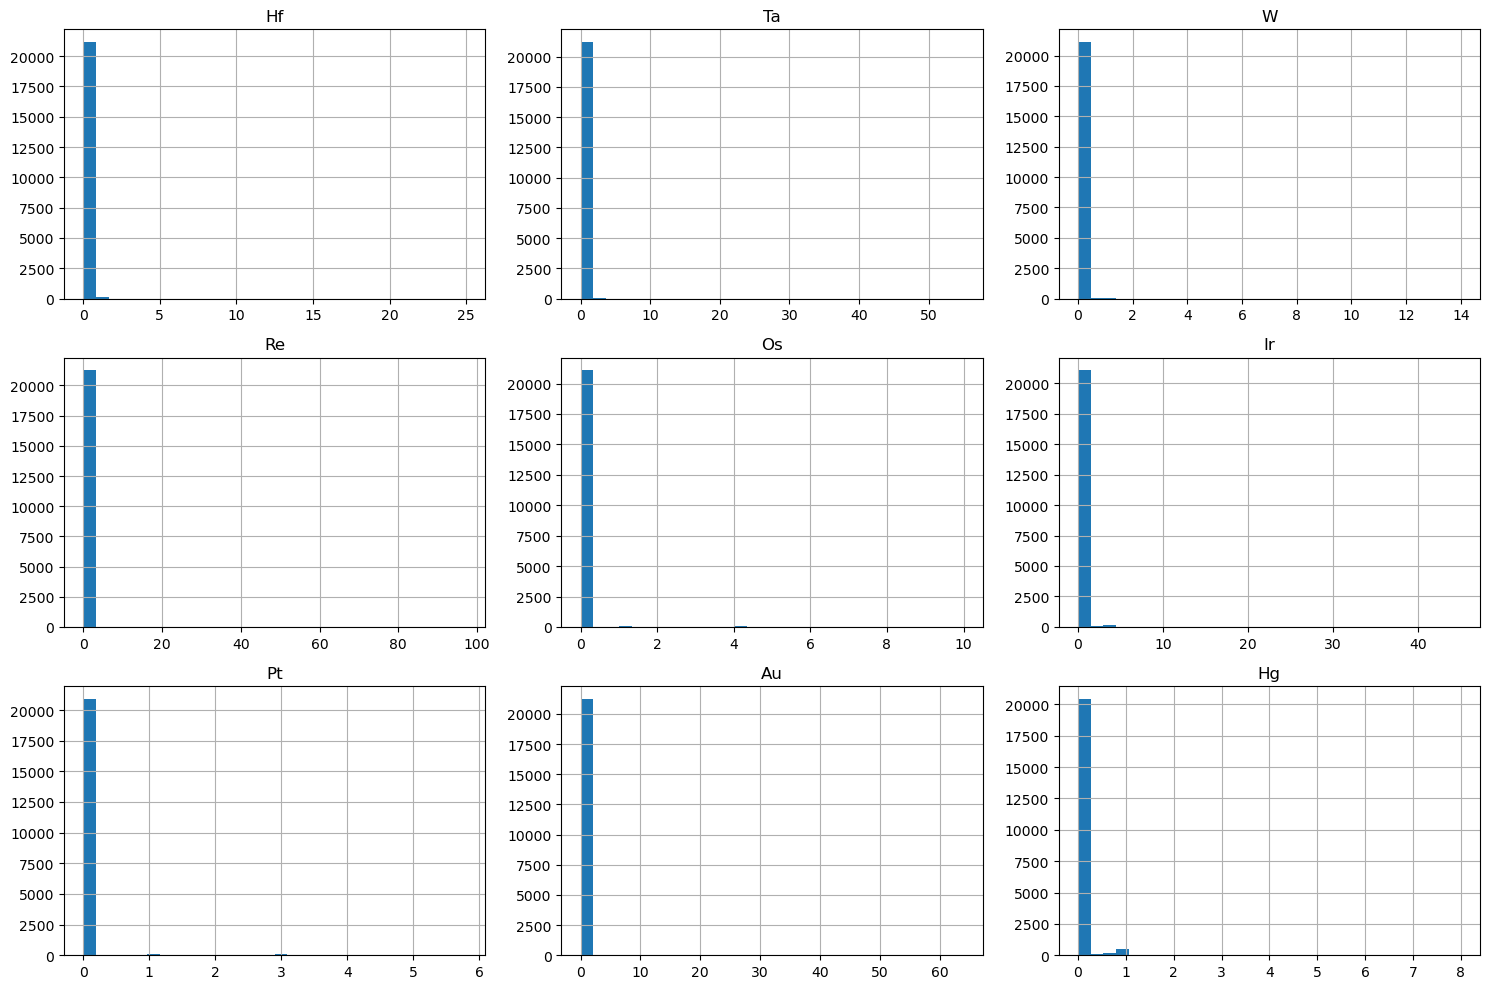

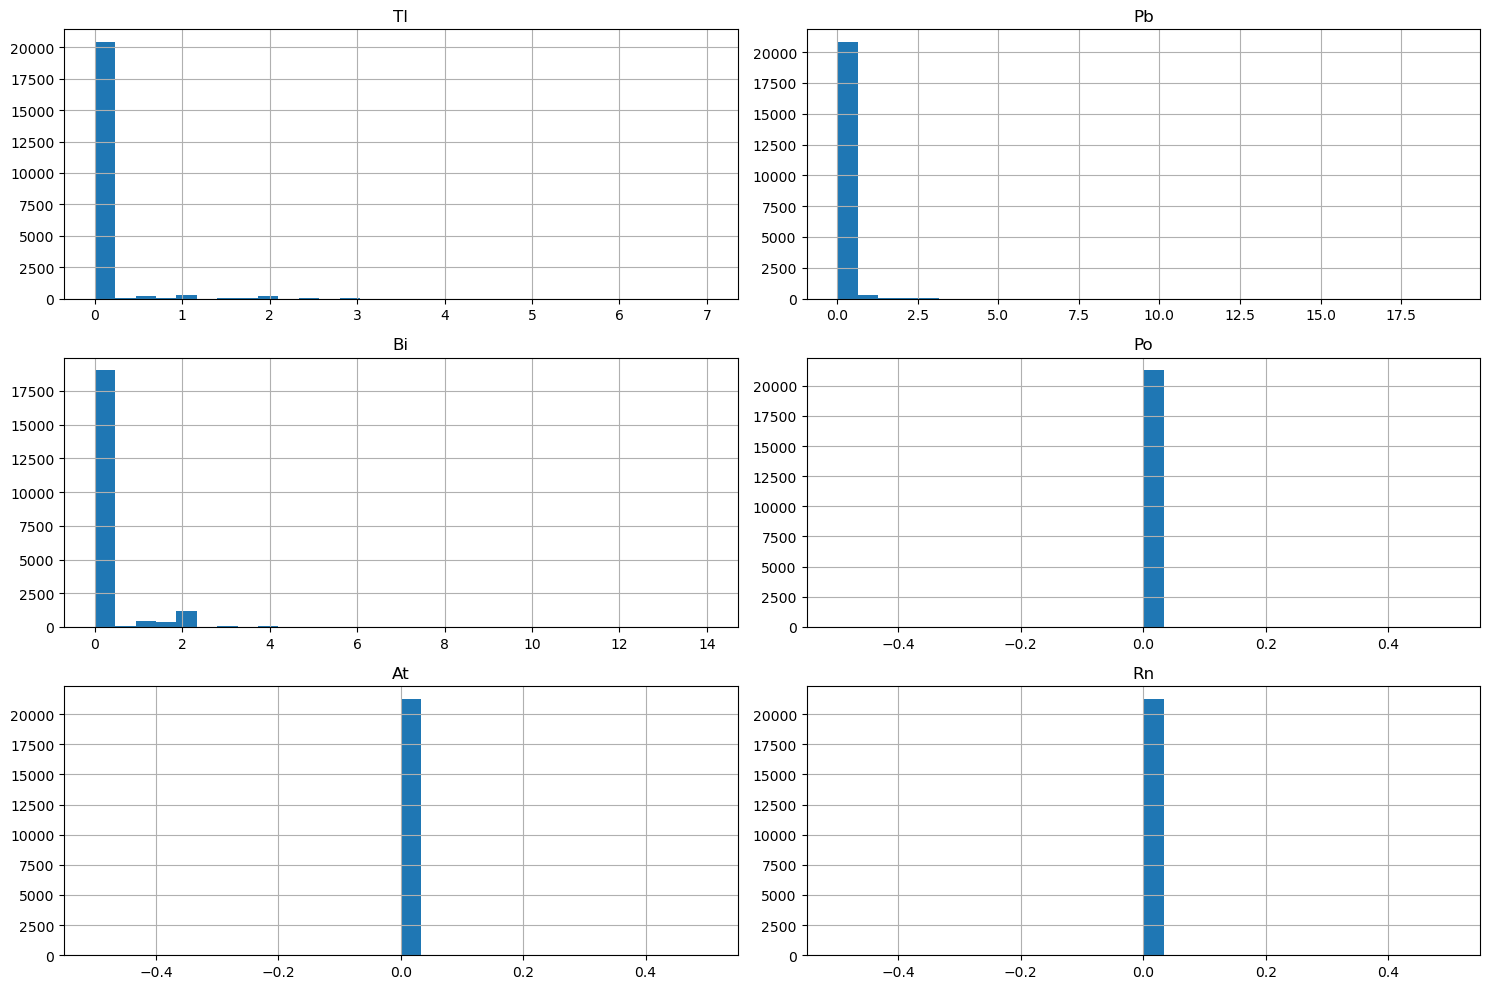

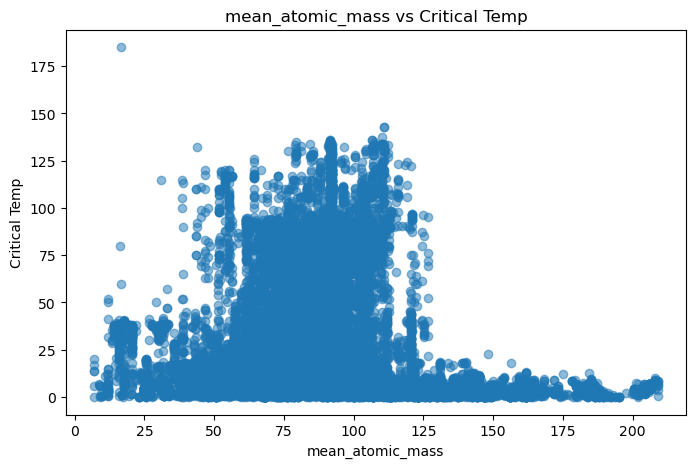

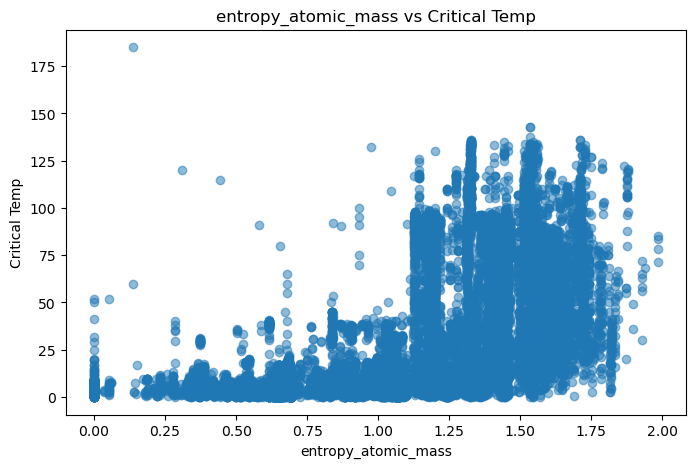

Training set size: (17010, 167), Test set size: (4253, 167)
Linear Regression - MSE: 272.6843, R²: 0.7631
Selected Features by Lasso: ['number_of_elements', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'mean_fie', 'range_fie', 'range_atomic_radius', 'gmean_Density', 'wtd_gmean_ElectronAffinity', 'wtd_std_FusionHeat', 'wtd_mean_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'Si', 'Ca', 'Ge', 'As', 'Sr', 'Ag', 'Ba', 'Ce', 'Nd', 'Hg', 'Tl', 'Bi']
Model Performance Metrics:
Linear Regression - MSE: 272.6843, R²: 0.7631
Lasso Regression - MSE: 332.1337, R²: 0.7115
Ridge Regression - MSE: 312.8370, R²: 0.7282


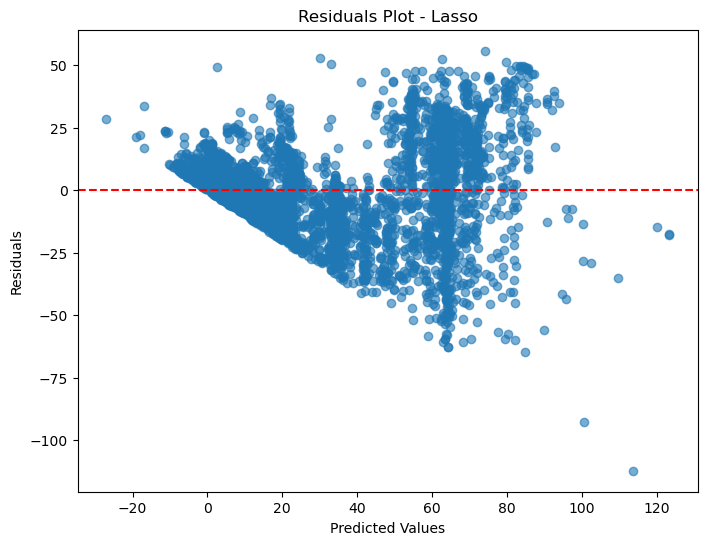

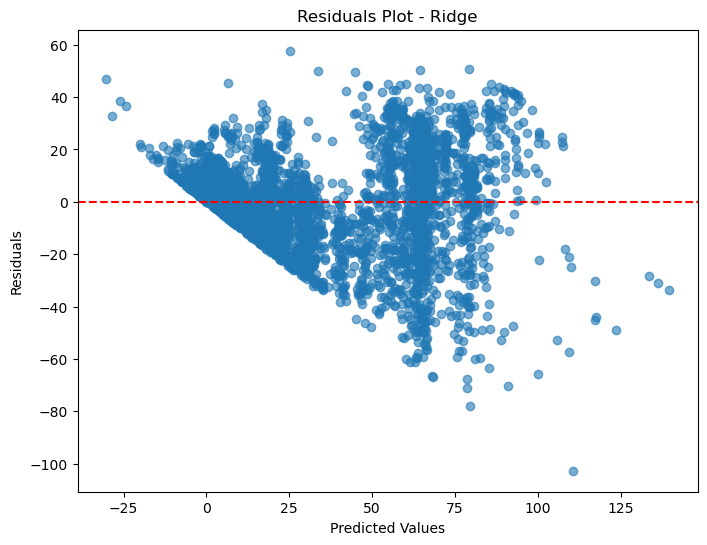

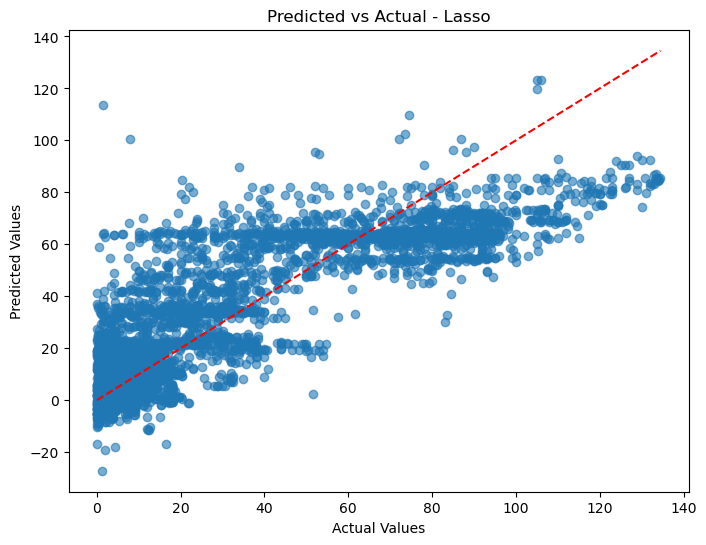

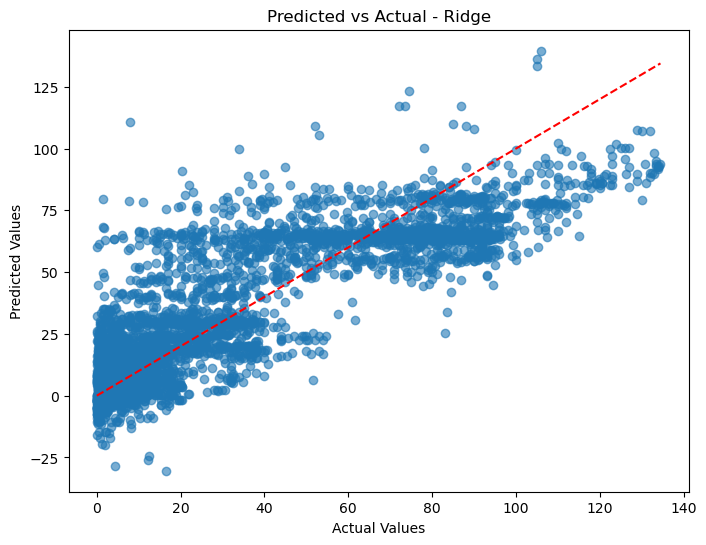

Lasso Cross-Validation - MSE: 368.4465, R²: 0.6869
Ridge Cross-Validation - MSE: 347.9315, R²: 0.7044


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------- Load and Explore Data ---------------------------- #
# Load datasets
data = pd.read_csv('train.csv')
metadata = pd.read_csv('unique_m.csv')

# Merge datasets
data = pd.merge(data, metadata.drop(columns=['critical_temp', 'material']), left_index=True, right_index=True)

# Display dataset summary
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# ---------------------------- Data Visualization ---------------------------- #
# Correlation heatmap
plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Histograms for all columns
batch_size = 9
columns = data.columns
for i in range(0, len(columns), batch_size):
    data[columns[i:i+batch_size]].hist(figsize=(15, 10), bins=30)
    plt.tight_layout()
    plt.show()

# Scatterplots of key features vs. target
selected_columns = ['mean_atomic_mass', 'entropy_atomic_mass', 'critical_temp']
for column in selected_columns[:-1]:  # Exclude the target column itself
    plt.figure(figsize=(8, 5))
    plt.scatter(data[column], data['critical_temp'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Critical Temp')
    plt.title(f'{column} vs Critical Temp')
    plt.show()

# ---------------------------- Preprocessing ---------------------------- #
# Define target and features
target_column = 'critical_temp'
X = data.drop(columns=[target_column])
y = data[target_column]

# Normalize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display split summary
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

# ---------------------------- Linear Regression ---------------------------- #
# Train and evaluate a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression - MSE: {linear_mse:.4f}, R²: {linear_r2:.4f}")

# ---------------------------- Lasso Regression ---------------------------- #
# Hyperparameter tuning for Lasso
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)

# Best Lasso model
best_lasso = lasso_grid.best_estimator_
lasso_preds = best_lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

# Feature selection with Lasso
lasso_selector = SelectFromModel(best_lasso, prefit=True)
selected_features = X_train.columns[lasso_selector.get_support()]
print(f"Selected Features by Lasso: {list(selected_features)}")

# ---------------------------- Ridge Regression ---------------------------- #
# Hyperparameter tuning for Ridge
ridge = Ridge(max_iter=10000)
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train[selected_features], y_train)

# Best Ridge model
best_ridge = ridge_grid.best_estimator_
ridge_preds = best_ridge.predict(X_test[selected_features])
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

# ---------------------------- Results Summary ---------------------------- #
# Print evaluation metrics
print("Model Performance Metrics:")
print(f"Linear Regression - MSE: {linear_mse:.4f}, R²: {linear_r2:.4f}")
print(f"Lasso Regression - MSE: {lasso_mse:.4f}, R²: {lasso_r2:.4f}")
print(f"Ridge Regression - MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

# ---------------------------- Visualization ---------------------------- #
# Residual plots for Lasso and Ridge
for preds, model_name in zip([lasso_preds, ridge_preds], ['Lasso', 'Ridge']):
    residuals = y_test - preds
    plt.figure(figsize=(8, 6))
    plt.scatter(preds, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals Plot - {model_name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

# Predicted vs Actual values
for preds, model_name in zip([lasso_preds, ridge_preds], ['Lasso', 'Ridge']):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f"Predicted vs Actual - {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

# ---------------------------- Cross-Validation ---------------------------- #
# Cross-validation for Lasso
lasso_cv_mse = -cross_val_score(best_lasso, X_train[selected_features], y_train, cv=10, scoring='neg_mean_squared_error').mean()
lasso_cv_r2 = cross_val_score(best_lasso, X_train[selected_features], y_train, cv=10, scoring='r2').mean()

# Cross-validation for Ridge
ridge_cv_mse = -cross_val_score(best_ridge, X_train[selected_features], y_train, cv=10, scoring='neg_mean_squared_error').mean()
ridge_cv_r2 = cross_val_score(best_ridge, X_train[selected_features], y_train, cv=10, scoring='r2').mean()

print(f"Lasso Cross-Validation - MSE: {lasso_cv_mse:.4f}, R²: {lasso_cv_r2:.4f}")
print(f"Ridge Cross-Validation - MSE: {ridge_cv_mse:.4f}, R²: {ridge_cv_r2:.4f}")


In [30]:
print(f"Length of selected_features: {len(selected_features)}")
print(f"Length of Ridge coefficients: {len(best_ridge.coef_)}")


Length of selected_features: 167
Length of Ridge coefficients: 25


In [31]:
from sklearn.feature_selection import SelectFromModel

# Assuming SelectFromModel was used earlier
sfm = SelectFromModel(best_ridge, prefit=True)  # Replace with your feature selection instance
selected_features_ridge = selected_features[sfm.get_support()]  # Get the retained features
print(f"Features used by Ridge: {selected_features_ridge}")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 167 but size of corresponding boolean axis is 25

Optimal Alpha: 0.004216965034285823, Optimal L1 Ratio: 0.99
Test Metrics: MAE=12.1776, MSE=307.9470, R²=0.7325


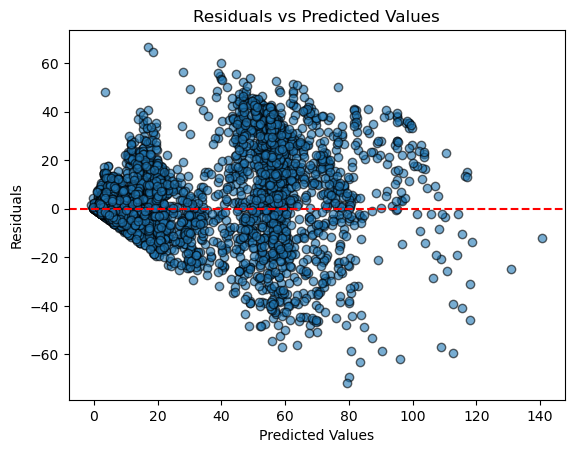

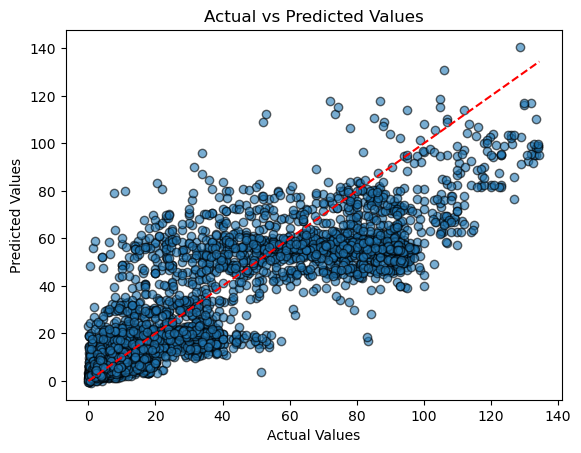

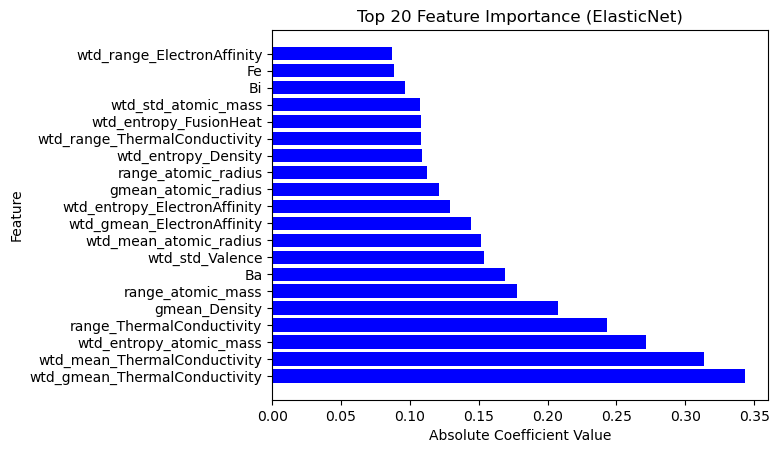

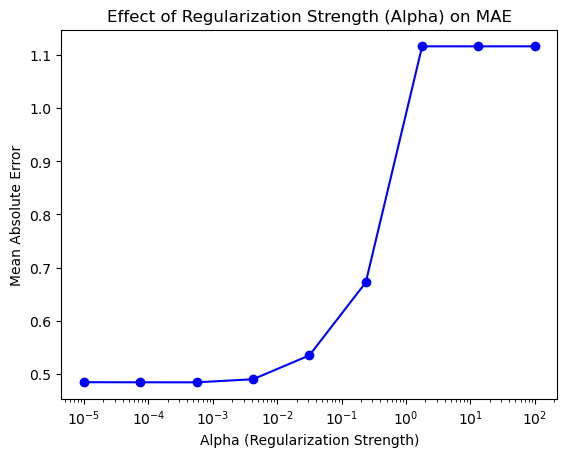

In [33]:
# === Libraries and Data Loading === #
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and merge datasets
train = pd.read_csv("train.csv")
metadata = pd.read_csv("unique_m.csv").drop(columns=["critical_temp", "material"], errors="ignore")
data = pd.merge(train, metadata, left_index=True, right_index=True)

# === Feature Engineering === #
# Drop highly correlated features (correlation > 0.95)
corr_matrix = data.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
data = data.drop(columns=to_drop)

# Separate features and target
X = data.drop(columns=["critical_temp"])
y = data["critical_temp"]

# Log-transform the target to address skewness
y_log = np.log1p(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === ElasticNet Modeling === #
# Hyperparameter tuning
param_grid = {
    "alpha": np.logspace(-5, 2, 9),
    "l1_ratio": np.linspace(0.01, 0.99, 50)
}
elastic_net = ElasticNet(max_iter=10000, random_state=42)
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]
best_l1_ratio = grid_search.best_params_["l1_ratio"]
print(f"Optimal Alpha: {best_alpha}, Optimal L1 Ratio: {best_l1_ratio}")

# === Model Evaluation === #
# Predictions
y_pred_test = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

# Metrics
mae_test = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test))
mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))
r2_test = r2_score(np.expm1(y_test), np.expm1(y_pred_test))

print(f"Test Metrics: MAE={mae_test:.4f}, MSE={mse_test:.4f}, R²={r2_test:.4f}")

# === Visualization === #
# Residuals Plot
residuals = np.expm1(y_test) - np.expm1(y_pred_test)
plt.scatter(np.expm1(y_pred_test), residuals, alpha=0.6, edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Actual vs Predicted
plt.scatter(np.expm1(y_test), np.expm1(y_pred_test), alpha=0.6, edgecolor="k")
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()],
         [np.expm1(y_test).min(), np.expm1(y_test).max()], color="red", linestyle="--")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Feature Importance
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": best_model.coef_
})
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False).head(20)

plt.barh(coefficients["Feature"], coefficients["Abs_Coefficient"], color="blue")
plt.title("Top 20 Feature Importance (ElasticNet)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()

# === Regularization Effect === #
alphas = np.logspace(-5, 2, 9)
mae_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=best_l1_ratio, random_state=42, max_iter=10000)
    mae = -cross_val_score(model, X_train_scaled, y_train, cv=10, scoring="neg_mean_absolute_error").mean()
    mae_scores.append(mae)

plt.plot(alphas, mae_scores, marker="o", color="blue")
plt.xscale("log")
plt.title("Effect of Regularization Strength (Alpha) on MAE")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Absolute Error")
plt.show()


Initial Dataset Shape: (21263, 168)
Missing Values (After Imputation): 0
Dataset Shape After Removing Correlated Features: (21263, 145)
Best ElasticNet Alpha: 0.004216965034285823
Best ElasticNet L1 Ratio: 0.99
ElasticNet Results (Test Set): MAE=0.4811, MSE=0.3937, R²=0.7643
Ridge Results: MSE=0.3807, R²=0.7721
Lasso Results: MSE=0.3938, R²=0.7643


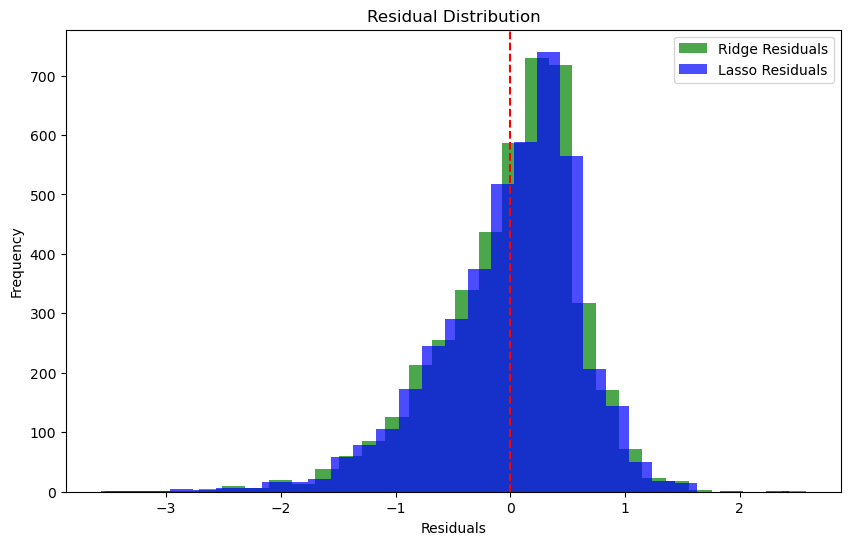

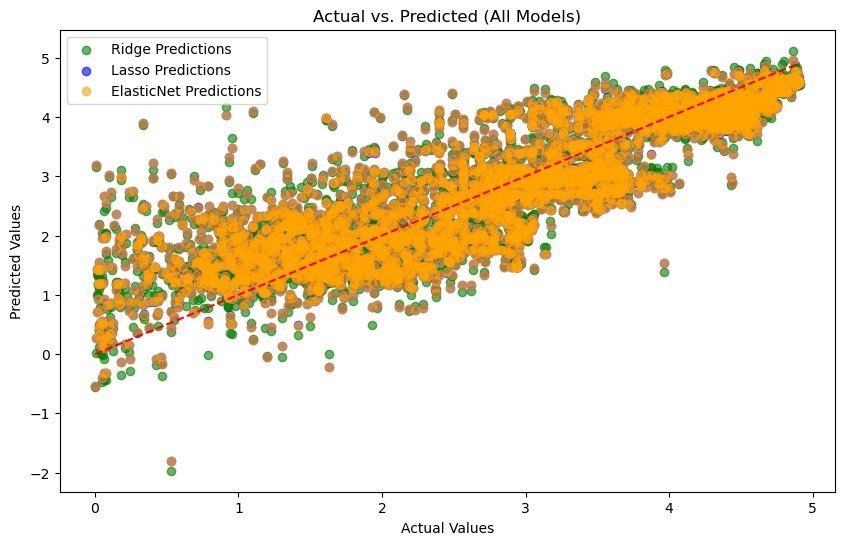

c:\ProgramData\miniforge3\envs\pythonGPU\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix:
 [[1874  289]
 [ 150 1940]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      2163
           1       0.87      0.93      0.90      2090

    accuracy                           0.90      4253
   macro avg       0.90      0.90      0.90      4253
weighted avg       0.90      0.90      0.90      4253

AUC-ROC Score: 0.9628


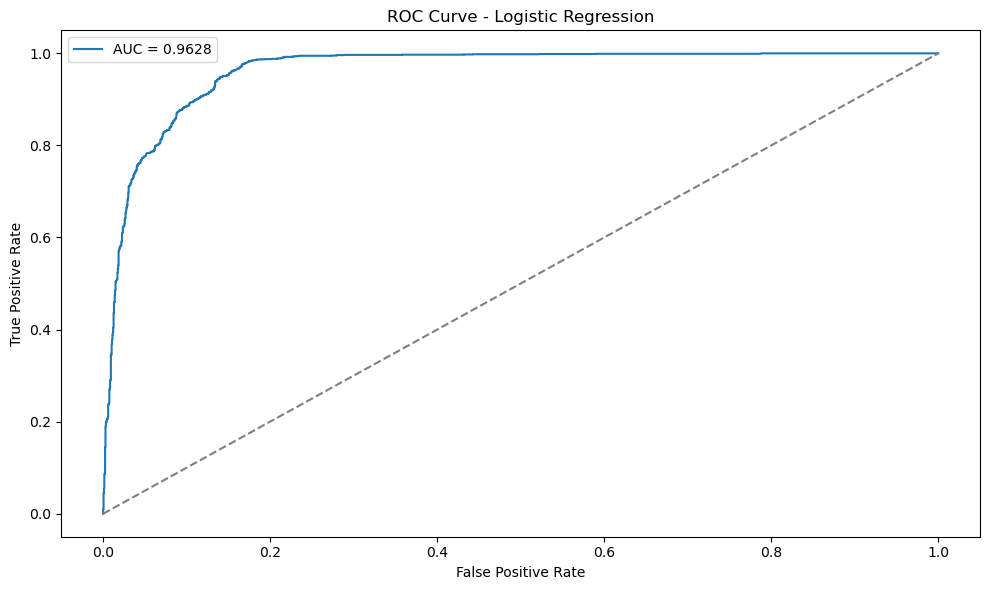


Case Study Summary:
1. Data Size: 21263 samples, 144 features.
2. Ridge MSE: 0.3807, R²: 0.7721
3. Lasso MSE: 0.3938, R²: 0.7643
4. ElasticNet Test Metrics: MAE=0.4811, MSE=0.3937, R²=0.7643
5. Logistic Regression AUC-ROC: 0.9628


In [32]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------
# 1. Data Loading and Preprocessing
# ---------------------------------------------

# Load datasets
train_data = pd.read_csv("train.csv")
metadata = pd.read_csv("unique_m.csv")

# Merge datasets and drop unnecessary columns
metadata = metadata.drop(columns=["critical_temp", "material"])
data = pd.merge(train_data, metadata, left_index=True, right_index=True)

# Handle missing values with mean imputation
data.fillna(data.mean(), inplace=True)

# Check dataset size
print(f"Initial Dataset Shape: {data.shape}")
print(f"Missing Values (After Imputation): {data.isnull().sum().sum()}")

# ---------------------------------------------
# 2. Handle Multicollinearity
# ---------------------------------------------

# Compute and remove highly correlated features (correlation > 0.95)
correlation_matrix = data.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
data = data.drop(columns=to_drop)

print(f"Dataset Shape After Removing Correlated Features: {data.shape}")

# ---------------------------------------------
# 3. Feature and Target Preparation
# ---------------------------------------------

# Define features and target
X = data.drop(columns=["critical_temp"])
y = data["critical_temp"]

# Log-transform the target to reduce skewness
y_log = np.log1p(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------------------------
# 4. ElasticNet Regression with Hyperparameter Tuning
# ---------------------------------------------

# Hyperparameter grid for ElasticNet
elastic_net_params = {
    'alpha': np.logspace(-5, 2, 9),  # Regularization strengths
    'l1_ratio': np.linspace(0.1, 0.99, 10)  # Mixing ratio
}

elastic_net = ElasticNet(max_iter=10000, random_state=42)
grid_search = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best ElasticNet model
best_elastic_net = grid_search.best_estimator_
optimal_alpha = grid_search.best_params_["alpha"]
optimal_l1_ratio = grid_search.best_params_["l1_ratio"]

print(f"Best ElasticNet Alpha: {optimal_alpha}")
print(f"Best ElasticNet L1 Ratio: {optimal_l1_ratio}")

# Predictions
y_pred_test = best_elastic_net.predict(X_test_scaled)
y_pred_train = best_elastic_net.predict(X_train_scaled)

# Evaluate ElasticNet (on log-transformed scale)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"ElasticNet Results (Test Set): MAE={test_mae:.4f}, MSE={test_mse:.4f}, R²={test_r2:.4f}")

# ---------------------------------------------
# 5. Ridge and Lasso Regression
# ---------------------------------------------

# Ridge Regression
ridge_params = {'alpha': np.logspace(-5, 2, 9)}
ridge = Ridge(max_iter=10000)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_

# Lasso Regression
lasso_params = {'alpha': np.logspace(-5, 2, 9)}
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)
best_lasso = lasso_grid.best_estimator_

# Ridge and Lasso Metrics
ridge_preds = best_ridge.predict(X_test_scaled)
lasso_preds = best_lasso.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

print(f"Ridge Results: MSE={ridge_mse:.4f}, R²={ridge_r2:.4f}")
print(f"Lasso Results: MSE={lasso_mse:.4f}, R²={lasso_r2:.4f}")

# ---------------------------------------------
# 6. Visualization: Regression Results
# ---------------------------------------------

# Residual Plot
plt.figure(figsize=(10, 6))
plt.hist(y_test - ridge_preds, bins=30, alpha=0.7, label='Ridge Residuals', color='green')
plt.hist(y_test - lasso_preds, bins=30, alpha=0.7, label='Lasso Residuals', color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Actual vs Predicted (All Models)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_preds, alpha=0.6, label='Ridge Predictions', color='green')
plt.scatter(y_test, lasso_preds, alpha=0.6, label='Lasso Predictions', color='blue')
plt.scatter(y_test, y_pred_test, alpha=0.6, label='ElasticNet Predictions', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs. Predicted (All Models)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

# ---------------------------------------------
# 7. Binary Classification with Logistic Regression
# ---------------------------------------------

# Convert target to binary (threshold: median)
threshold = np.median(y)
y_binary = (y > threshold).astype(int)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train_bin, y_train_bin)

# Predictions and metrics
y_pred_bin = log_reg.predict(X_test_bin)
y_pred_proba = log_reg.predict_proba(X_test_bin)[:, 1]

conf_matrix = confusion_matrix(y_test_bin, y_pred_bin)
roc_auc = roc_auc_score(y_test_bin, y_pred_proba)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred_bin))
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 8. Final Case Study Summary
# ---------------------------------------------
print("\nCase Study Summary:")
print(f"1. Data Size: {X.shape[0]} samples, {X.shape[1]} features.")
print(f"2. Ridge MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")
print(f"3. Lasso MSE: {lasso_mse:.4f}, R²: {lasso_r2:.4f}")
print(f"4. ElasticNet Test Metrics: MAE={test_mae:.4f}, MSE={test_mse:.4f}, R²={test_r2:.4f}")
print(f"5. Logistic Regression AUC-ROC: {roc_auc:.4f}")
